In [47]:
import datetime
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score, precision_recall_curve, roc_auc_score, roc_curve)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import label_binarize
from xgboost import XGBClassifier

import shap

%config InlineBackend.figure_format = 'retina'

In [48]:
from notebook import notebookapp
import urllib
import json
import ipykernel
from shutil import copy2

def notebook_path():
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None


def copy_current_nb(new_name):
    nb = notebook_path()
    if nb:
        new_path = os.path.join(os.path.dirname(nb), new_name+'.ipynb')
        copy2(nb, new_path)
    else:
        print("Current notebook path cannot be determined.")

In [49]:
df = pd.read_csv('Data/cover_type_engineered.csv')

In [50]:
df = df.loc[:, [col for col in df if not col.startswith('Cover_Type_')]]
X = df.drop(columns=['Cover_Type', 'Aspect_Sector'])
y = df['Cover_Type'] - 1

In [46]:
#!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 MB 2.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 1.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for catboost (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [40 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-10.9-x86_64-cpython-39
      creating build/lib.macosx-10.9-x86_64-cpython-39/catboost
      copying catboost/monoforest.py -> build/lib.macosx-10.9-x86_64-cpython-39/catboost
      copying catboost/plot_helpers.py -> build/lib.macosx-10.9-x86_64-cpython-39/catboost
      copying catboost/metrics.py -> build/lib.macosx-10.9-x86_64-cpython-39/catboost
      copying catboost/carry.py -> build/lib.macosx-10.9-x86_6

In [45]:
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M")

warnings.filterwarnings("ignore", category=FutureWarning, module="pandas.api.types")

# Assuming X and y are defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

# Define the estimator
estimator = XGBClassifier(tree_method="hist")

# Define hyperparameters for tuning
hyperparameters = {
    "n_estimators": stats.randint(50, 150),  # Increased range
    "learning_rate": stats.uniform(0.05, 0.1),  # Adjusted range
    "colsample_bytree": stats.uniform(0.6, 0.4),
    "colsample_bylevel": stats.uniform(0.6, 0.4),
    "colsample_bynode": stats.uniform(0.6, 0.4),
    "max_depth": stats.randint(15, 50),  # Increased range
    "subsample": stats.uniform(0.6, 0.4),
    "gamma": stats.uniform(0, 2),  # Adjusted range
    "reg_lambda": stats.uniform(0, 2),  # Adjusted range
    "reg_alpha": stats.uniform(0, 2),  # Adjusted range
}

# Define the RandomizedSearchCV parameters
random_search = RandomizedSearchCV(estimator, 
                                   param_distributions=hyperparameters, 
                                   scoring='accuracy',
                                   return_train_score=True,
                                   n_iter=10, 
                                   cv=5, 
                                   verbose=10, 
                                   n_jobs=-1)

# Fit the RandomizedSearchCV
try:
    random_search.fit(X_train, y_train)  # Assuming X_train and y_train are defined
    print("Best parameters found:", random_search.best_params_)
    print("Best score found:", random_search.best_score_)

    
    # Save results
    results_path = f"./tuning_results/tuning_xgb/{timestamp}"
    if not os.path.exists(results_path):
        os.makedirs(results_path)
        
    # Saving cross-validation results
    cv_results = pd.DataFrame(random_search.cv_results_)
    cv_results_file = f"{timestamp}_results.csv"
    cv_results.to_csv(os.path.join(results_path, cv_results_file), index=False)
    
    # Save .ipynb
    copy_current_nb(os.path.join(results_path, 'Evaluation_Notebook'))
    
    # Save Model
    file_name = f"xgb_{timestamp}.pkl"
    pickle.dump(random_search, open(os.path.join(results_path, file_name), "wb"))
        

except Exception as e:
    print(f"An error occurred during model optimization: {e}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found: {'colsample_bylevel': 0.6070730221931728, 'colsample_bynode': 0.8692420848416975, 'colsample_bytree': 0.9821744422562326, 'gamma': 0.15566884469408904, 'learning_rate': 0.10455033309037934, 'max_depth': 46, 'n_estimators': 69, 'reg_alpha': 0.5972789650576651, 'reg_lambda': 0.3897488900153101, 'subsample': 0.9855058509165522}
Best score found: 0.8615004935834156
[CV 3/5; 2/10] START colsample_bylevel=0.8163736343422624, colsample_bynode=0.9034801031292766, colsample_bytree=0.8924773575368665, gamma=1.8891089265438652, learning_rate=0.10620911663492166, max_depth=48, n_estimators=59, reg_alpha=0.7053746309015103, reg_lambda=1.4600750527482764, subsample=0.7548727072666599
[CV 3/5; 2/10] END colsample_bylevel=0.8163736343422624, colsample_bynode=0.9034801031292766, colsample_bytree=0.8924773575368665, gamma=1.8891089265438652, learning_rate=0.10620911663492166, max_depth=48, n_estimators=59, reg_alpha=0.70

[CV 5/5; 1/10] START colsample_bylevel=0.6982776040577087, colsample_bynode=0.8906909223710489, colsample_bytree=0.6044165246993275, gamma=1.844973870223651, learning_rate=0.061160428025275215, max_depth=25, n_estimators=104, reg_alpha=0.6625307484855807, reg_lambda=1.2739998669942478, subsample=0.6442154407792042
[CV 5/5; 1/10] END colsample_bylevel=0.6982776040577087, colsample_bynode=0.8906909223710489, colsample_bytree=0.6044165246993275, gamma=1.844973870223651, learning_rate=0.061160428025275215, max_depth=25, n_estimators=104, reg_alpha=0.6625307484855807, reg_lambda=1.2739998669942478, subsample=0.6442154407792042;, score=(train=0.896, test=0.826) total time=   2.6s
[CV 4/5; 3/10] START colsample_bylevel=0.6038865034292248, colsample_bynode=0.7584272585667341, colsample_bytree=0.774519163076345, gamma=0.2026213641708665, learning_rate=0.13704534131976742, max_depth=34, n_estimators=62, reg_alpha=1.3210385745403228, reg_lambda=0.6411355413658504, subsample=0.9611549129215472
[CV

[CV 4/5; 1/10] START colsample_bylevel=0.6982776040577087, colsample_bynode=0.8906909223710489, colsample_bytree=0.6044165246993275, gamma=1.844973870223651, learning_rate=0.061160428025275215, max_depth=25, n_estimators=104, reg_alpha=0.6625307484855807, reg_lambda=1.2739998669942478, subsample=0.6442154407792042
[CV 4/5; 1/10] END colsample_bylevel=0.6982776040577087, colsample_bynode=0.8906909223710489, colsample_bytree=0.6044165246993275, gamma=1.844973870223651, learning_rate=0.061160428025275215, max_depth=25, n_estimators=104, reg_alpha=0.6625307484855807, reg_lambda=1.2739998669942478, subsample=0.6442154407792042;, score=(train=0.894, test=0.838) total time=   2.6s
[CV 1/5; 4/10] START colsample_bylevel=0.6070730221931728, colsample_bynode=0.8692420848416975, colsample_bytree=0.9821744422562326, gamma=0.15566884469408904, learning_rate=0.10455033309037934, max_depth=46, n_estimators=69, reg_alpha=0.5972789650576651, reg_lambda=0.3897488900153101, subsample=0.9855058509165522
[

In [5]:
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       5.336861      0.055121         0.157636        0.011598   
1      15.937323      0.135157         0.332792        0.040915   
2       6.126328      0.257011         0.138189        0.011798   
3       6.921354      0.253393         0.184841        0.009864   
4      11.872256      0.038966         0.274554        0.014308   

  param_colsample_bylevel param_colsample_bynode param_colsample_bytree  \
0                0.749844                 0.7252               0.665649   
1                0.796353                0.75188               0.900822   
2                0.882444               0.950672               0.651316   
3                0.686216               0.823657               0.667312   
4                0.751606               0.986695               0.666217   

  param_gamma param_learning_rate param_max_depth  ... mean_test_score  \
0    1.466569            0.093087              43  ...        0.832083   
1    0.211412            0.063449              43  ...        0.861500   
2    1.891476            0.113697              21  ...        0.831885   
3    0.178086            0.114021              30  ...        0.846199   
4    0.054689            0.065551              24  ...        0.849457   

  std_test_score rank_test_score split0_train_score split1_train_score  \
0       0.007482               7           0.916708           0.918806   
1       0.006395               1           0.999753           0.999877   
2       0.011447               8           0.911772           0.909798   
3       0.006010               5           0.982354           0.980503   
4       0.006541               4           0.980380           0.979146   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.917695            0.916955            0.914980   
1            0.999877            0.999753            0.999877   
2            0.906466            0.909551            0.909798   
3            0.982354            0.982478            0.984082   
4            0.981367            0.980257            0.981120   

   mean_train_score  std_train_score  
0          0.917029         0.001257  
1          0.999827         0.000060  
2          0.909477         0.001706  
3          0.982354         0.001134  
4          0.980454         0.000779  

[5 rows x 30 columns]

In [6]:
results_path = f"./tuning_results/tuning_xgb/{timestamp}/Assets"
if not os.path.exists(results_path):
    os.makedirs(results_path)

# CV Evaluation

In [7]:
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_colsample_bylevel', 'param_colsample_bynode',
       'param_colsample_bytree', 'param_gamma', 'param_learning_rate',
       'param_max_depth', 'param_n_estimators', 'param_reg_alpha',
       'param_reg_lambda', 'param_subsample', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [8]:
cv_results.sort_values(by='rank_test_score', ascending=True).head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1      15.937323      0.135157         0.332792        0.040915   
9       6.540673      0.485846         0.138564        0.029772   
8       6.561709      0.042076         0.168278        0.043369   
4      11.872256      0.038966         0.274554        0.014308   
3       6.921354      0.253393         0.184841        0.009864   

  param_colsample_bylevel param_colsample_bynode param_colsample_bytree  \
1                0.796353                0.75188               0.900822   
9                0.712587               0.704594               0.714839   
8                0.795132               0.644419               0.945577   
4                0.751606               0.986695               0.666217   
3                0.686216               0.823657               0.667312   

  param_gamma param_learning_rate param_max_depth  ... mean_test_score  \
1    0.211412            0.063449              43  ...        0.861500   
9    0.680936            0.084688              25  ...        0.853899   
8    0.589158            0.136662              21  ...        0.850543   
4    0.054689            0.065551              24  ...        0.849457   
3    0.178086            0.114021              30  ...        0.846199   

  std_test_score rank_test_score split0_train_score split1_train_score  \
1       0.006395               1           0.999753           0.999877   
9       0.007084               2           0.980750           0.979146   
8       0.003672               3           0.970755           0.971866   
4       0.006541               4           0.980380           0.979146   
3       0.006010               5           0.982354           0.980503   

   split2_train_score  split3_train_score  split4_train_score  \
1            0.999877            0.999753            0.999877   
9            0.980010            0.978282            0.980997   
8            0.972976            0.970262            0.973963   
4            0.981367            0.980257            0.981120   
3            0.982354            0.982478            0.984082   

   mean_train_score  std_train_score  
1          0.999827         0.000060  
9          0.979837         0.001010  
8          0.971964         0.001371  
4          0.980454         0.000779  
3          0.982354         0.001134  

[5 rows x 30 columns]

In [9]:
sorted_cv = cv_results.sort_values(by='rank_test_score', ascending=True)

# Train vs Test Comparison

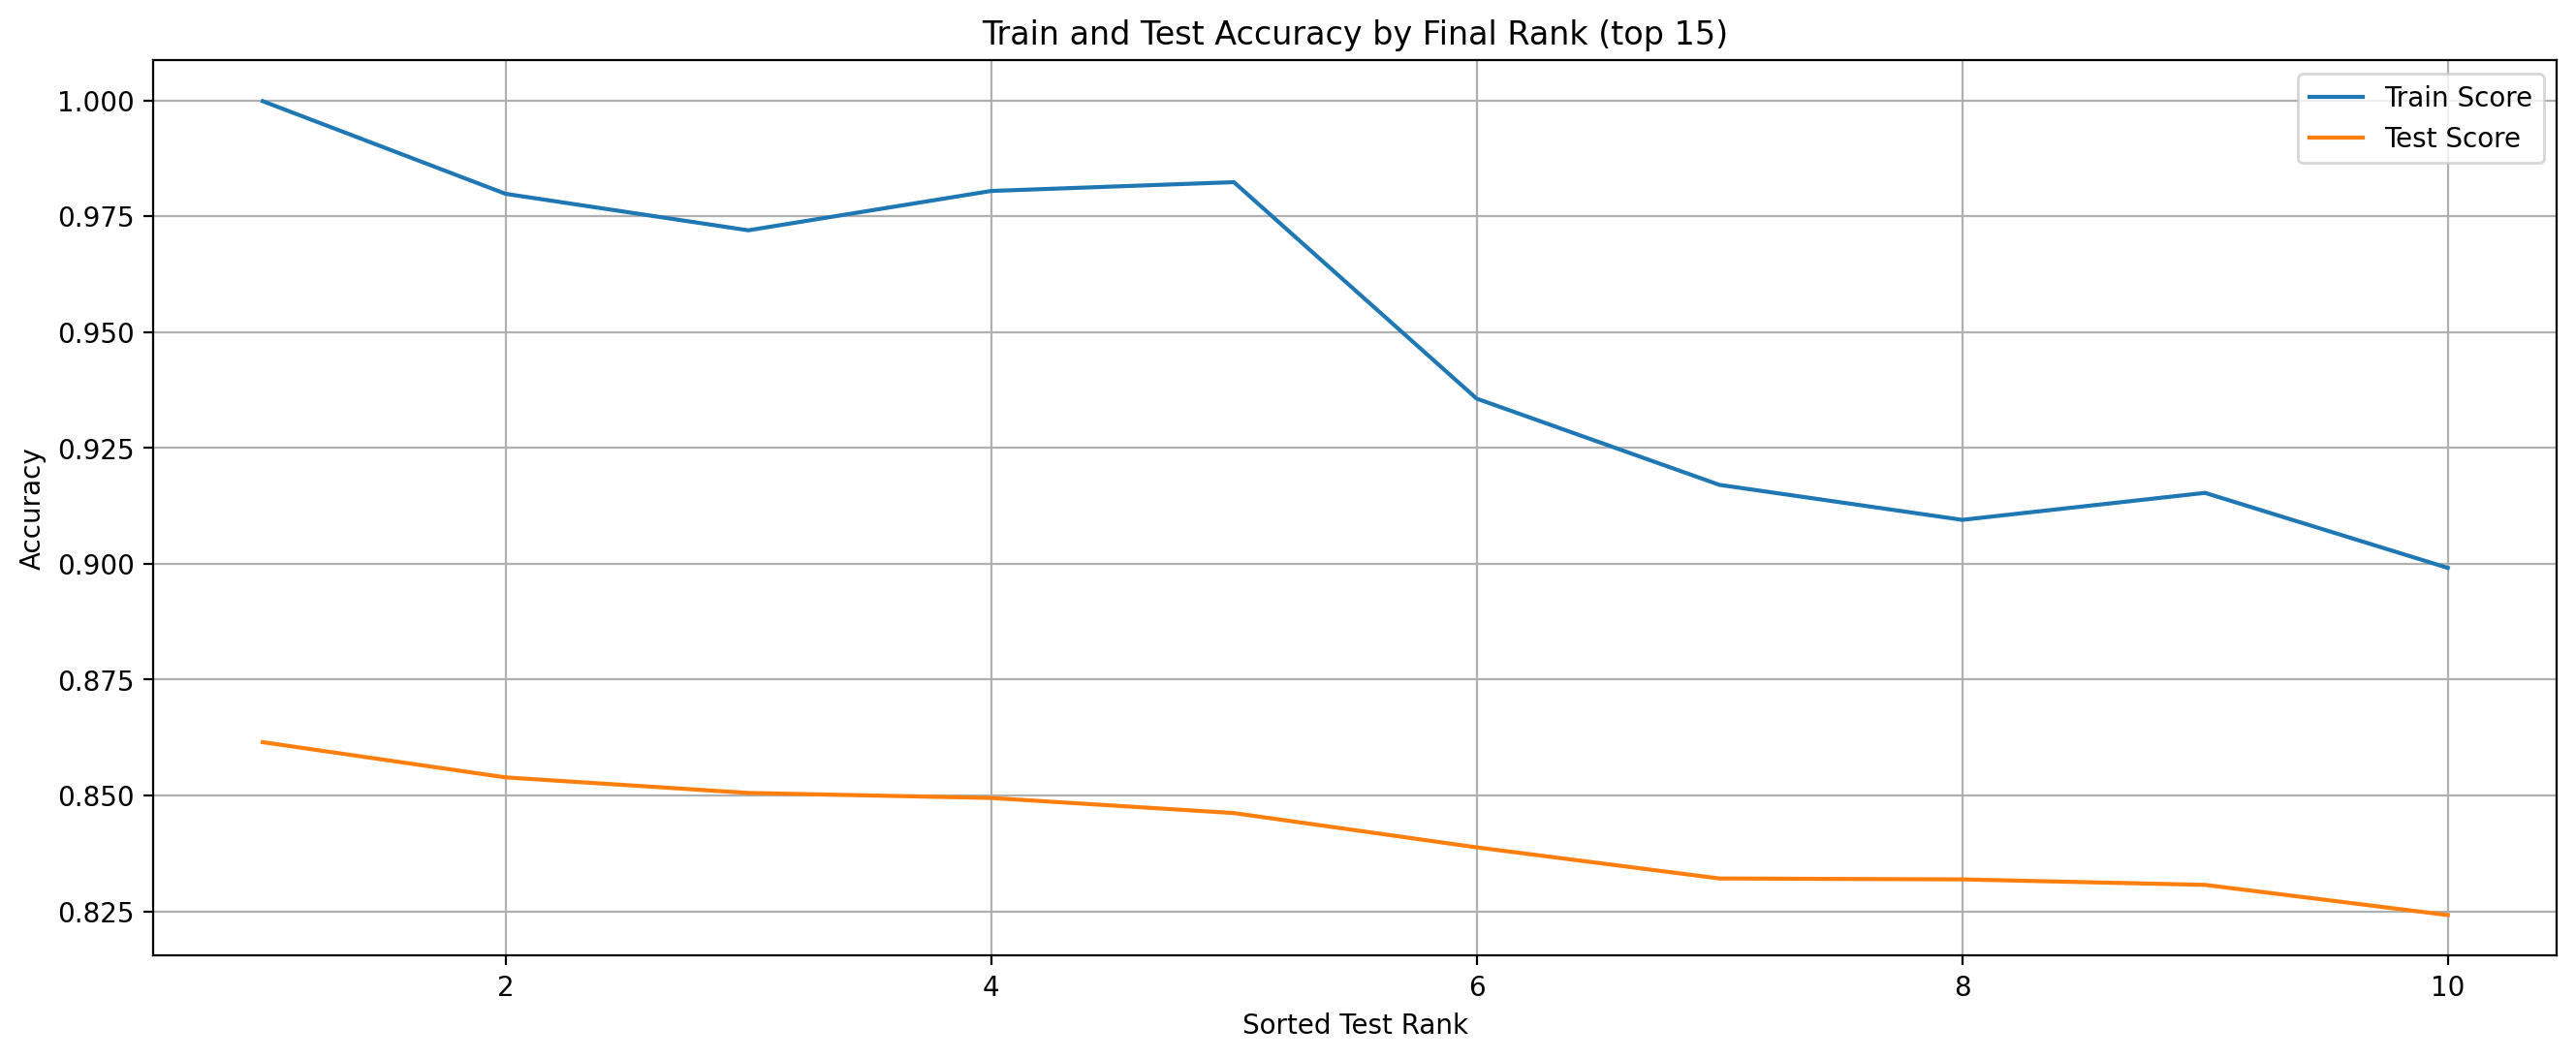

In [10]:
plt.figure(figsize=(16, 6))    

plt.plot(sorted_cv['rank_test_score'], sorted_cv['mean_train_score'], label="Train Score")
plt.plot(sorted_cv['rank_test_score'], sorted_cv['mean_test_score'], label="Test Score")

plt.grid()
plt.xlabel('Sorted Test Rank')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy by Final Rank (top 15)')
plt.legend(loc='best')

filename = "test_train_by_rank.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

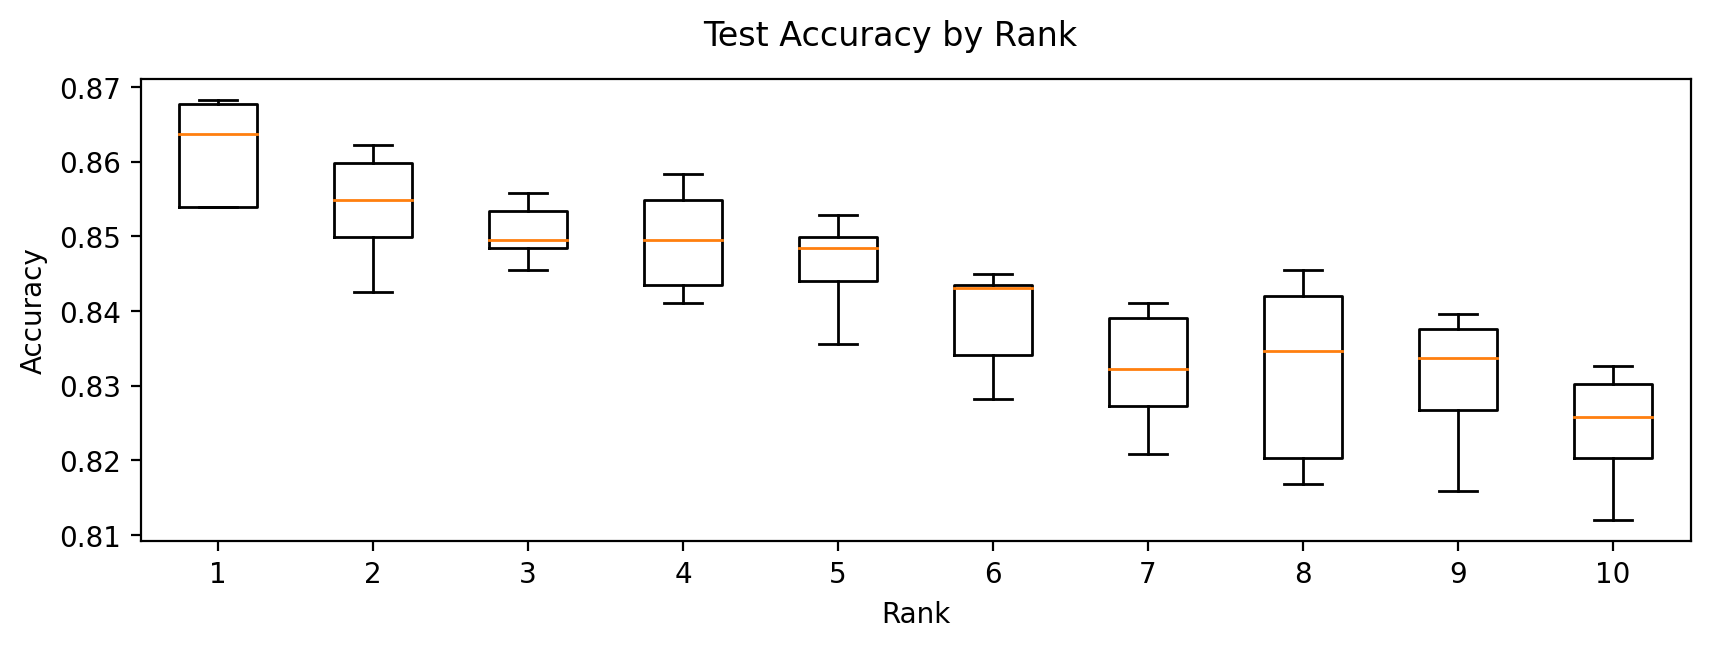

In [11]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10, 3))
fig.suptitle('Test Accuracy by Rank')

ax = fig.add_subplot(111)

plt.boxplot(sorted_cv.iloc[:10, :][['split0_test_score', 'split1_test_score', 'split2_test_score',
   'split3_test_score', 'split4_test_score']].T)
ax.set_xticklabels(range(1, 11))
ax.set_xlabel("Rank")
ax.set_ylabel("Accuracy")

filename = "test_accuracy_by_rank.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

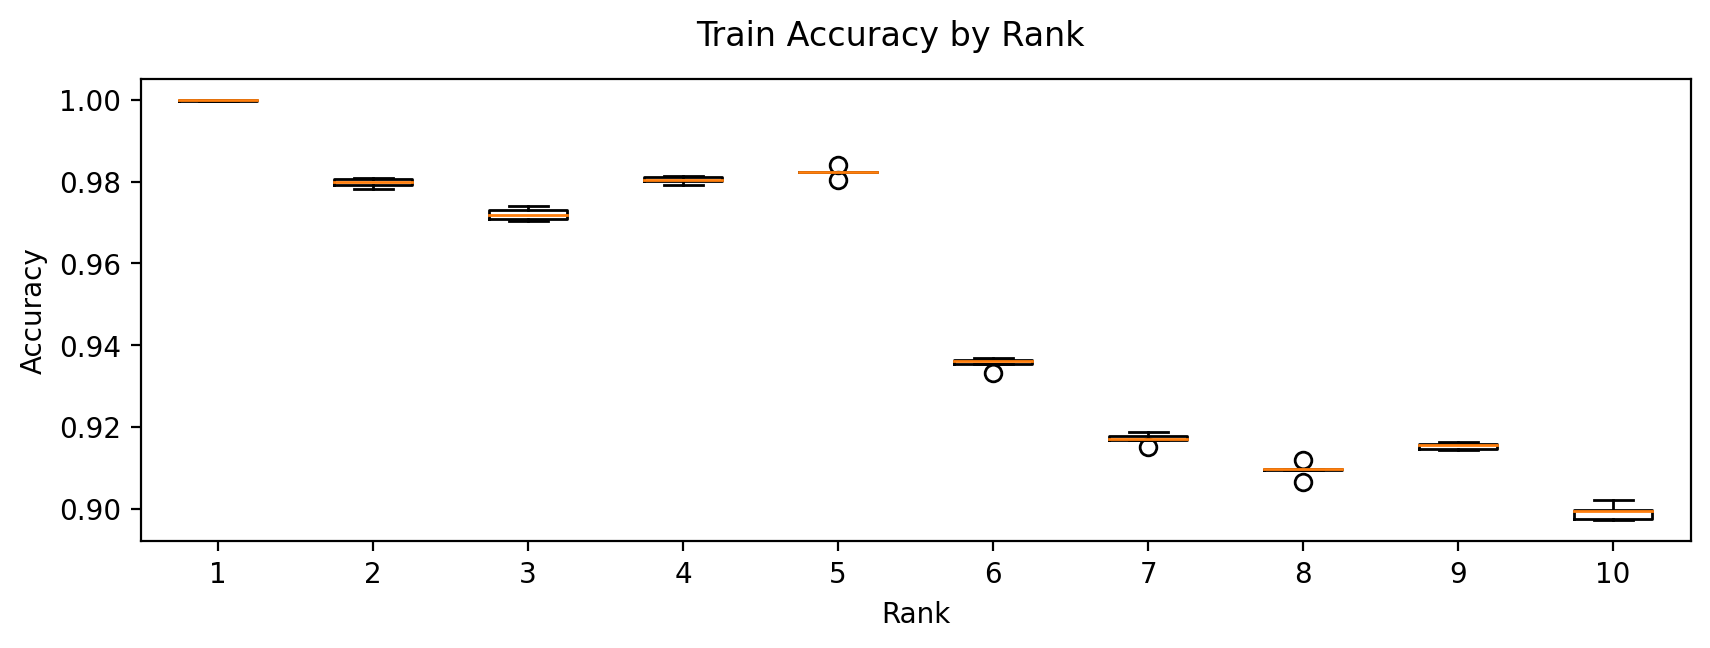

In [12]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10, 3))
fig.suptitle('Train Accuracy by Rank')

ax = fig.add_subplot(111)

plt.boxplot(sorted_cv.iloc[:10, :][['split0_train_score', 'split1_train_score', 'split2_train_score',
   'split3_train_score', 'split4_train_score']].T)
ax.set_xticklabels(range(1, 11))
ax.set_xlabel("Rank")
ax.set_ylabel("Accuracy")

filename = "train_accuracy_by_rank.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

In [13]:
max_params = cv_results.loc[cv_results['rank_test_score'] == 1]
best_params = max_params.params.values[0]

In [14]:
print(f"Mean Train set, Accuracy = {max_params['mean_train_score'].values[0]:.2f}")
print(f"Mean Test  set, Accuracy = {max_params['mean_test_score'].values[0]:.2f}")

Mean Train set, Accuracy = 1.00
Mean Test  set, Accuracy = 0.86


In [37]:
random_search = pickle.load(open(os.path.join(results_path, file_name), "rb"))
model = random_search.best_estimator_

#model = XGBClassifier(**best_params)
#model.fit(X_train, y_train)

y_train_prediction = model.predict(X_train)
y_test_prediction = model.predict(X_test)

FileNotFoundError: [Errno 2] No such file or directory: './tuning_results/tuning_xgb/202402271214/Assets/xgb_202402271214.pkl'

In [19]:
print(f"Train set, Accuracy = {accuracy_score(y_train, y_train_prediction):.2f}")
print(f"Test set, Accuracy = {accuracy_score(y_test, y_test_prediction):.2f}")

Train set, Accuracy = 1.00
Test set, Accuracy = 0.88


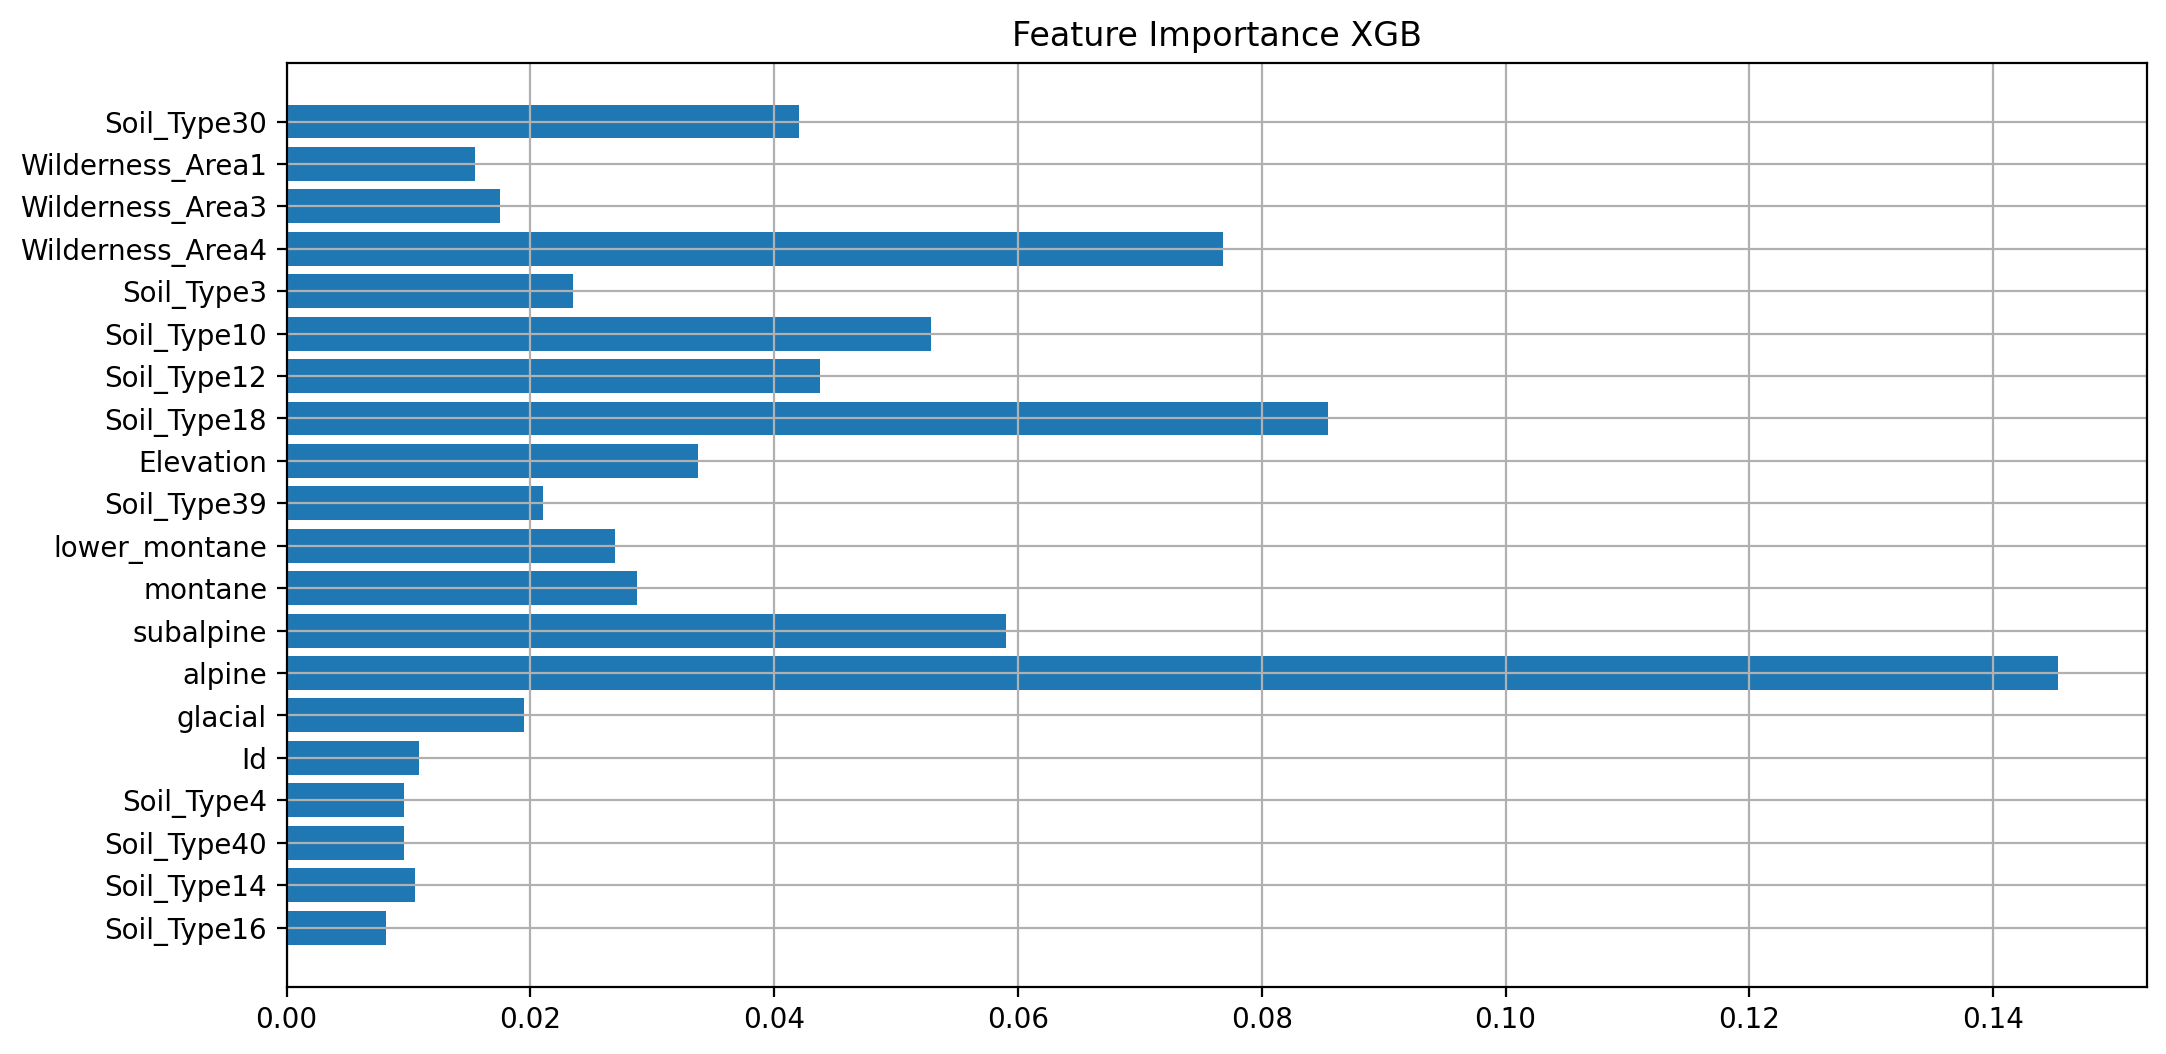

In [20]:
ind = np.argpartition(model.feature_importances_, -20)[-20:]

features = X.columns[ind]
importance = model.feature_importances_[ind]

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(ind)), importance, align='center')
plt.yticks(range(len(ind)), features)
plt.title('Feature Importance XGB')
plt.grid()

filename = "feature_importance.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()

In the context of XGBoost, these scores are often computed based on the following:

- Weight: The number of times a feature appears in a tree across the ensemble of trees.
- Gain: The average gain of a feature when it is used in trees.
- Cover: The average coverage of a feature when it is used in trees.

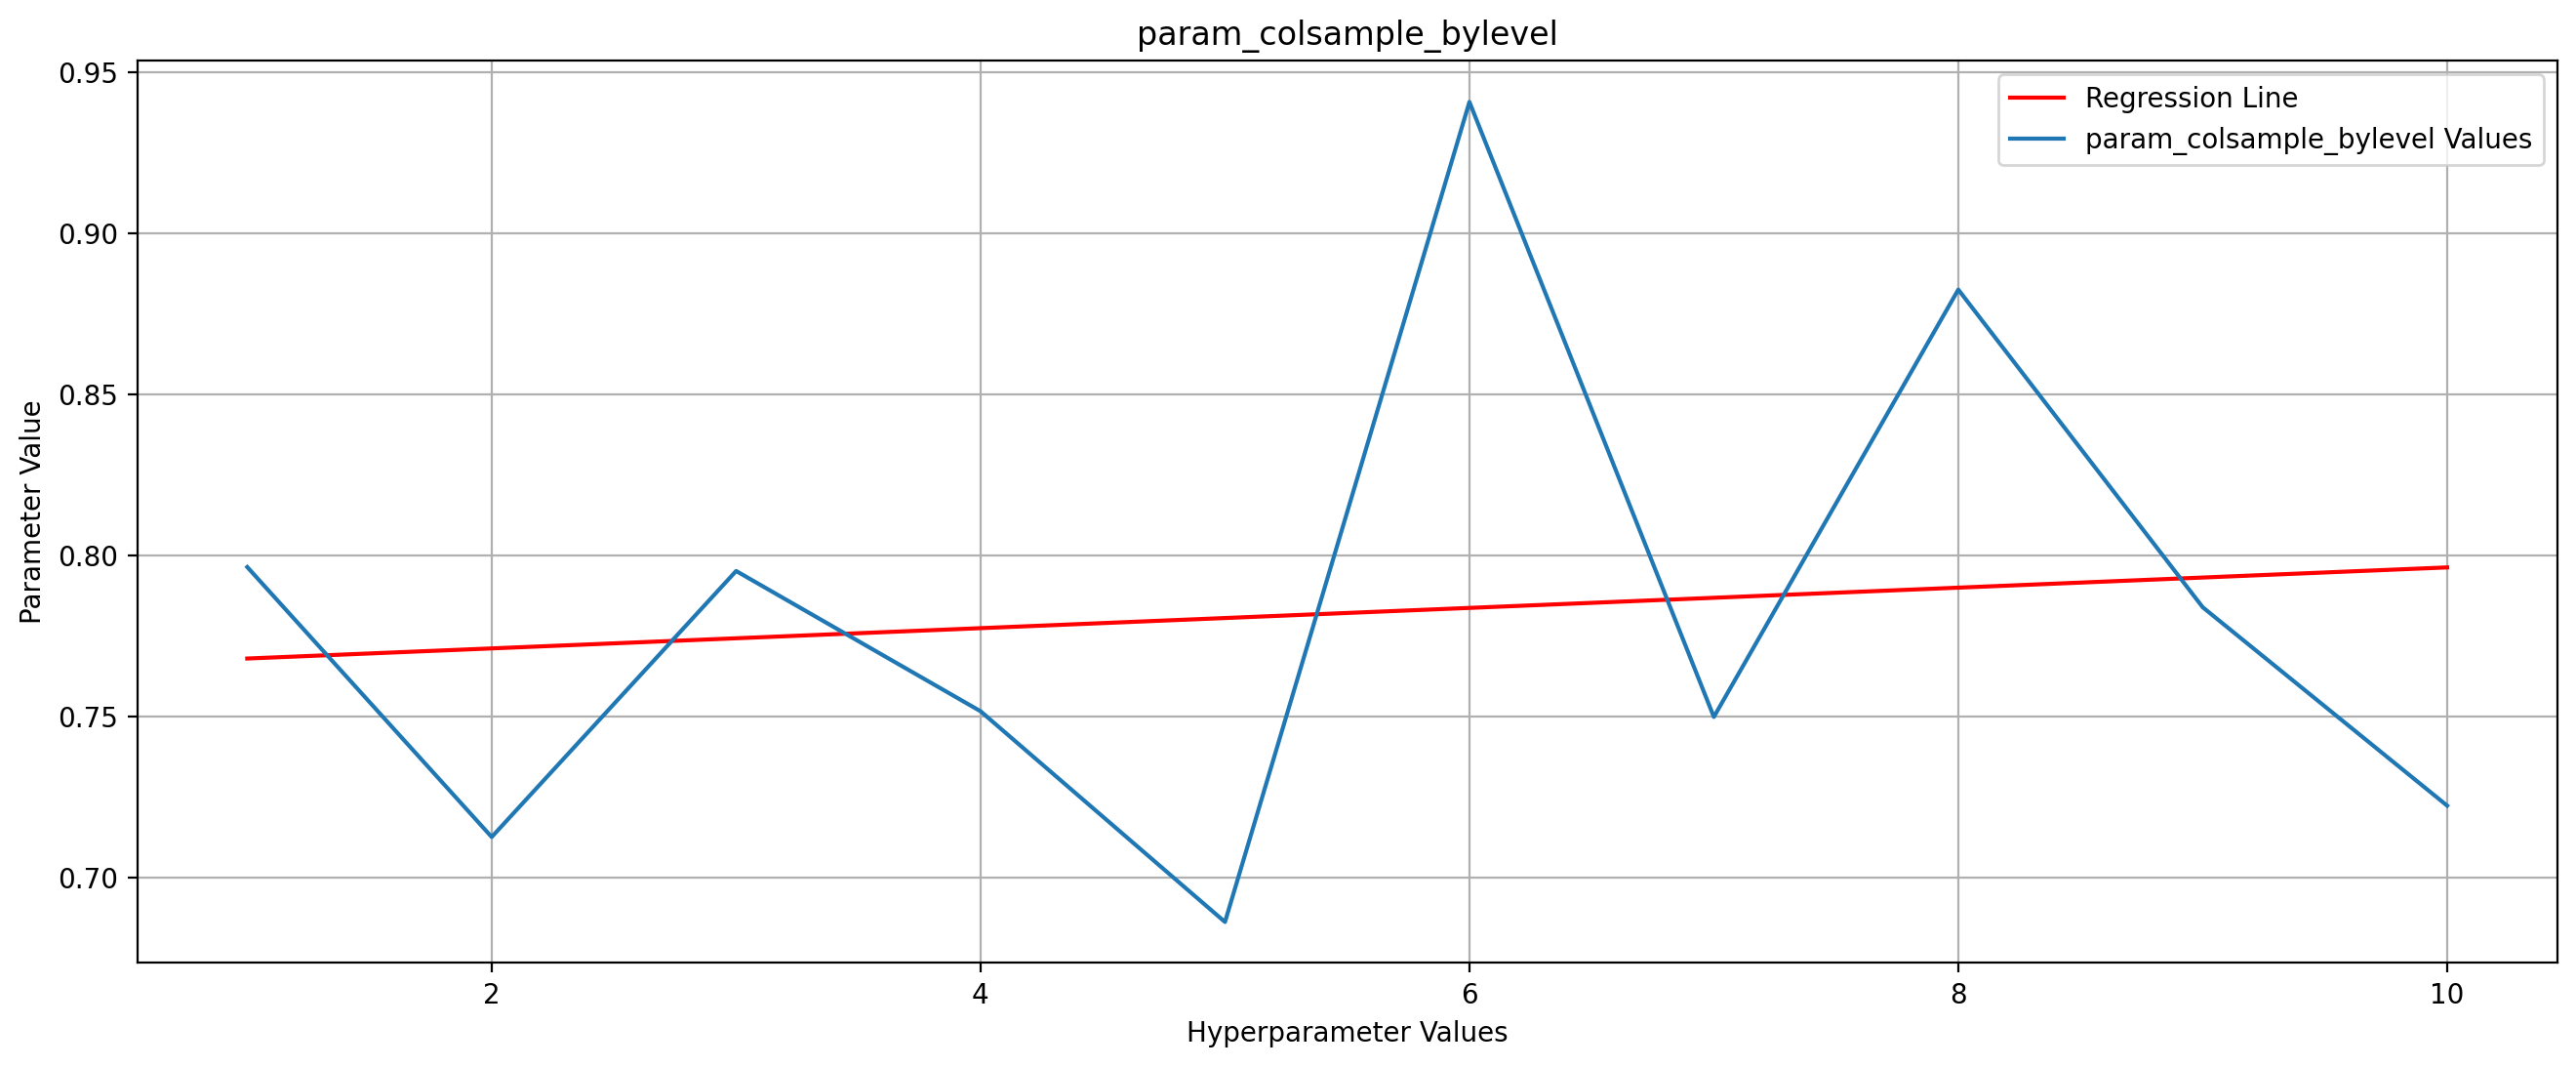

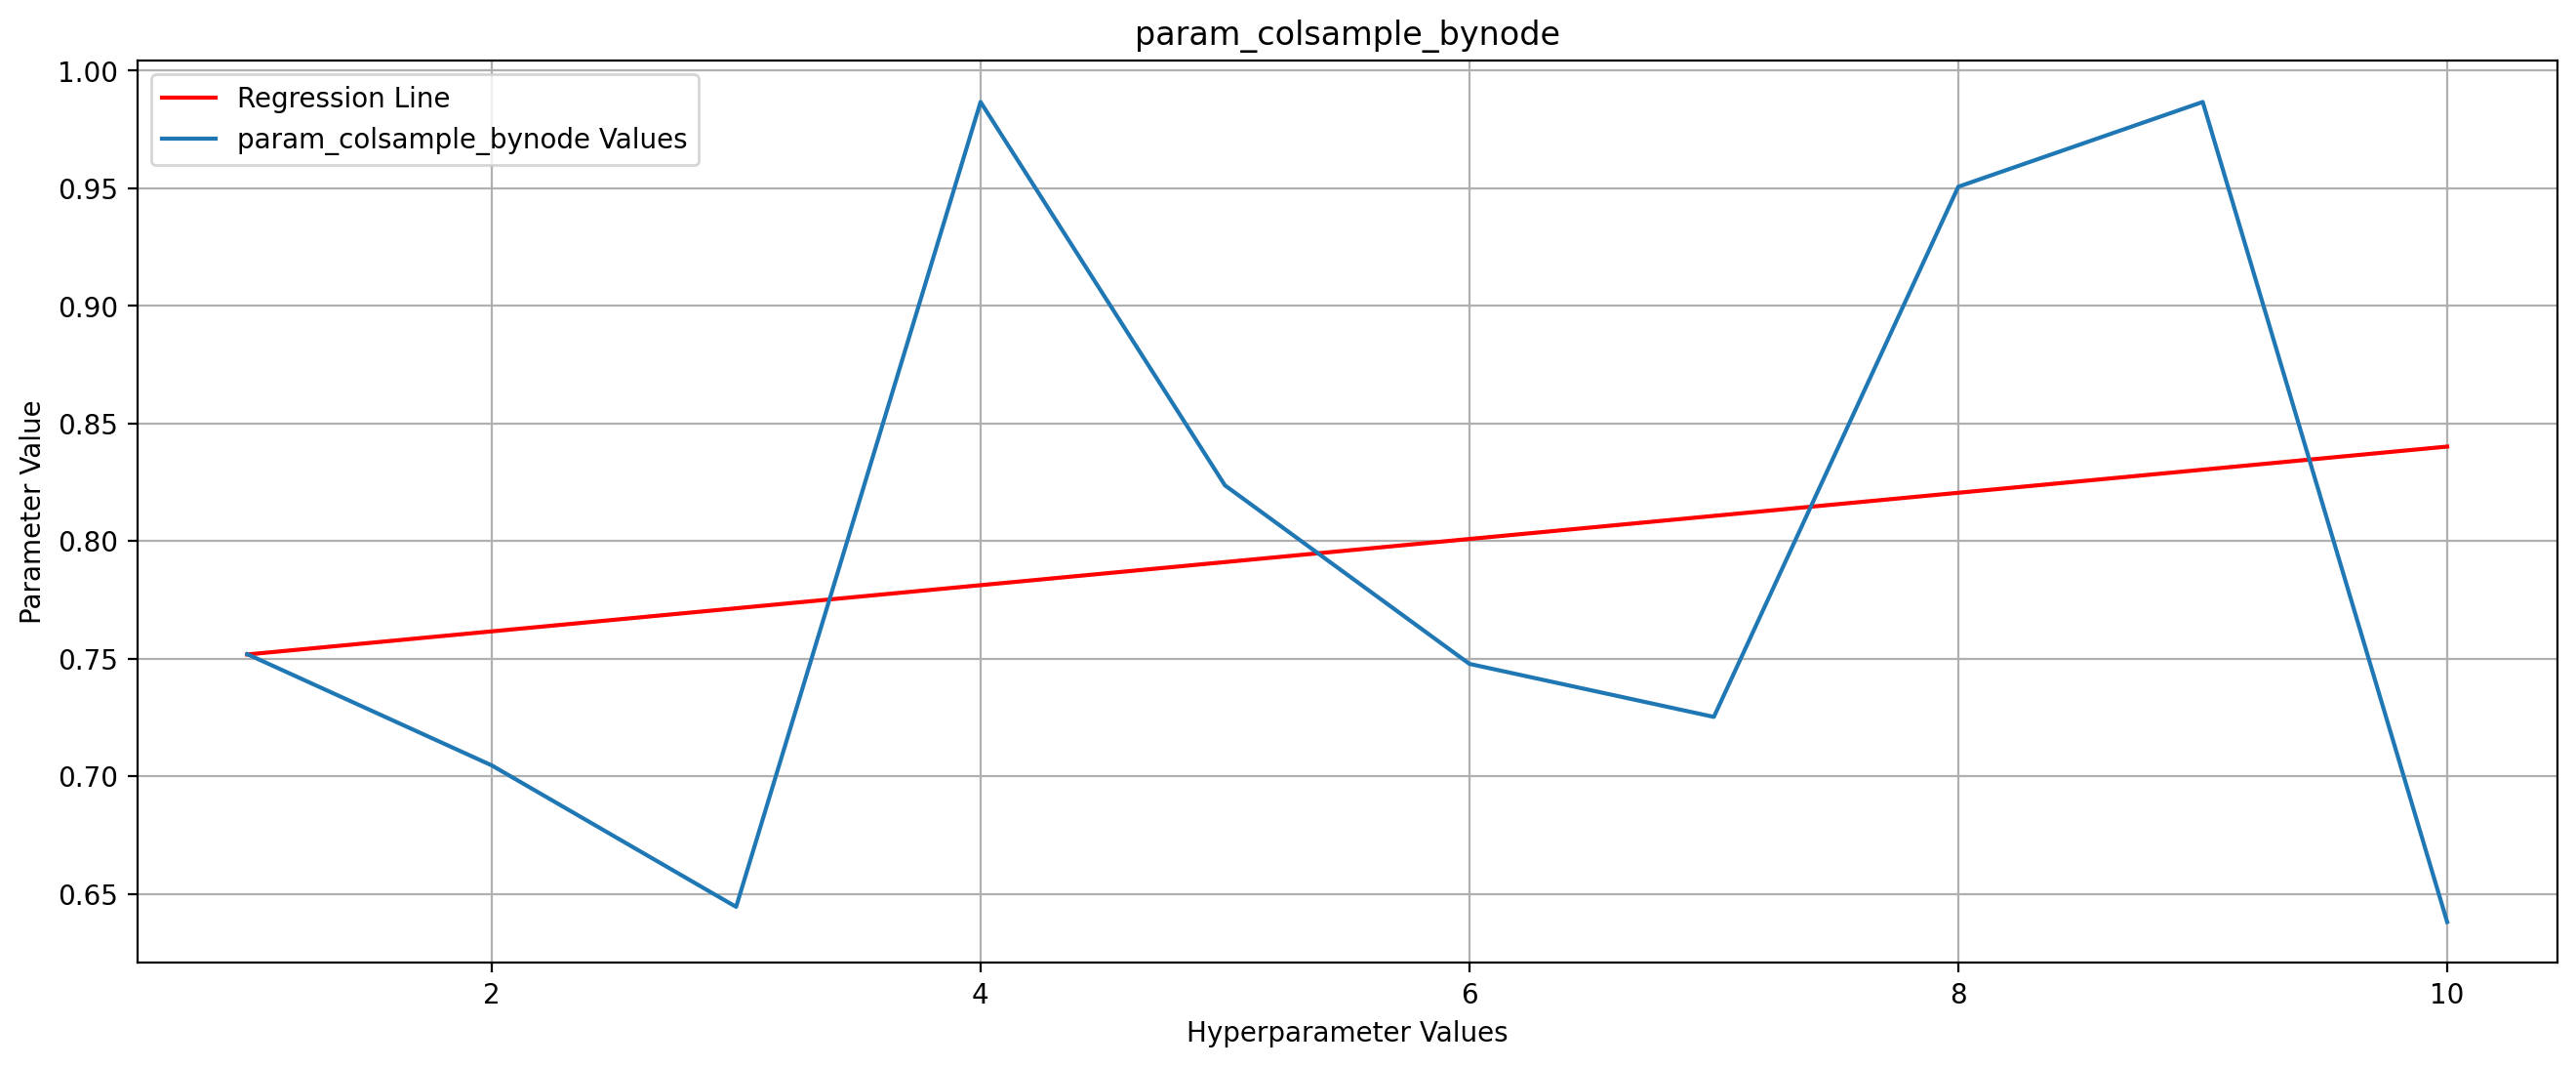

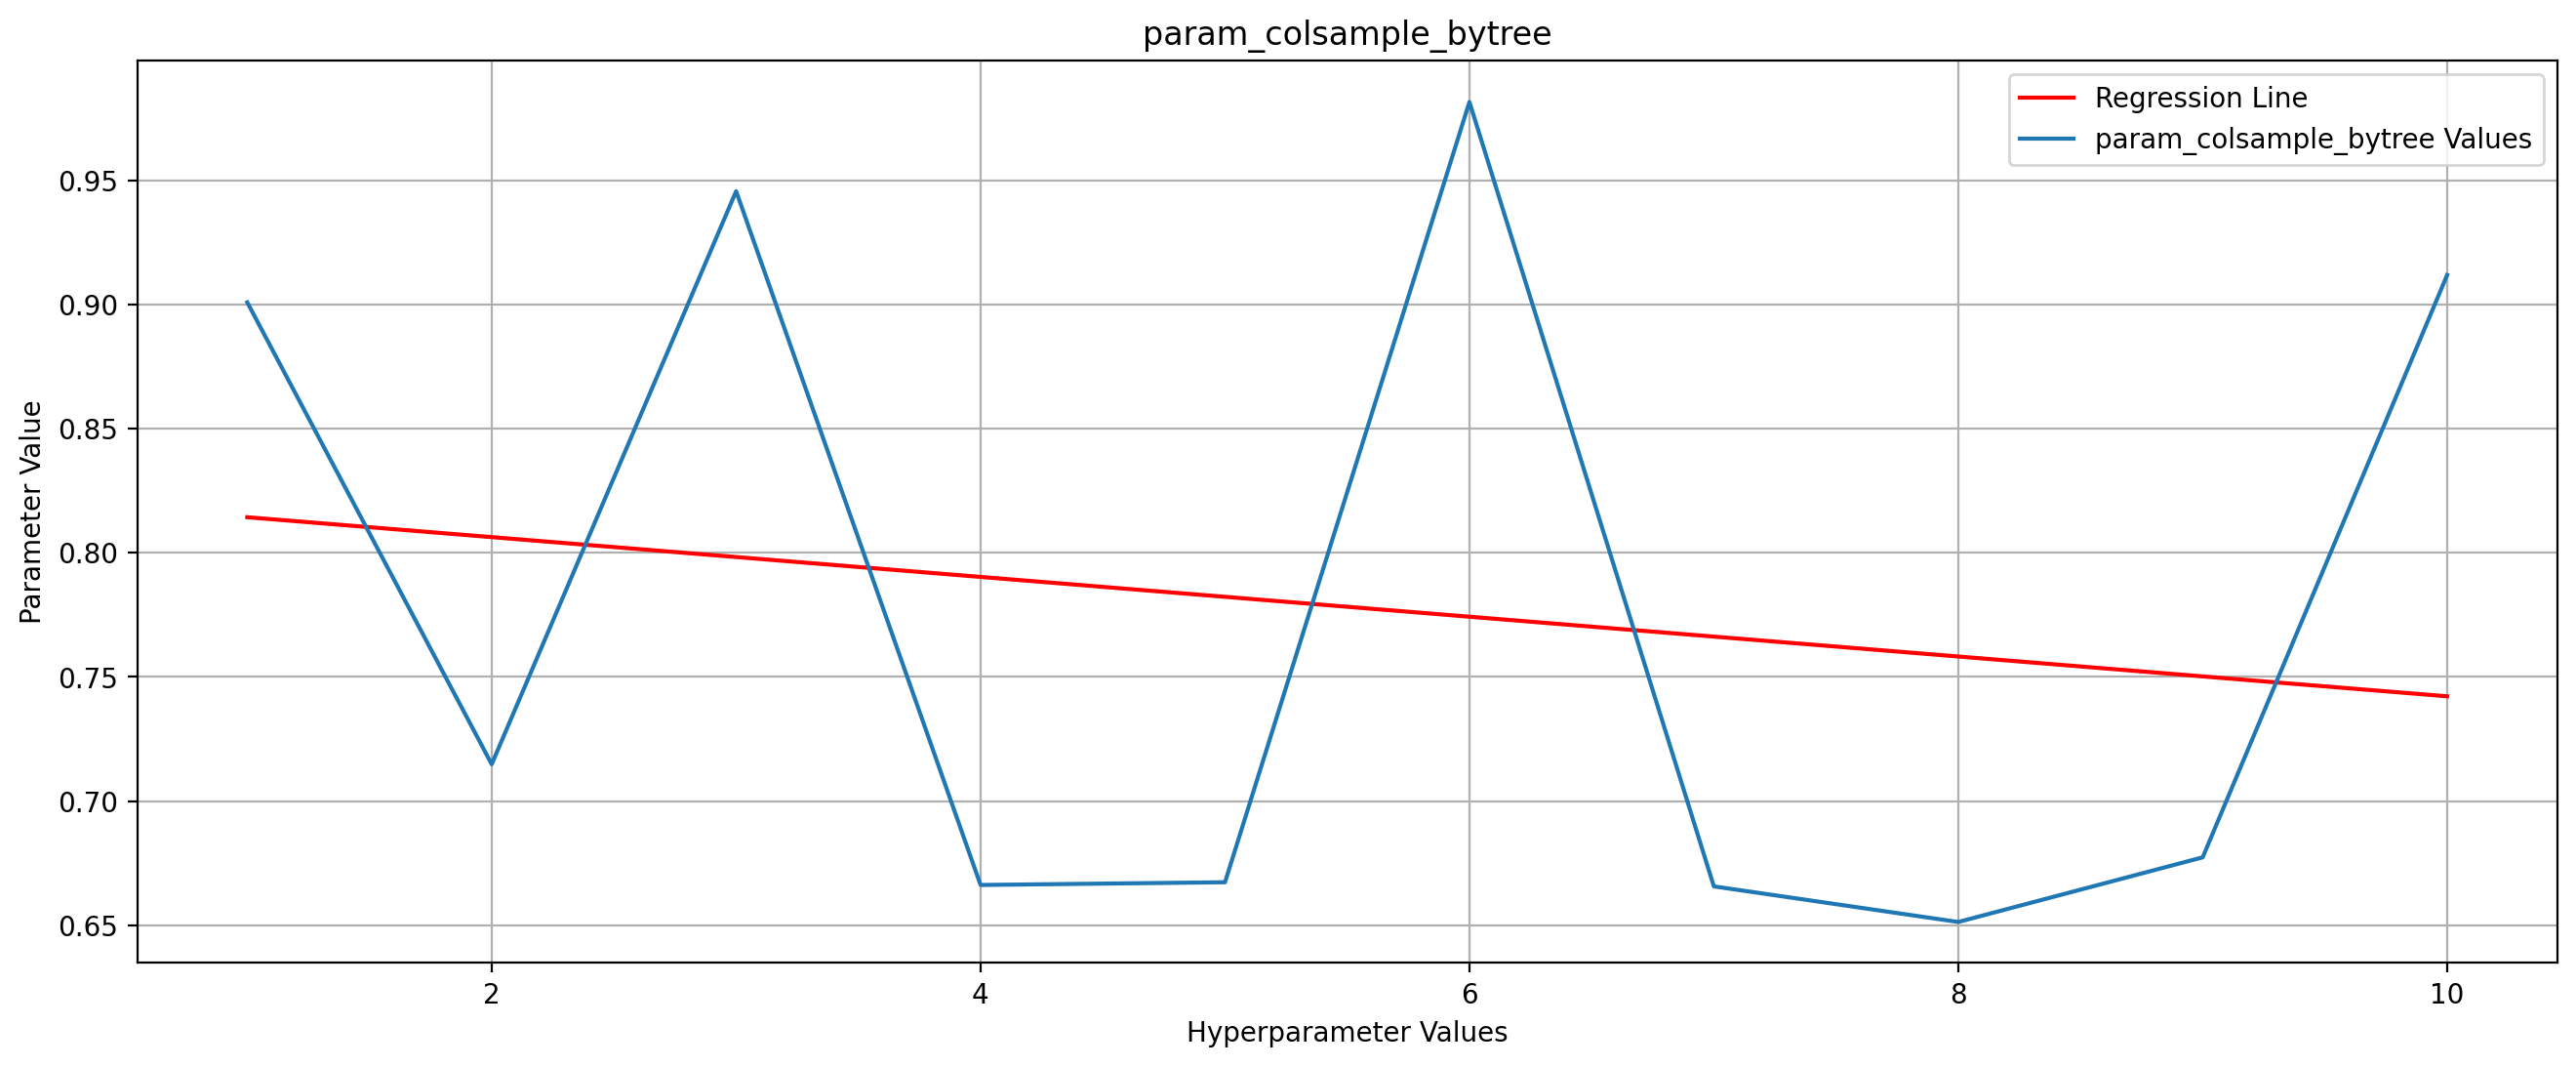

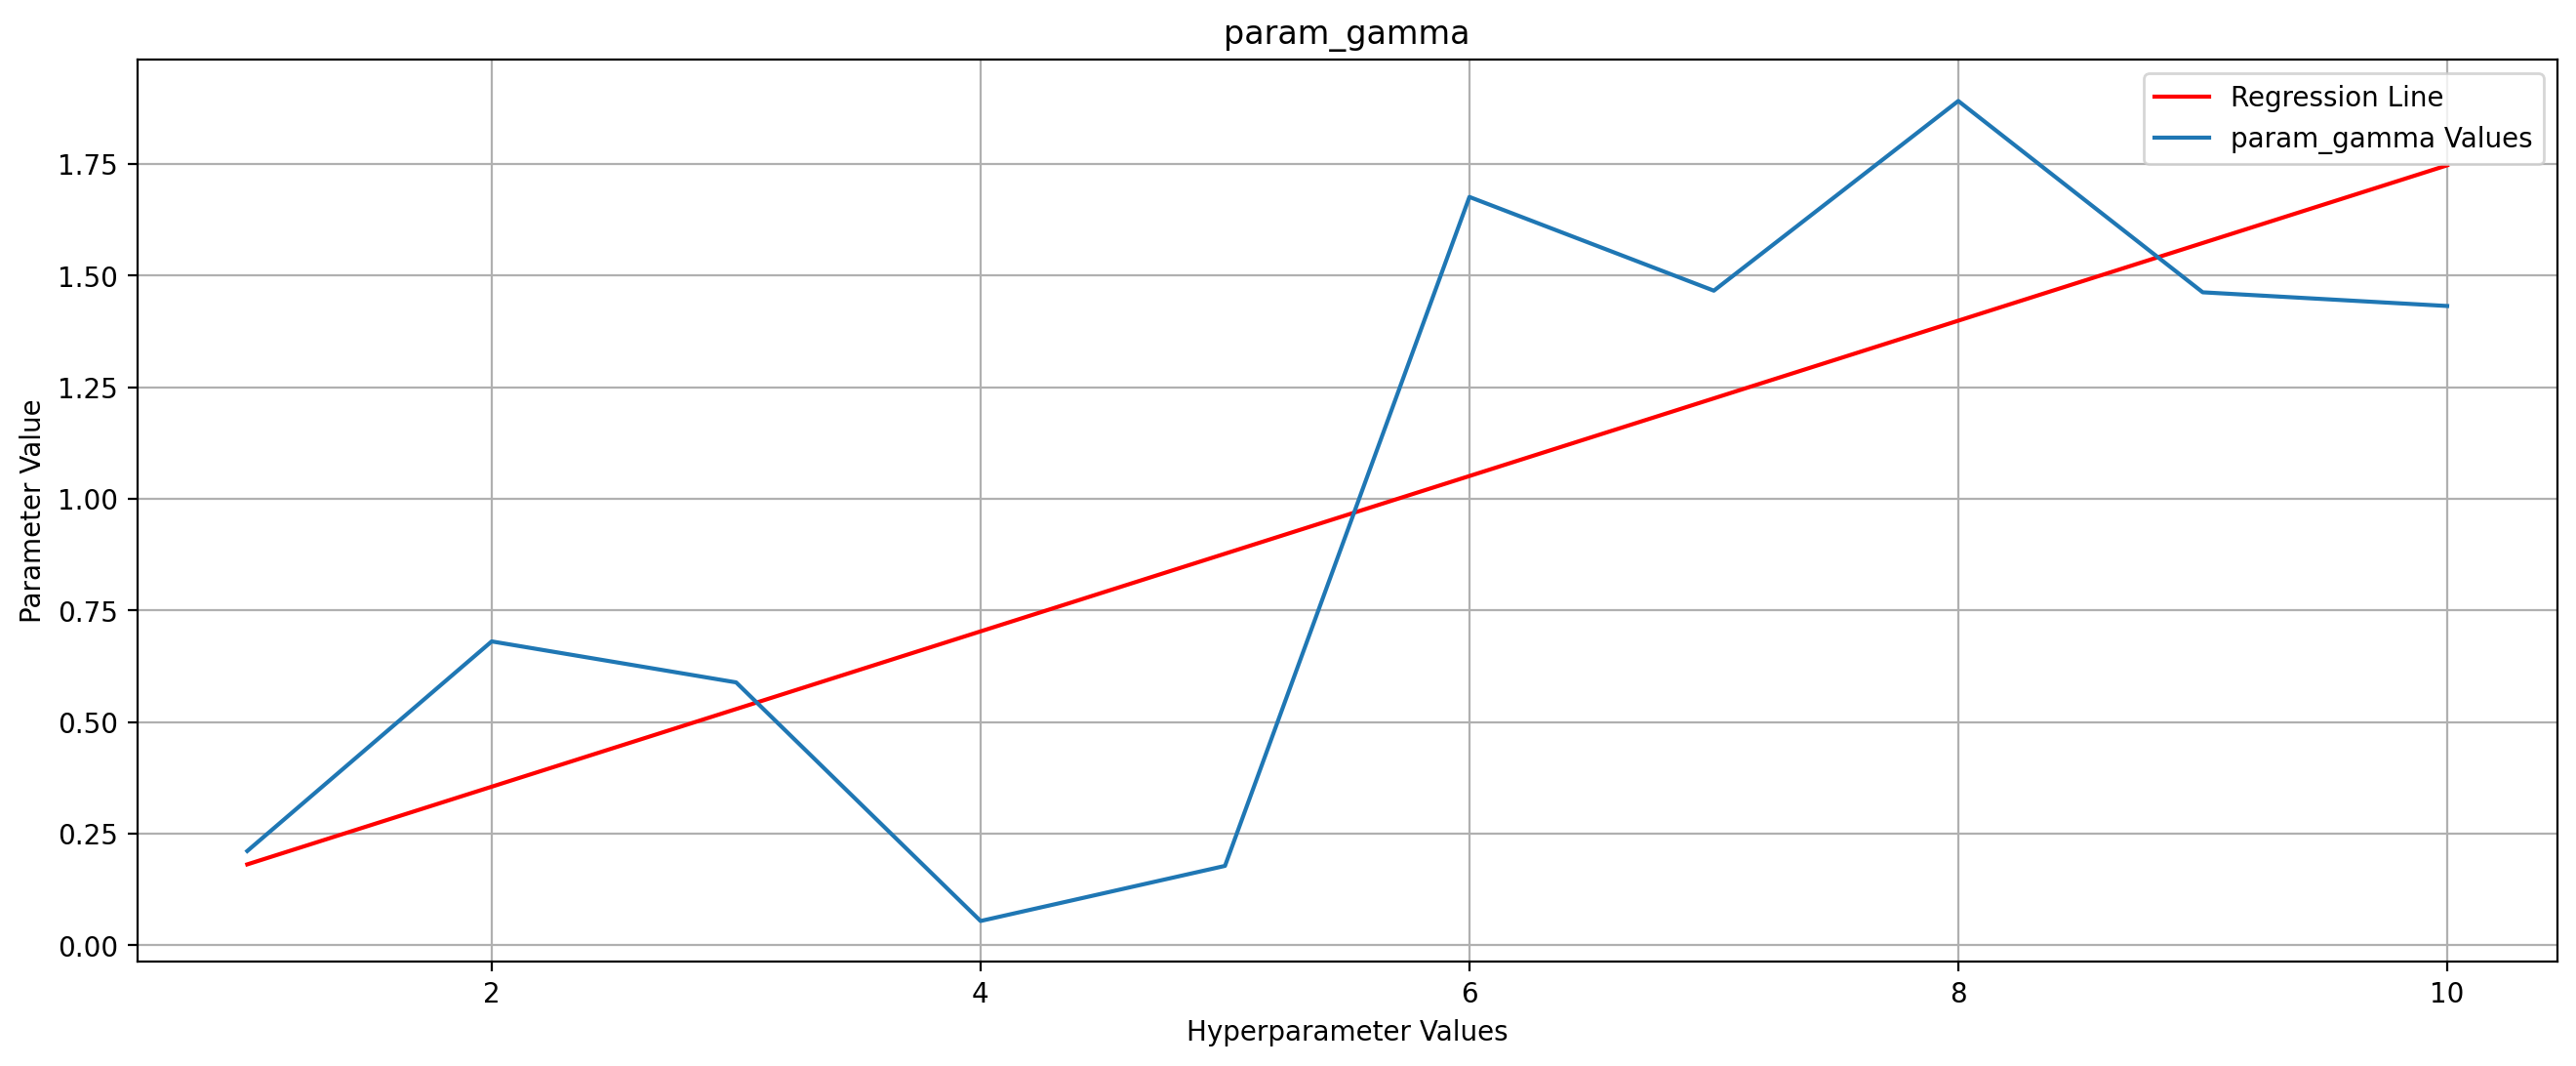

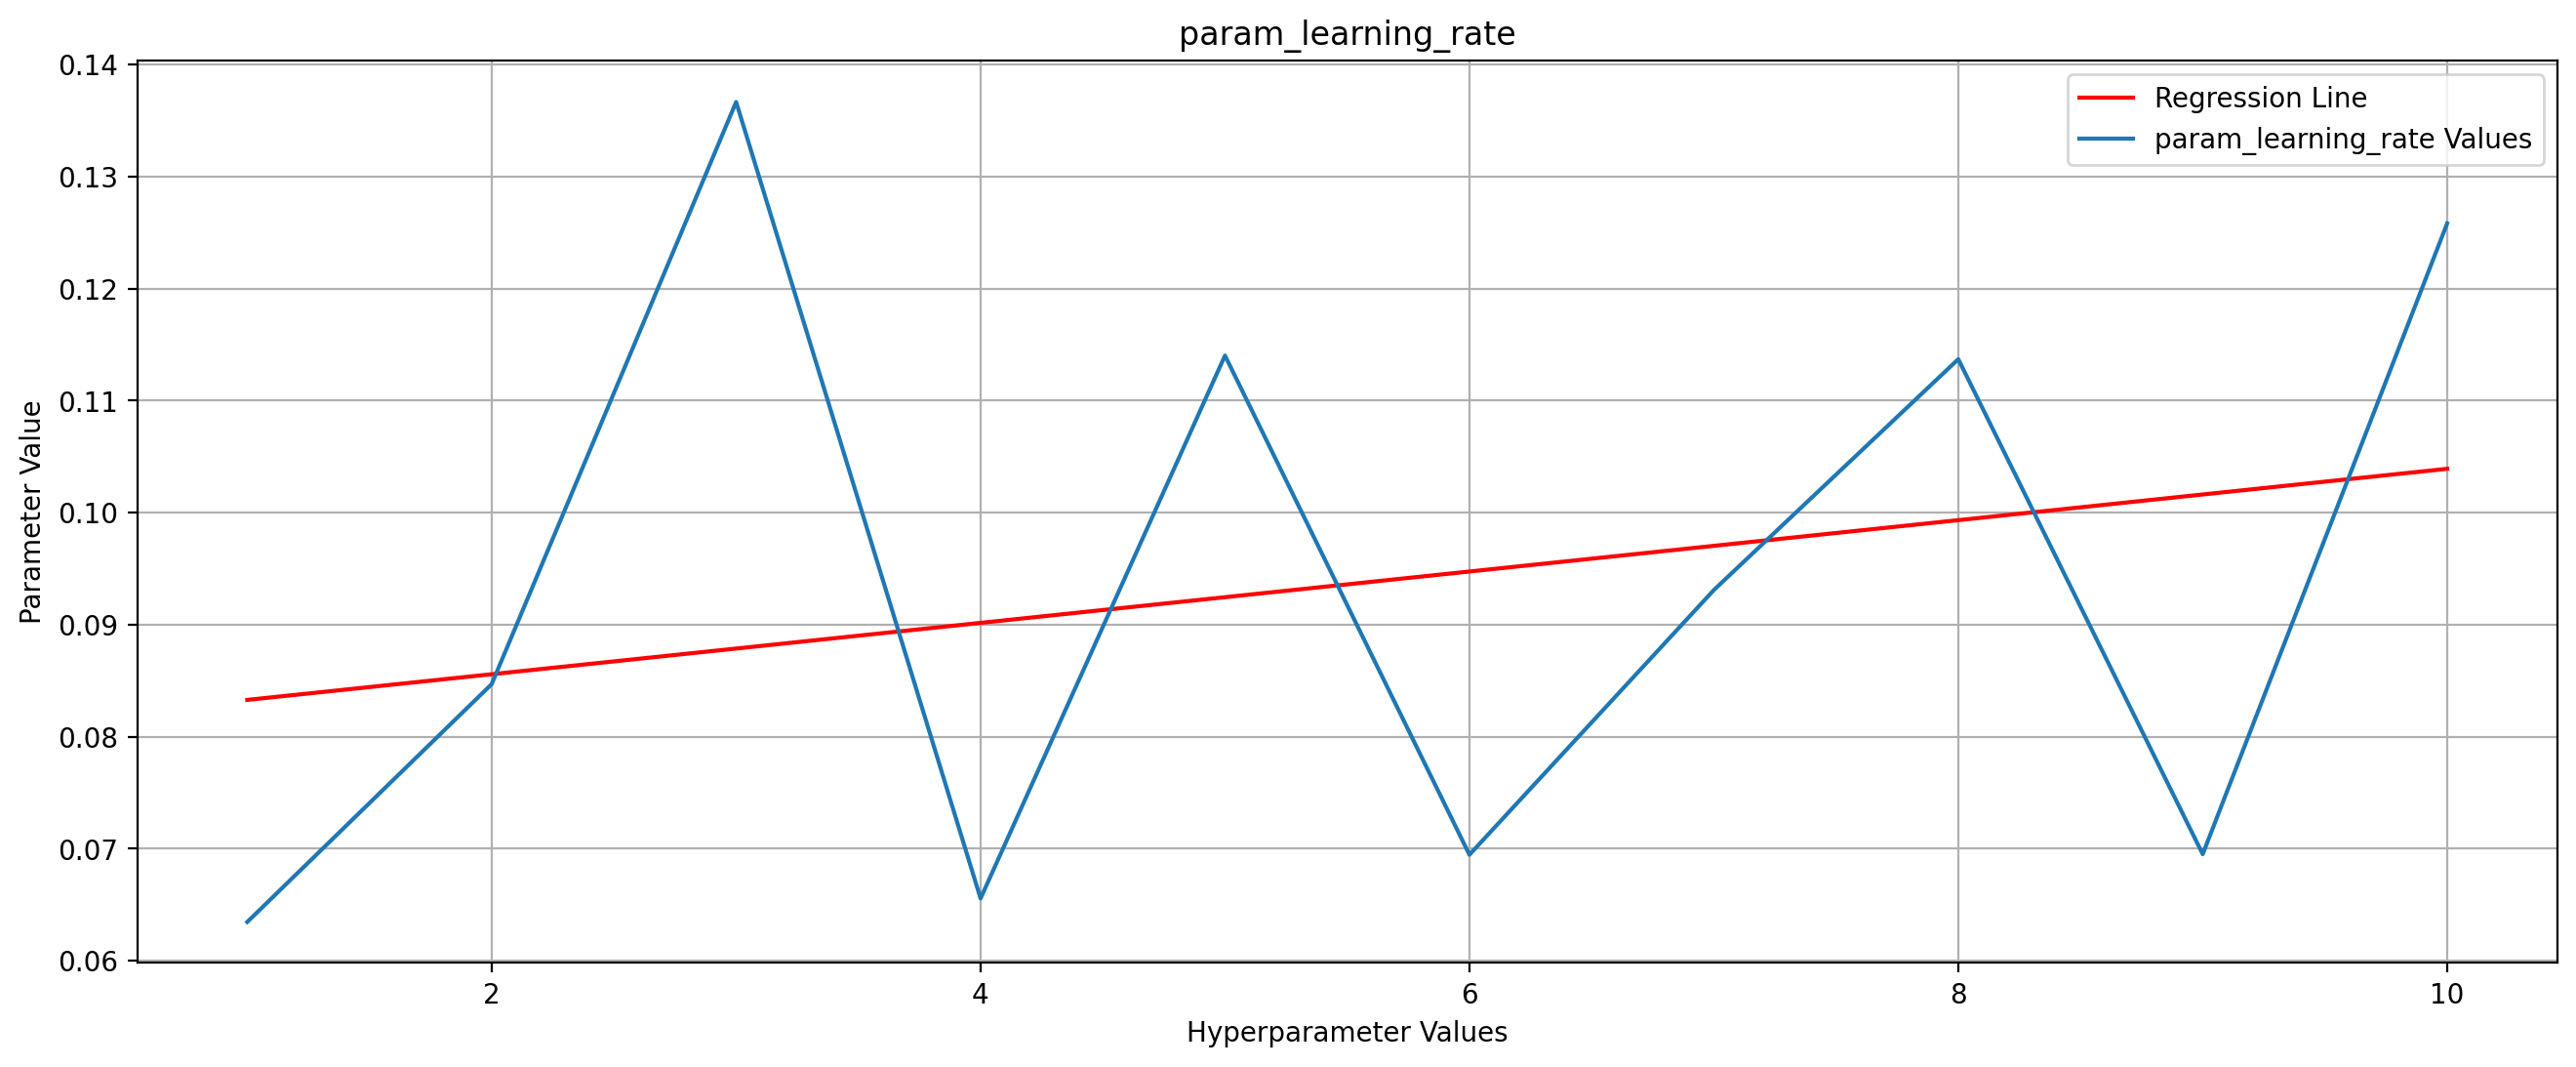

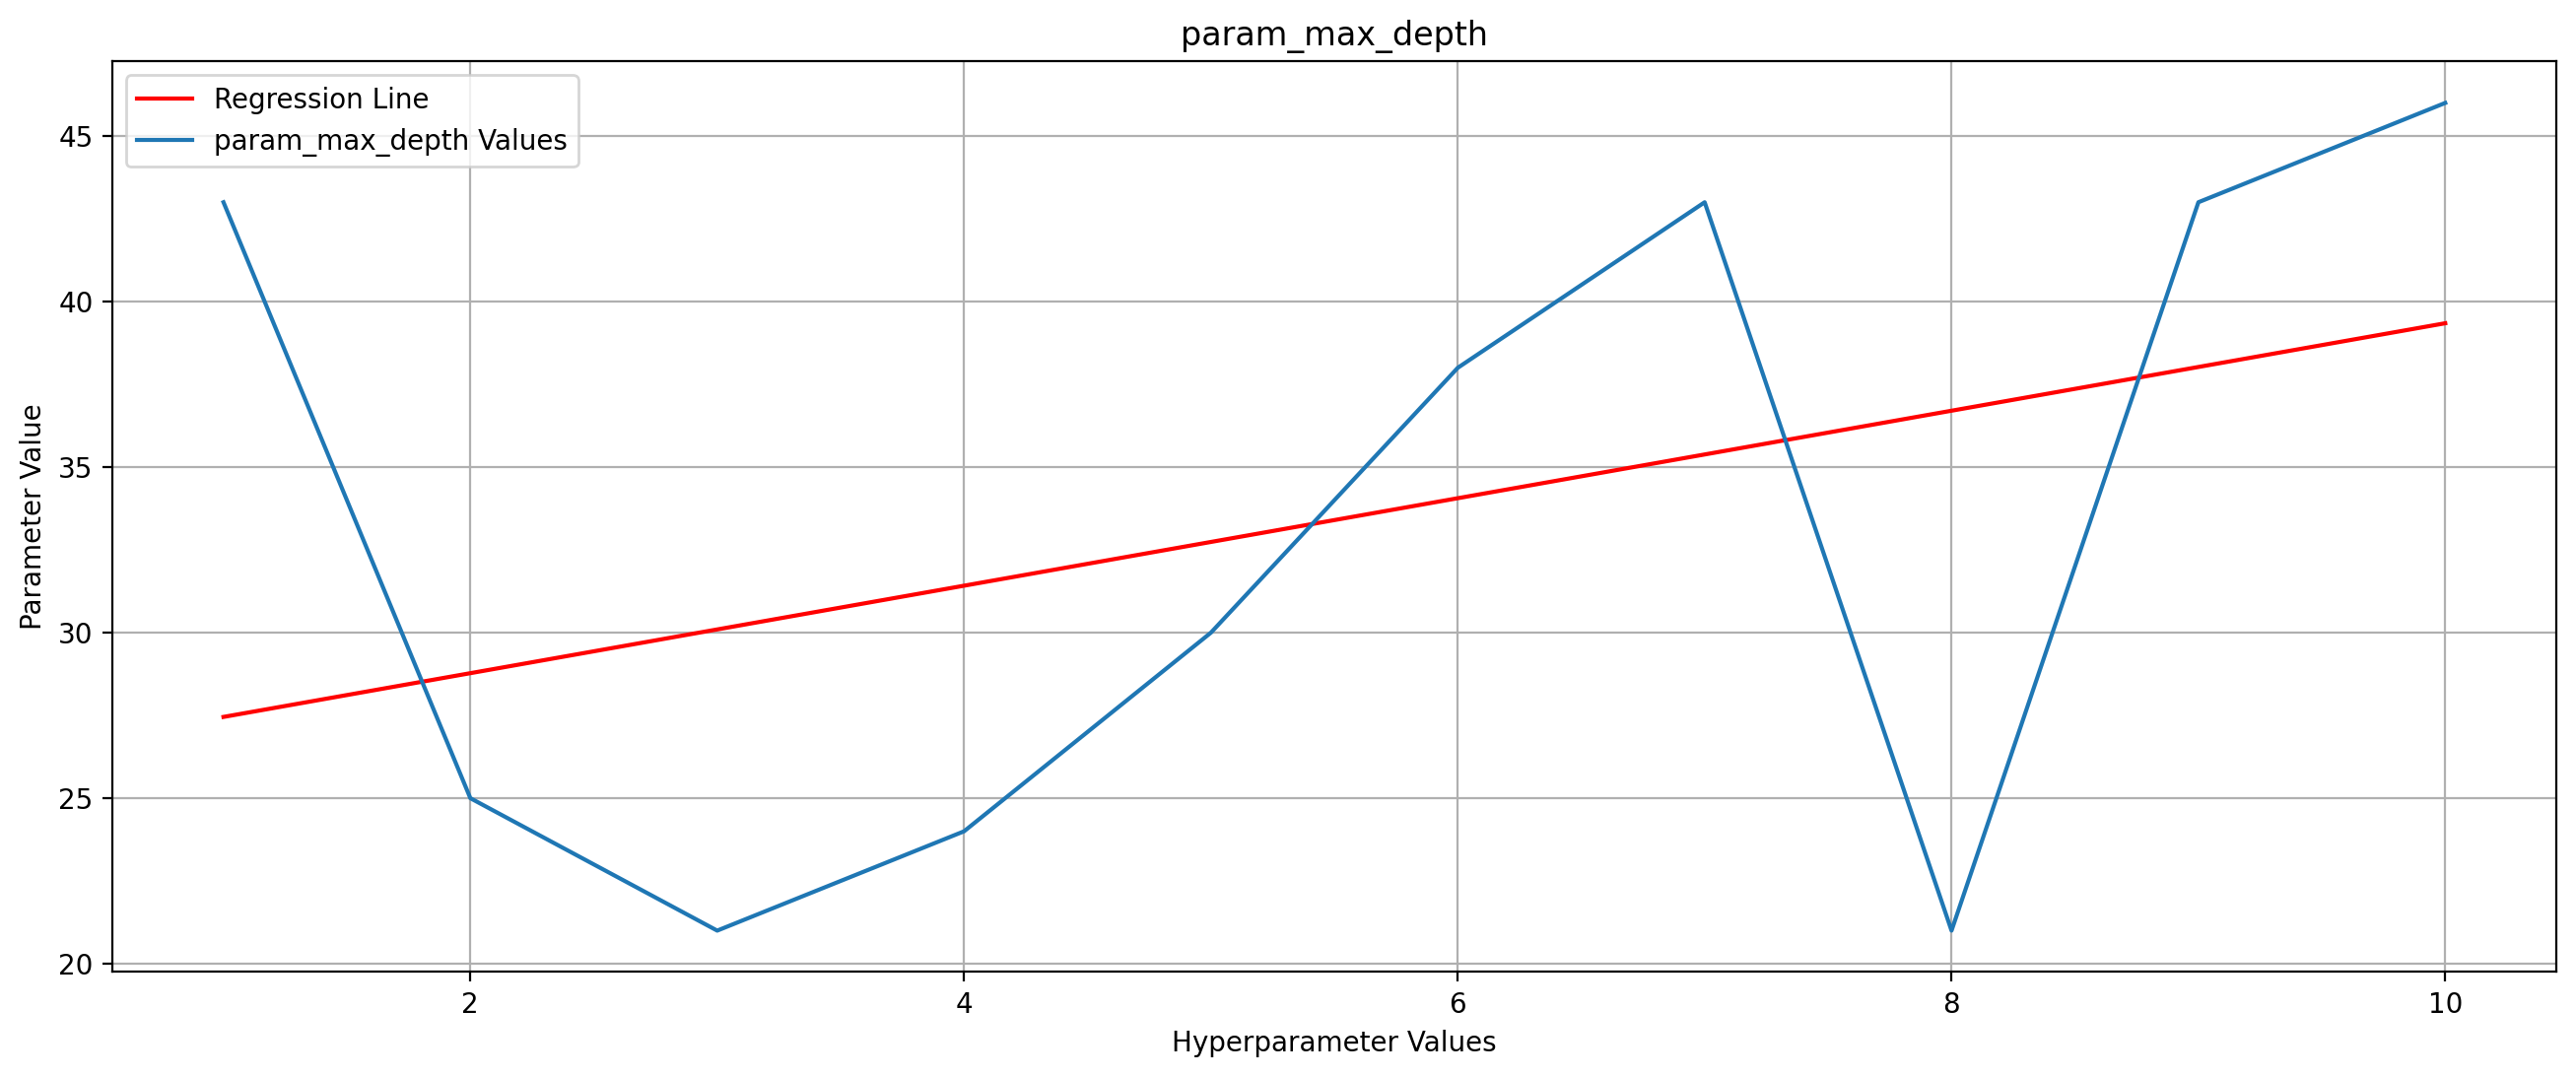

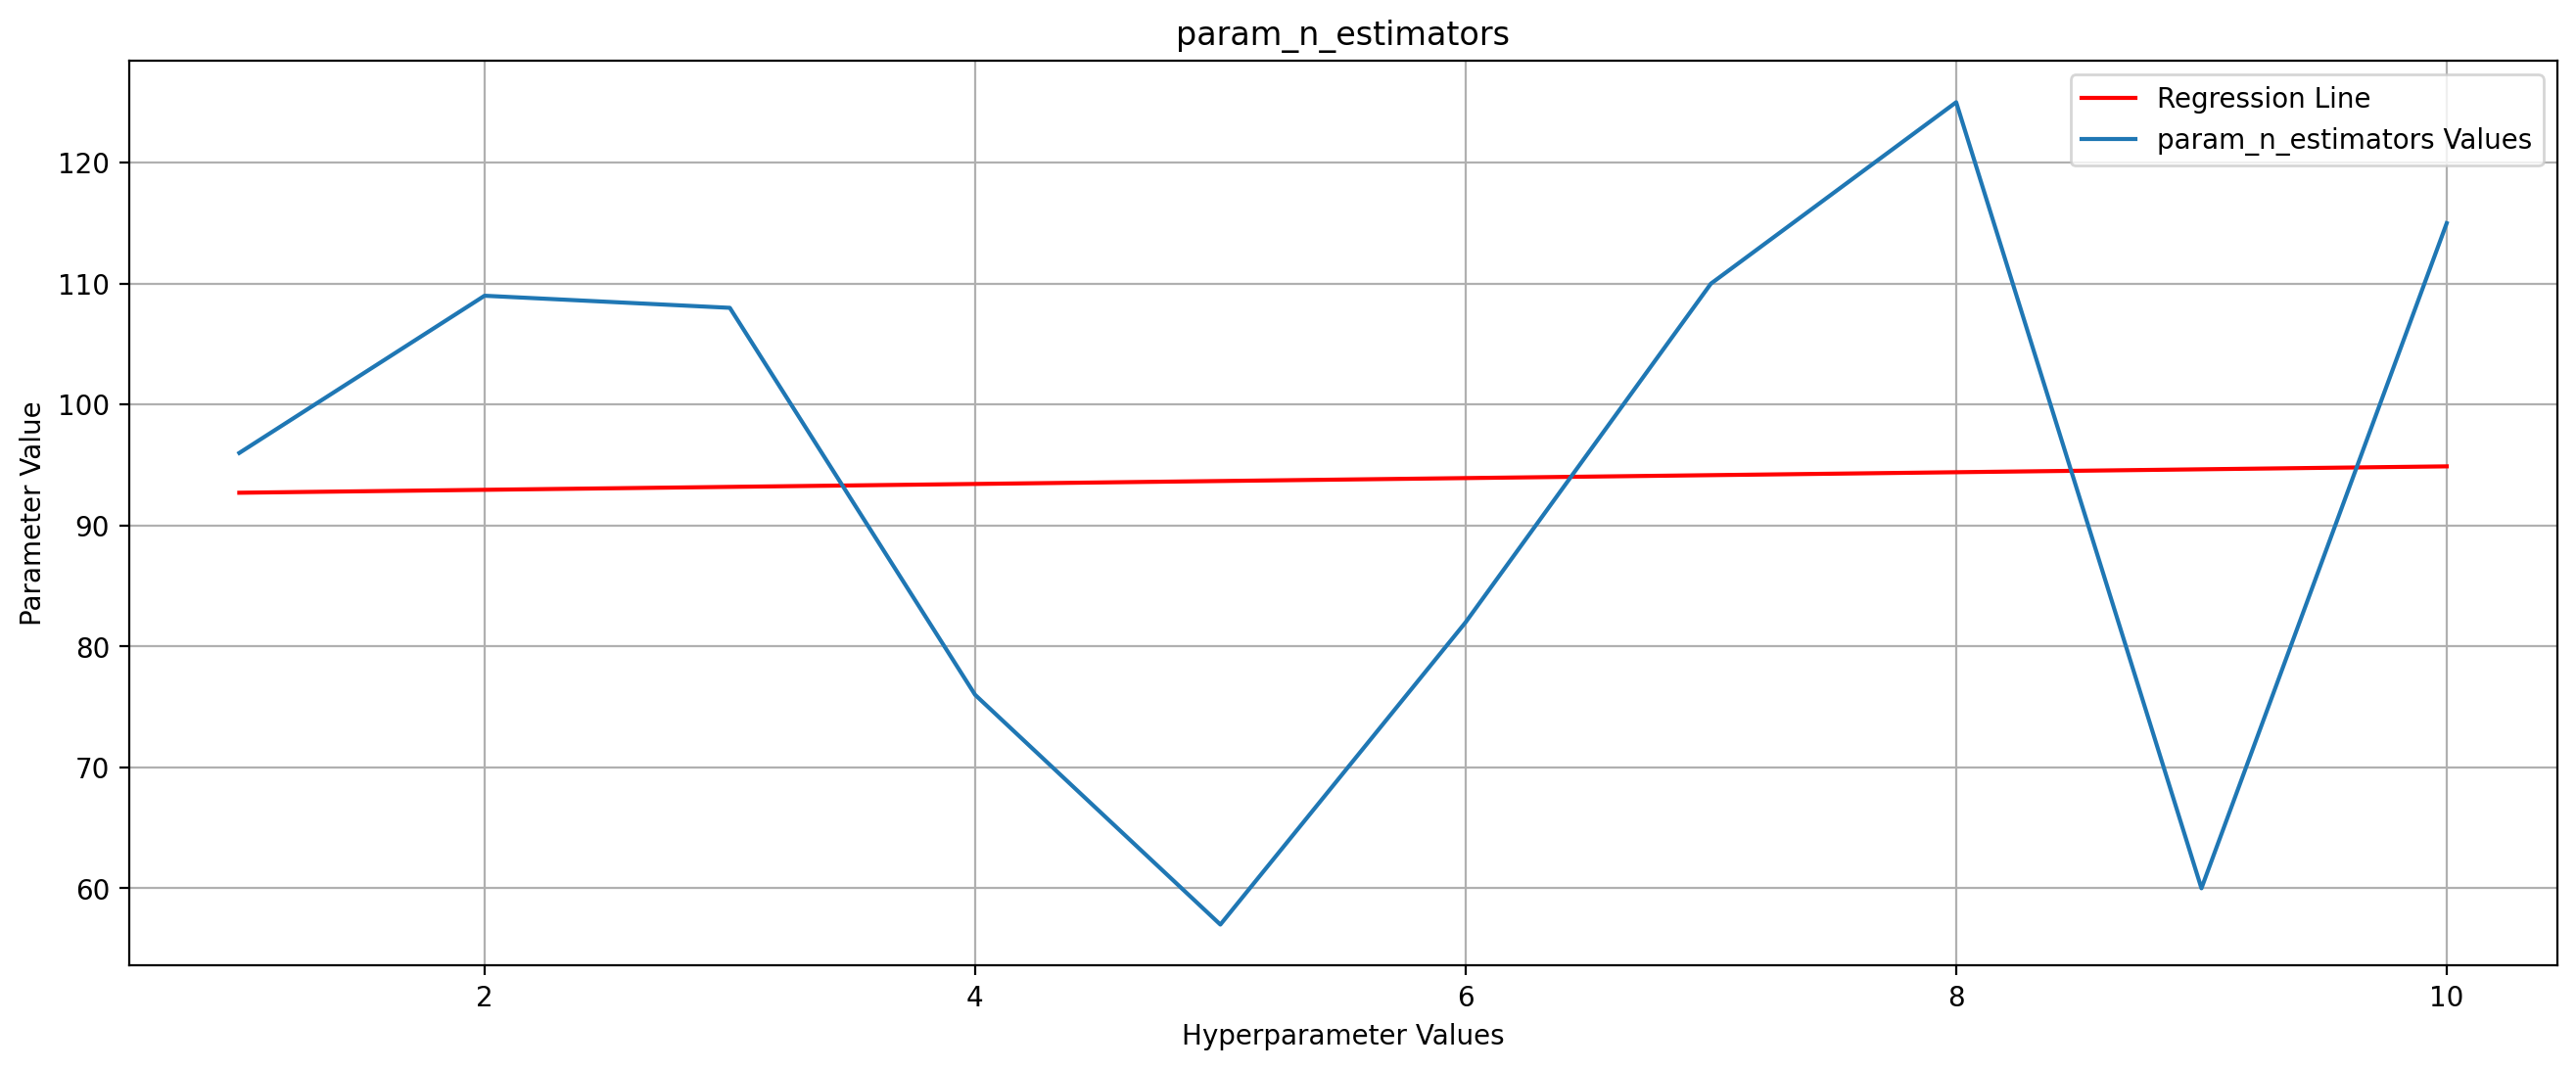

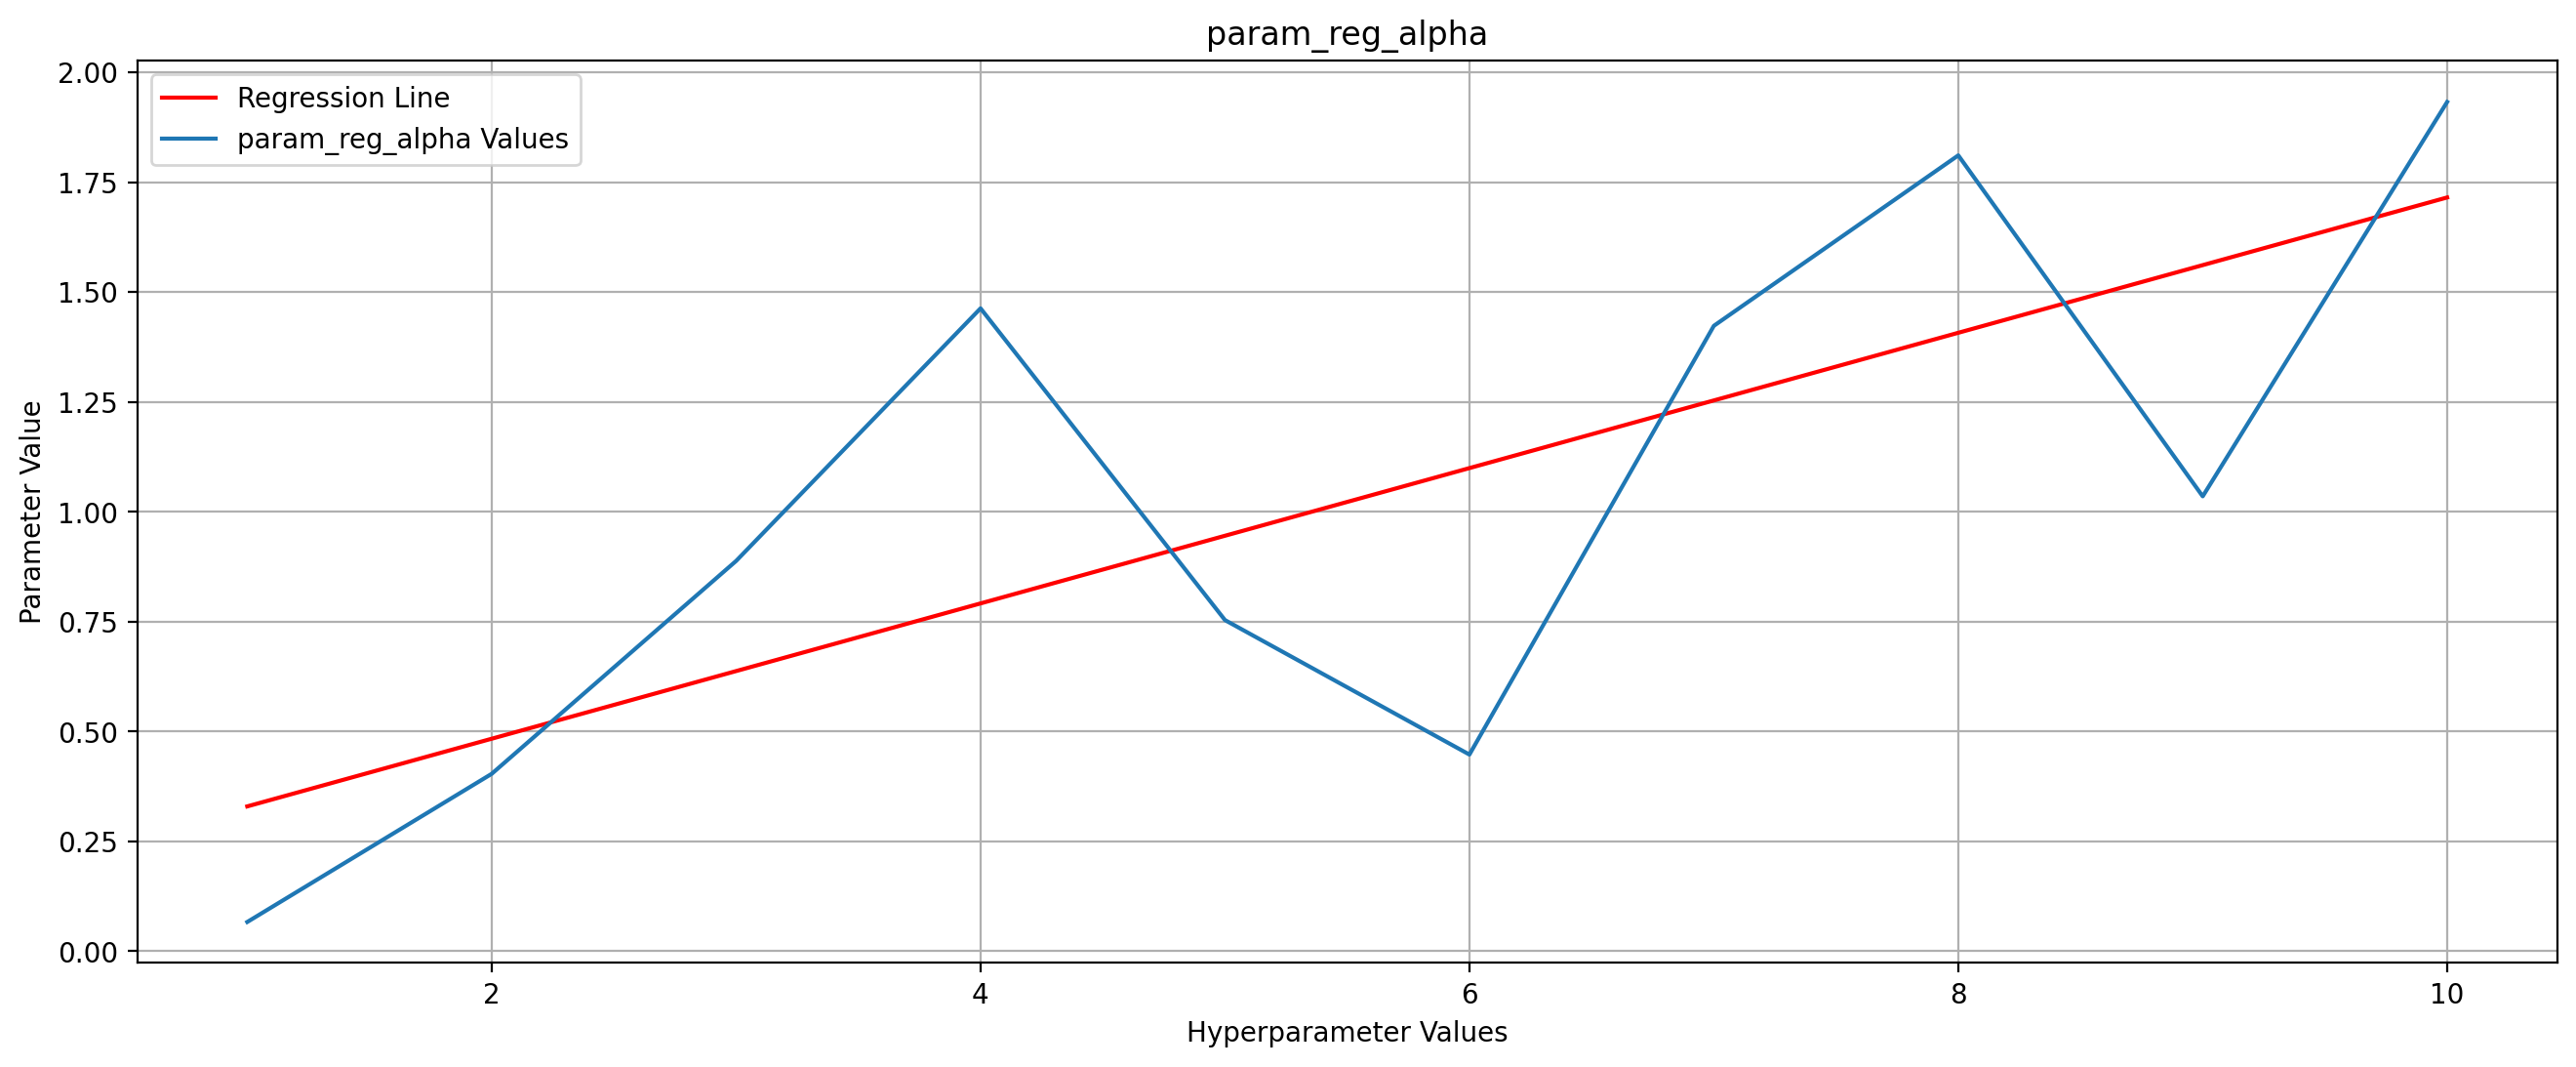

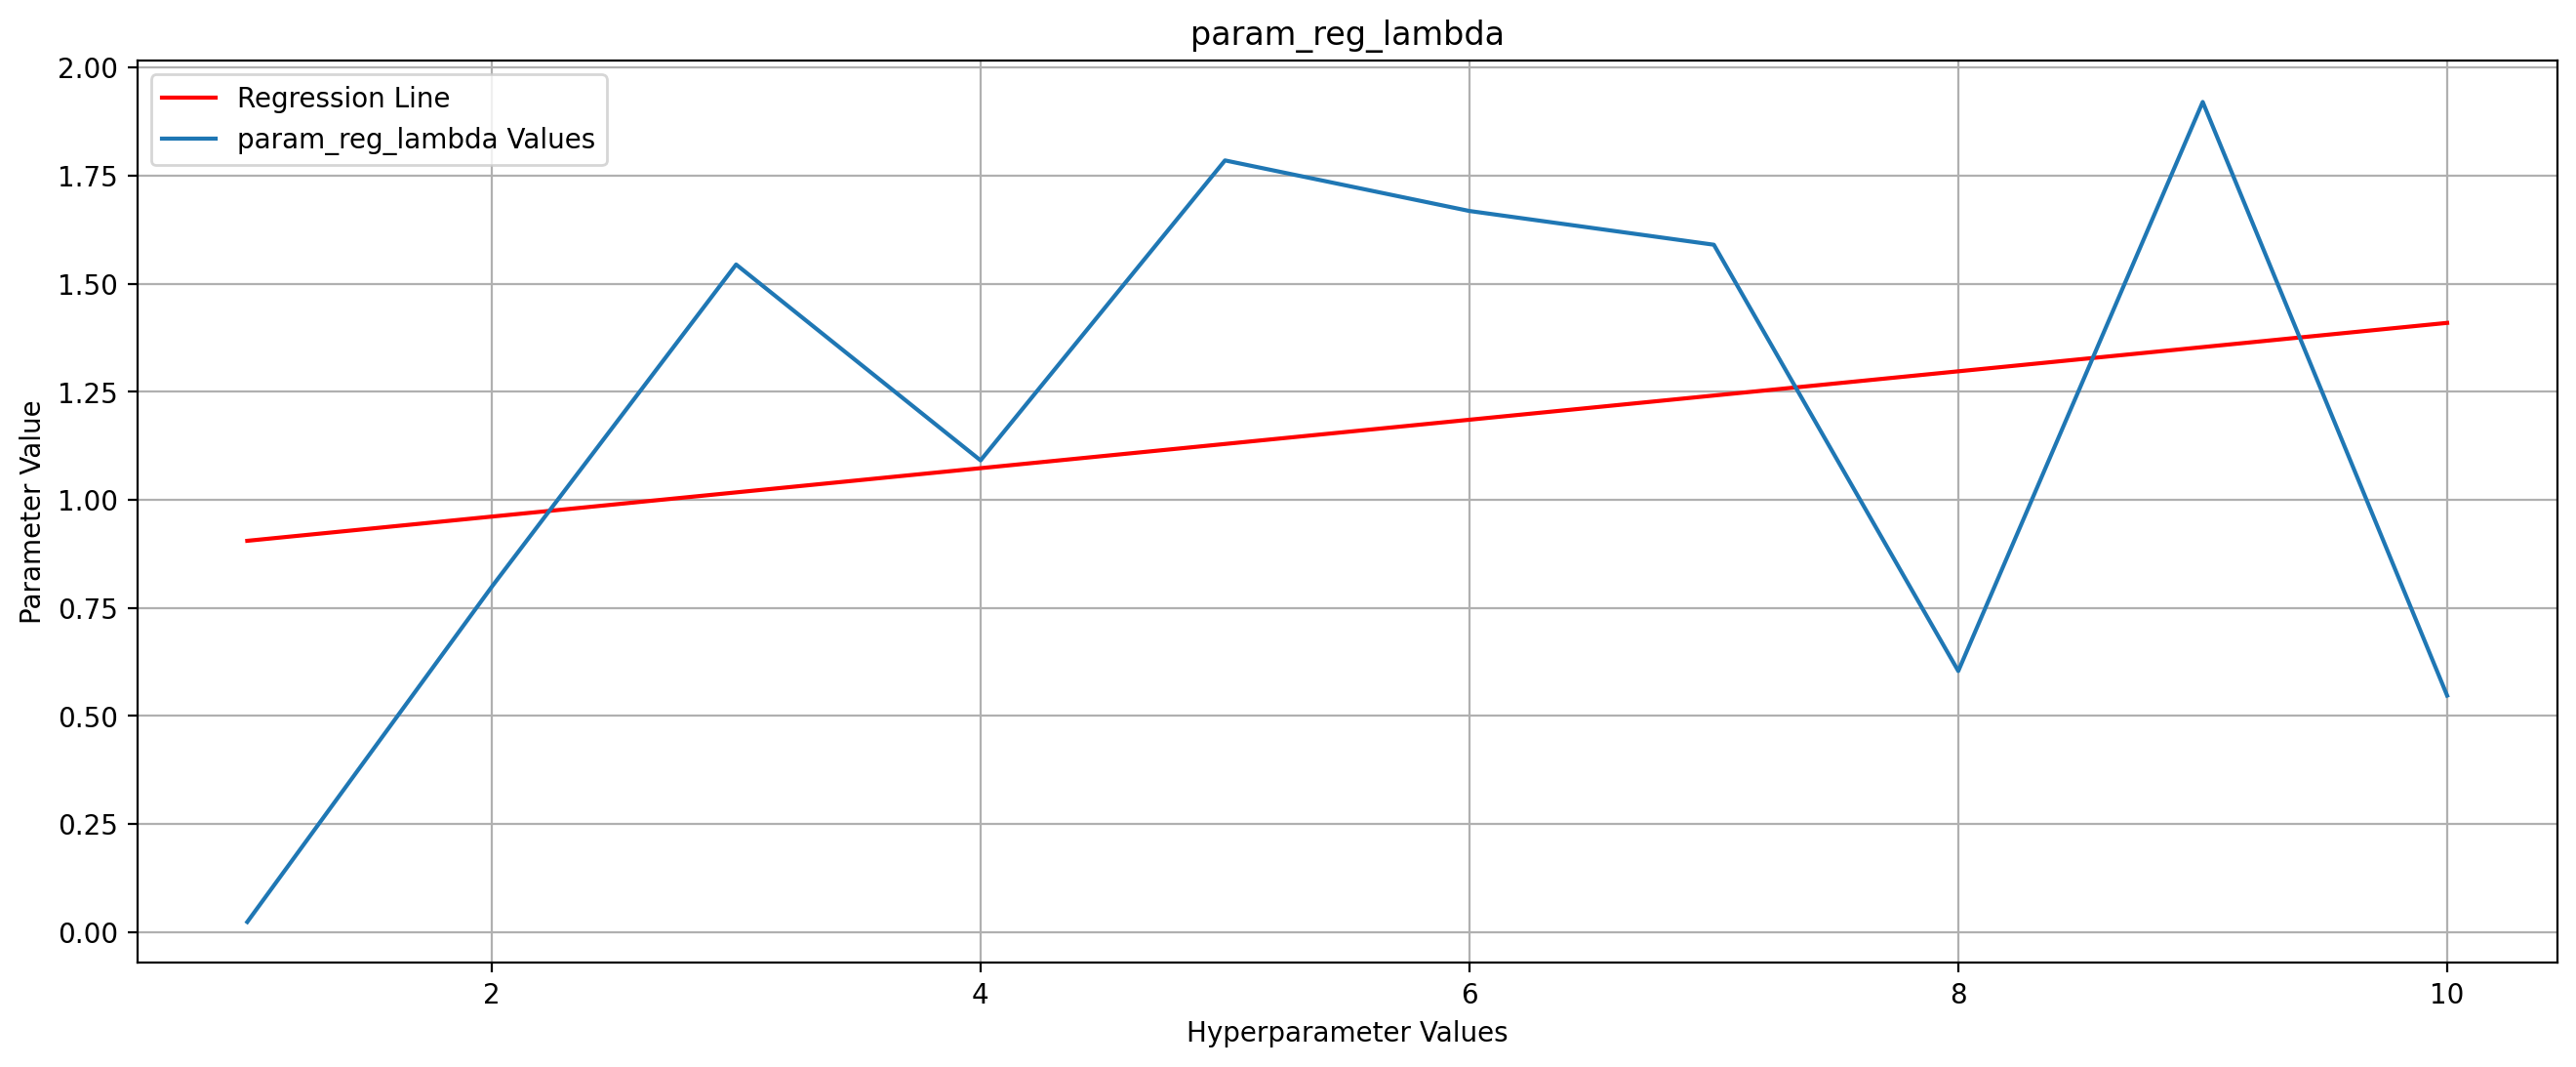

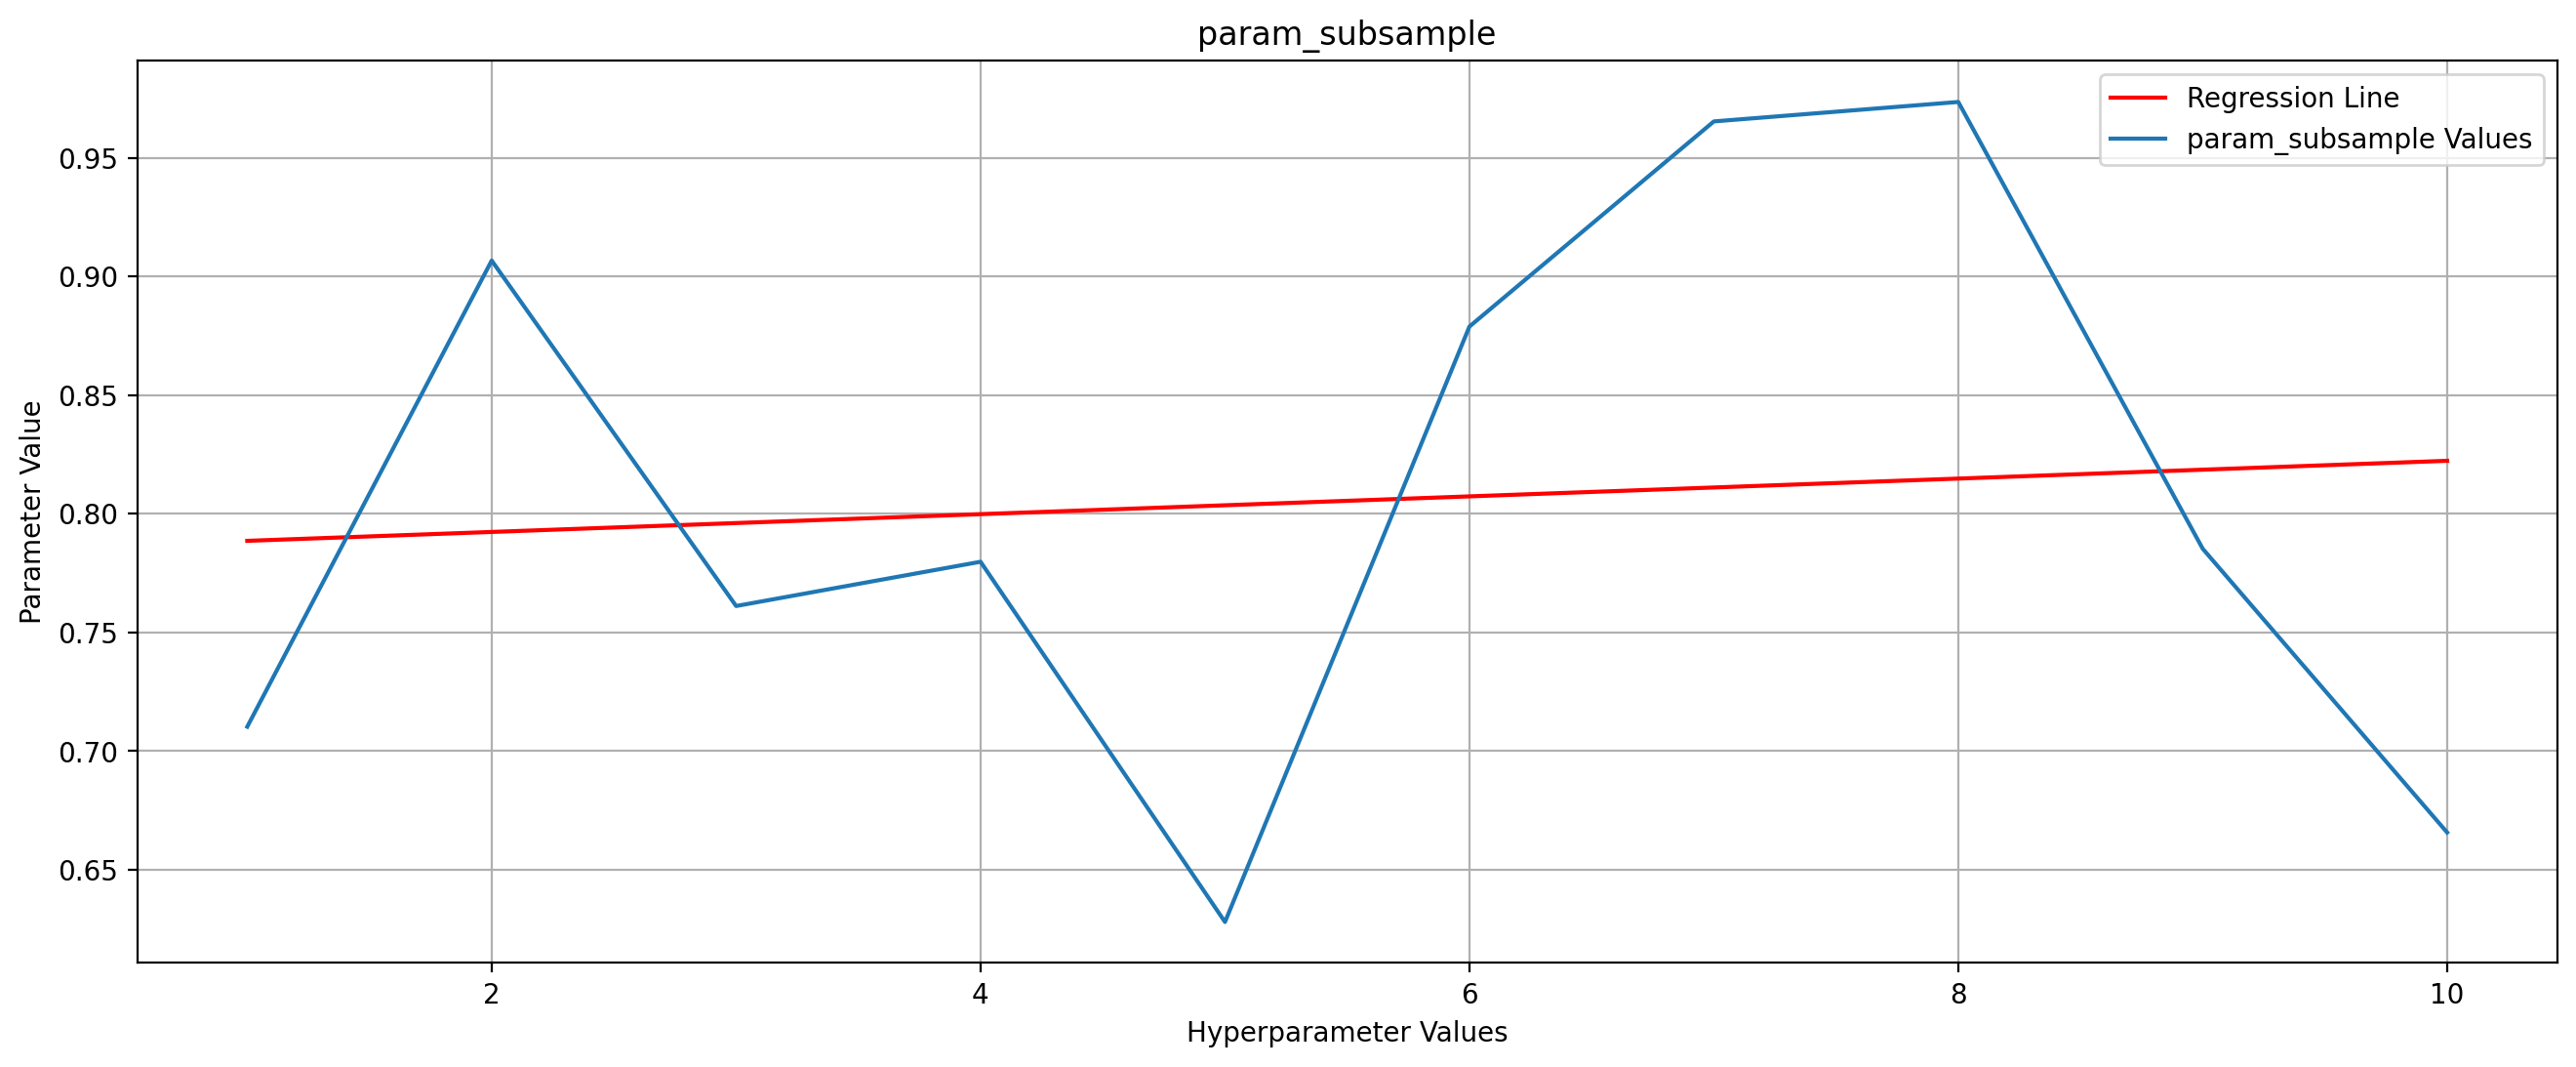

In [21]:
# TEST
for col in ['param_colsample_bylevel', 'param_colsample_bynode',
       'param_colsample_bytree', 'param_gamma', 'param_learning_rate',
       'param_max_depth', 'param_n_estimators', 'param_reg_alpha',
       'param_reg_lambda', 'param_subsample']:
    
    plt.figure(figsize=(16, 6))    

    m, b = np.polyfit(list(sorted_cv['rank_test_score'].values), list(sorted_cv[col].values), 1)
    plt.plot(sorted_cv['rank_test_score'], m * sorted_cv['rank_test_score'] + b, c='r', label="Regression Line")
    plt.plot(sorted_cv['rank_test_score'], sorted_cv[col], label=f"{col} Values")
    
    plt.grid()
    plt.xlabel('Hyperparameter Values')
    plt.ylabel('Parameter Value')
    plt.title(col)
    plt.legend(loc='best')

    
    filename = f"{col}_by_rank.png"
    plt.savefig(os.path.join(results_path, filename))
                  
    plt.show()


# Hyperparameter Evaluation

In [22]:

def plot_parameters(x_values, title):
    
    fig, ax1 = plt.subplots(figsize=(16, 6))
    ax2 = ax1.twinx()

    ax1.scatter(x_values, cv_results['mean_test_score'], label='mean_test_score', c='b')
    ax2.scatter(x_values, cv_results['std_test_score'], label='std_test_score', c='r')

    m, b = np.polyfit(list(x_values.values), list(cv_results['mean_test_score'].values), 1)
    ax1.plot(x_values, m * x_values + b, c='b')

    m, b = np.polyfit(list(x_values.values), list(cv_results['std_test_score'].values), 1)
    ax2.plot(x_values, m * x_values + b, c='r')
    
    ax1.set_title(title)
    ax1.set_xlabel('Parameter Value')
    ax1.set_ylabel('Mean Test Score')
    ax2.set_ylabel('Standard Deviation of Test Score')
    ax1.grid(True)
    
    
    # Combine the legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    filename = f"{title}_test_score.png"
    plt.savefig(os.path.join(results_path, filename))
            
    plt.show()



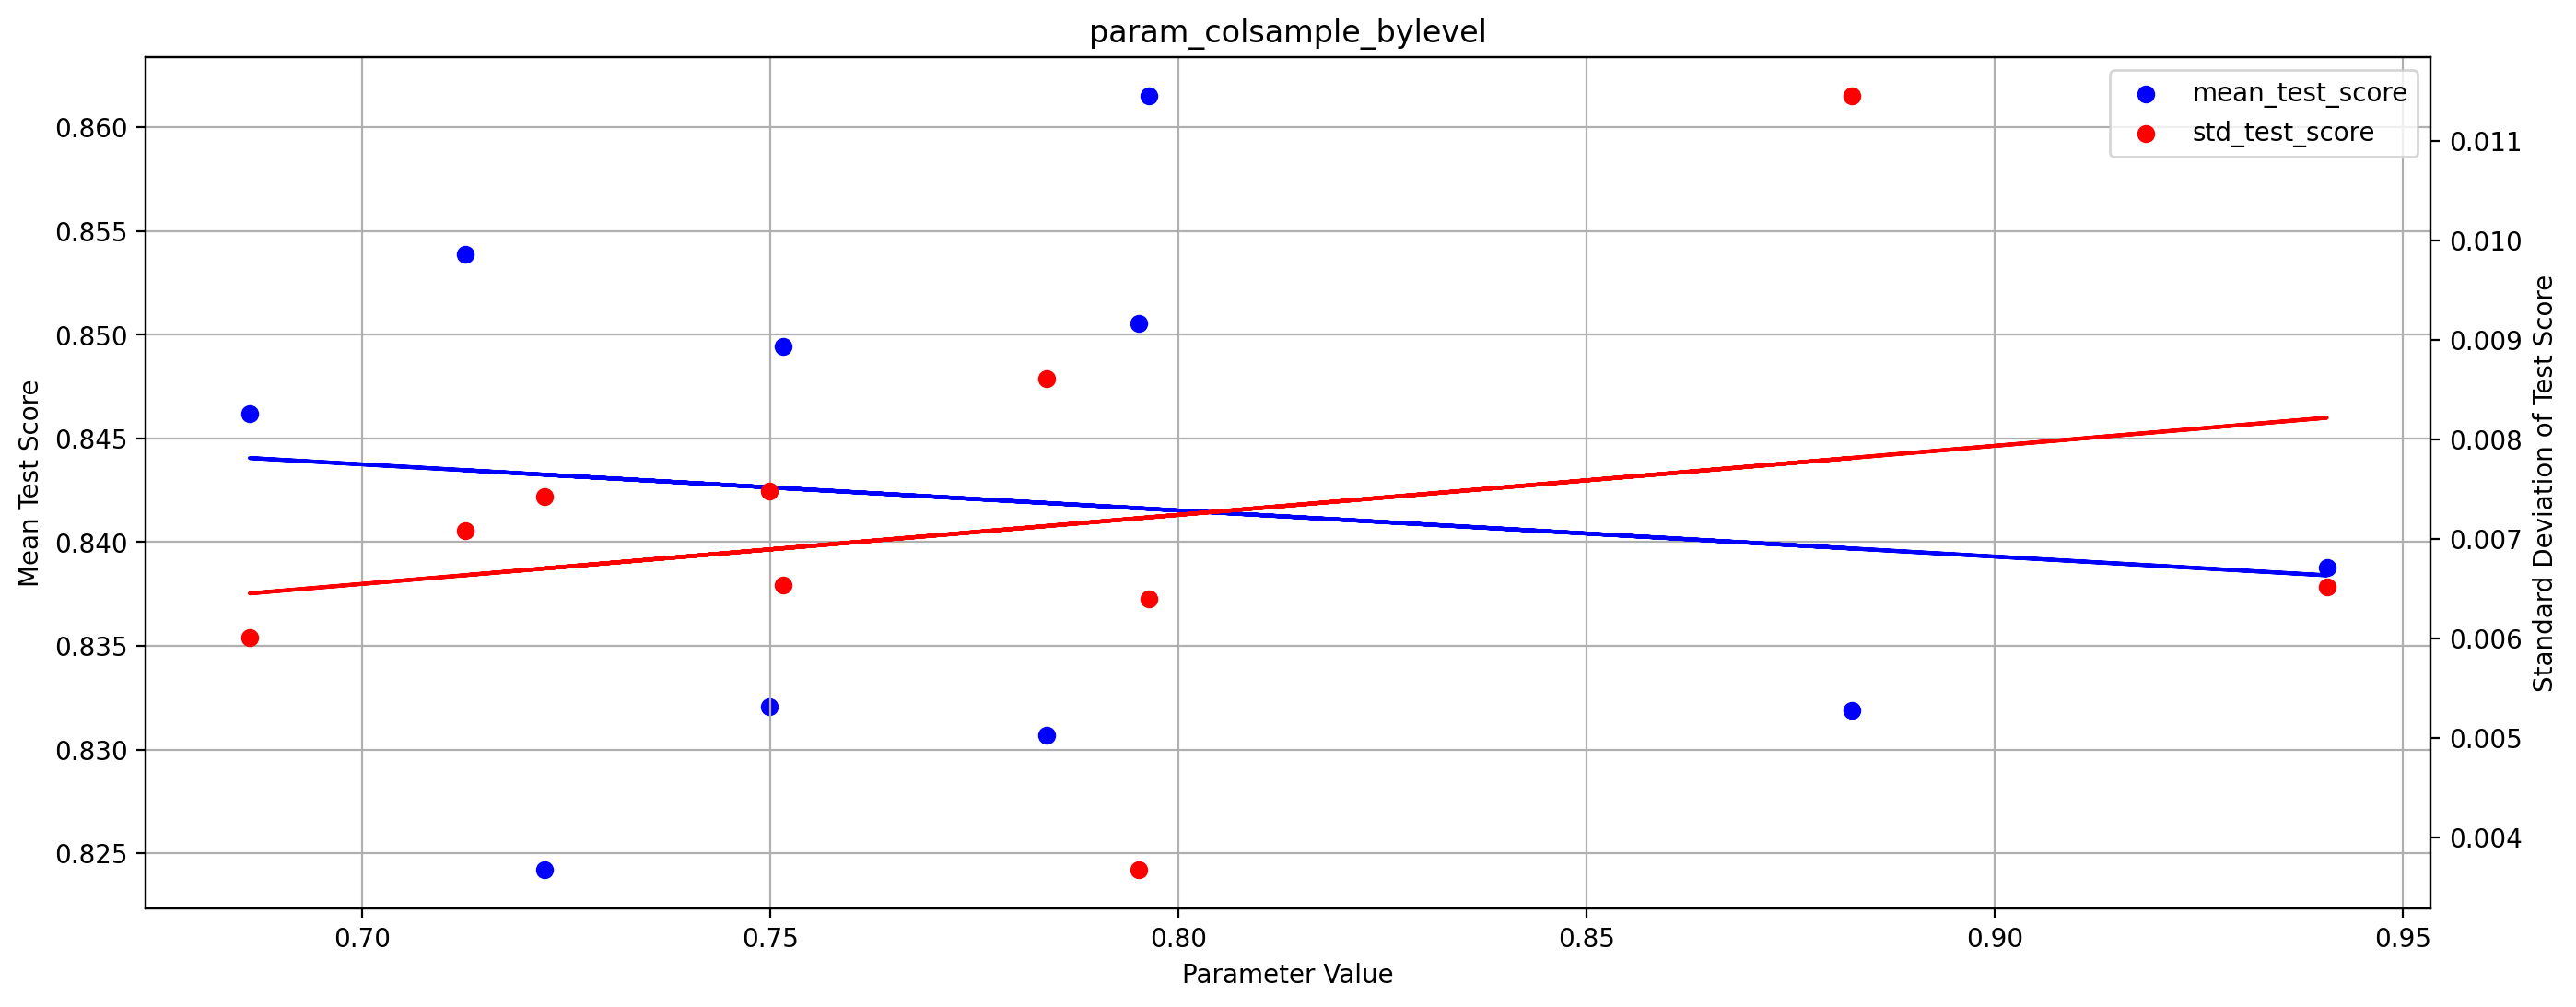

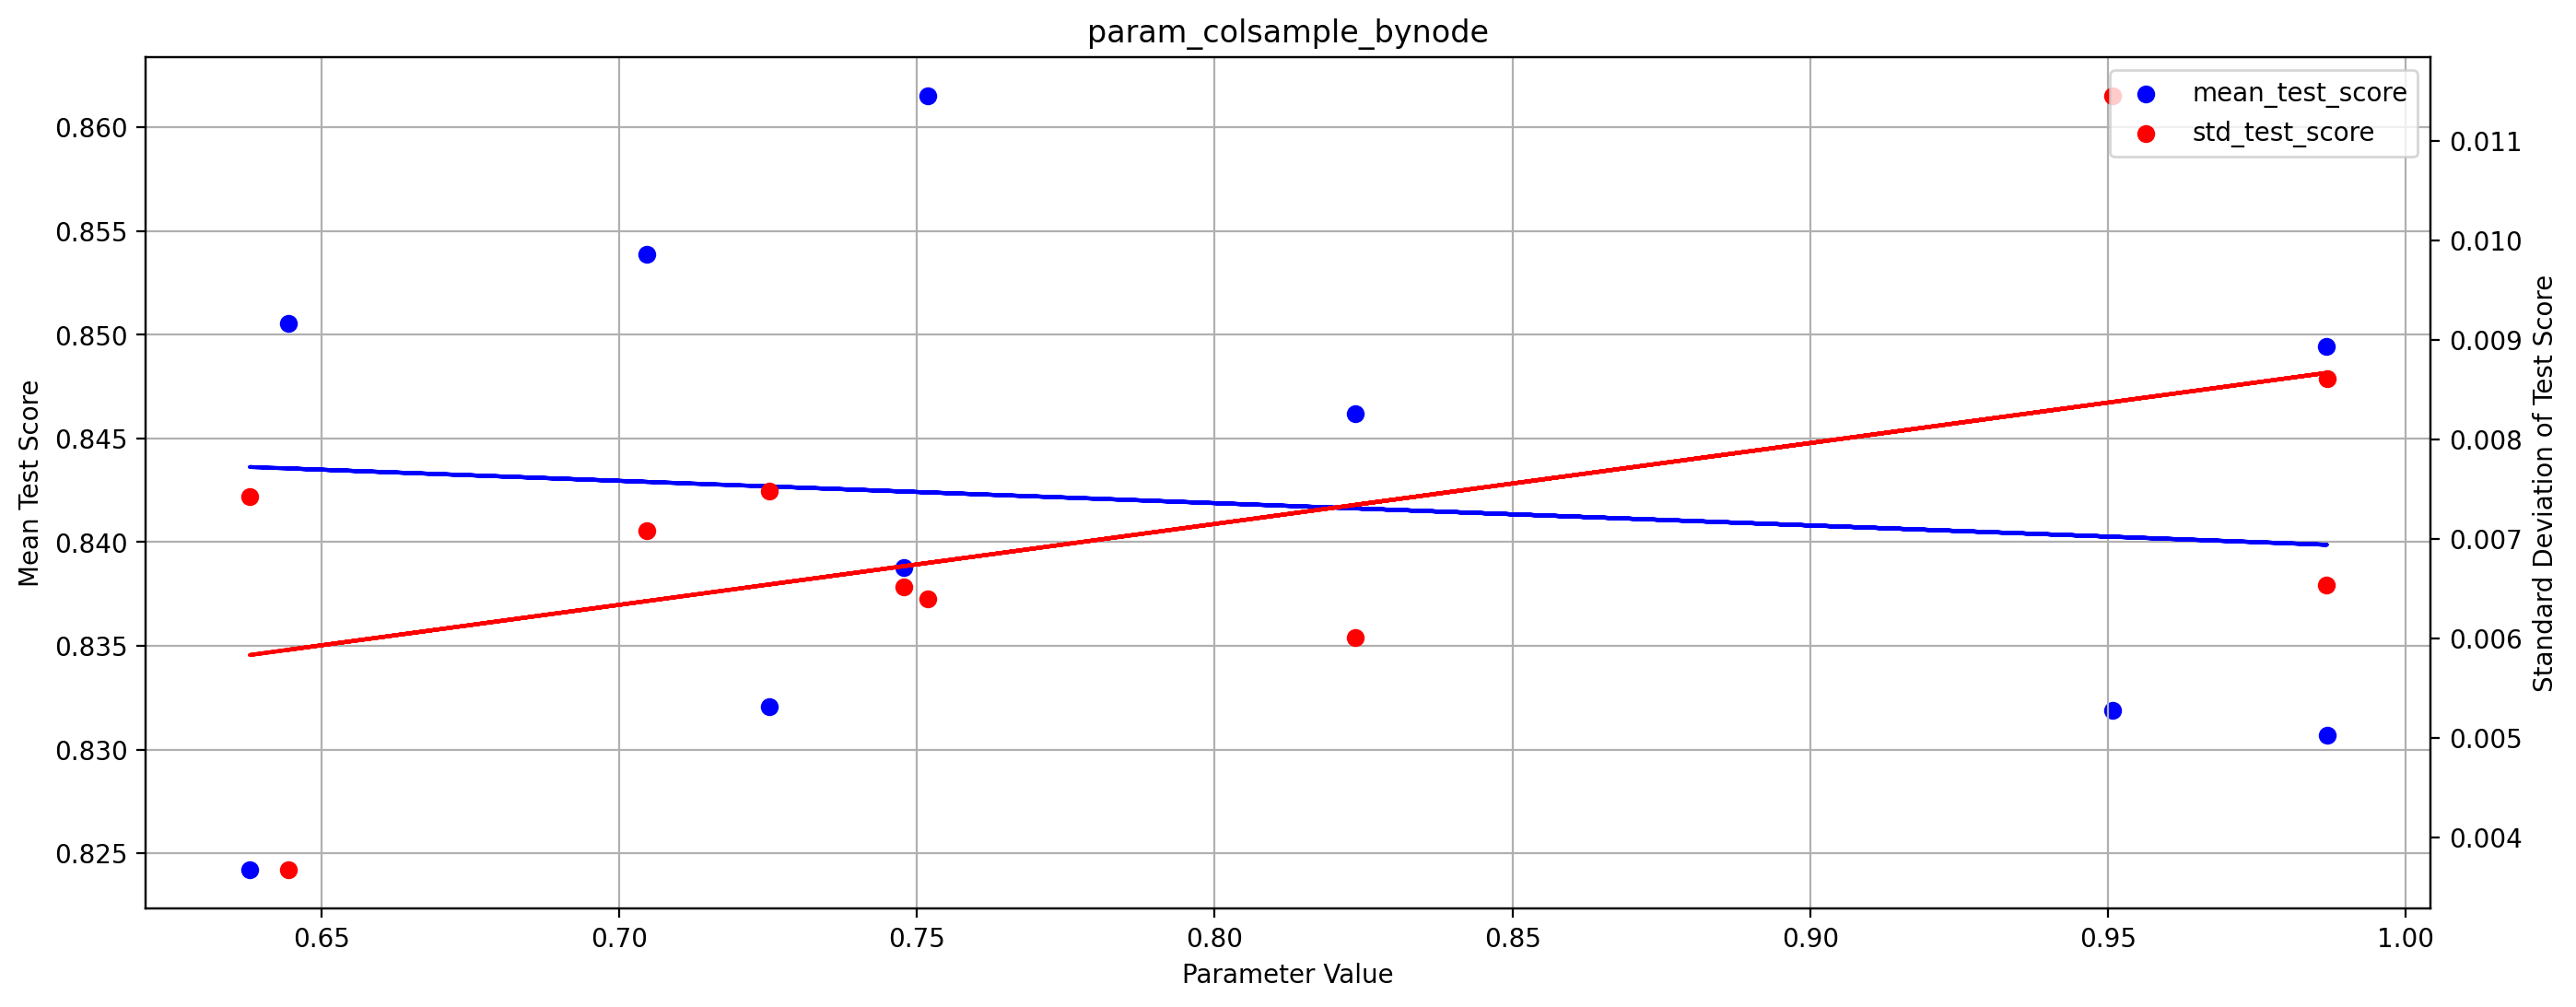

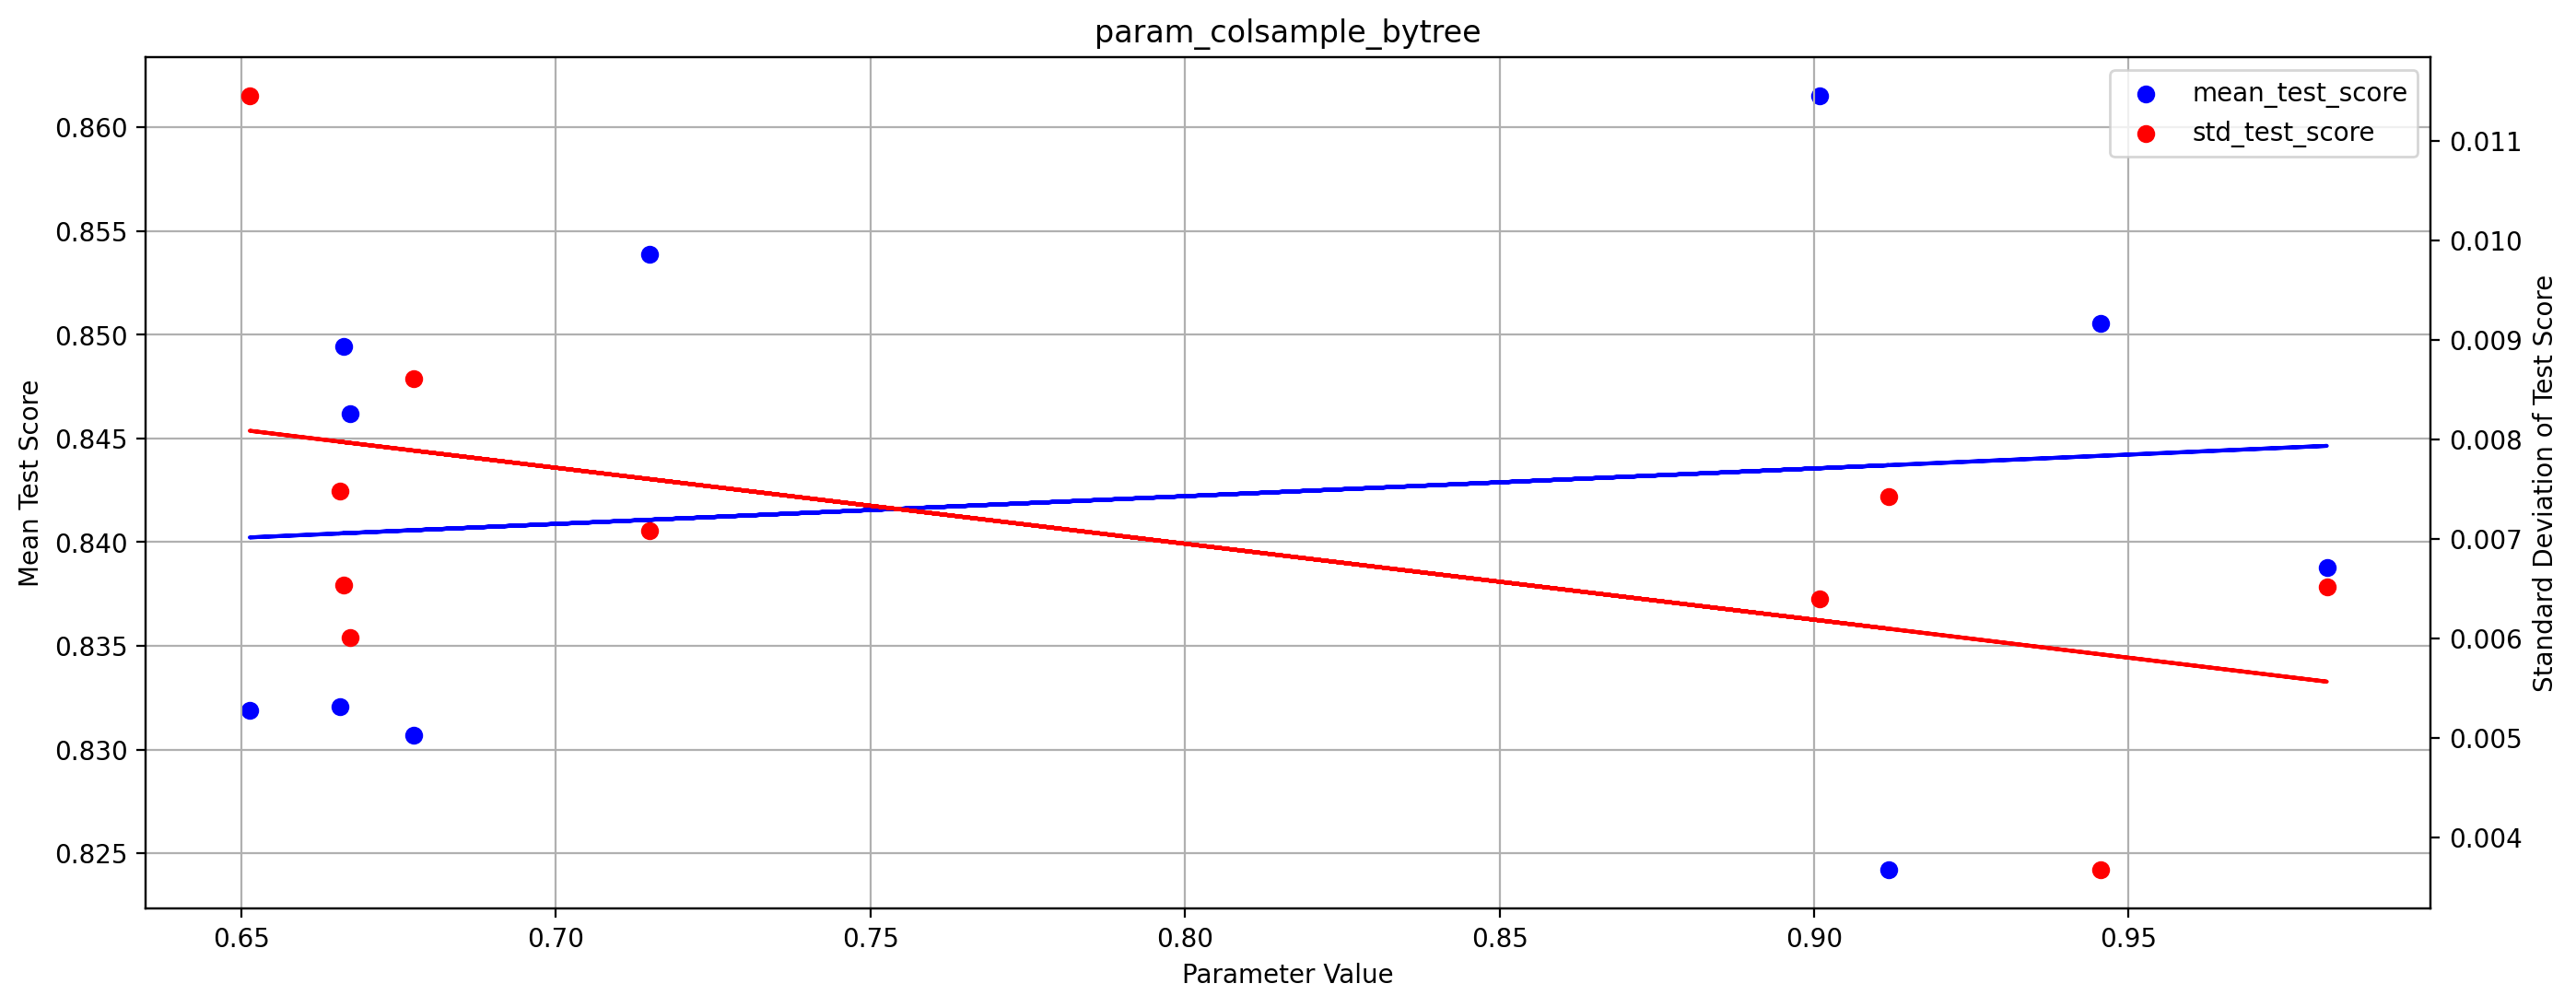

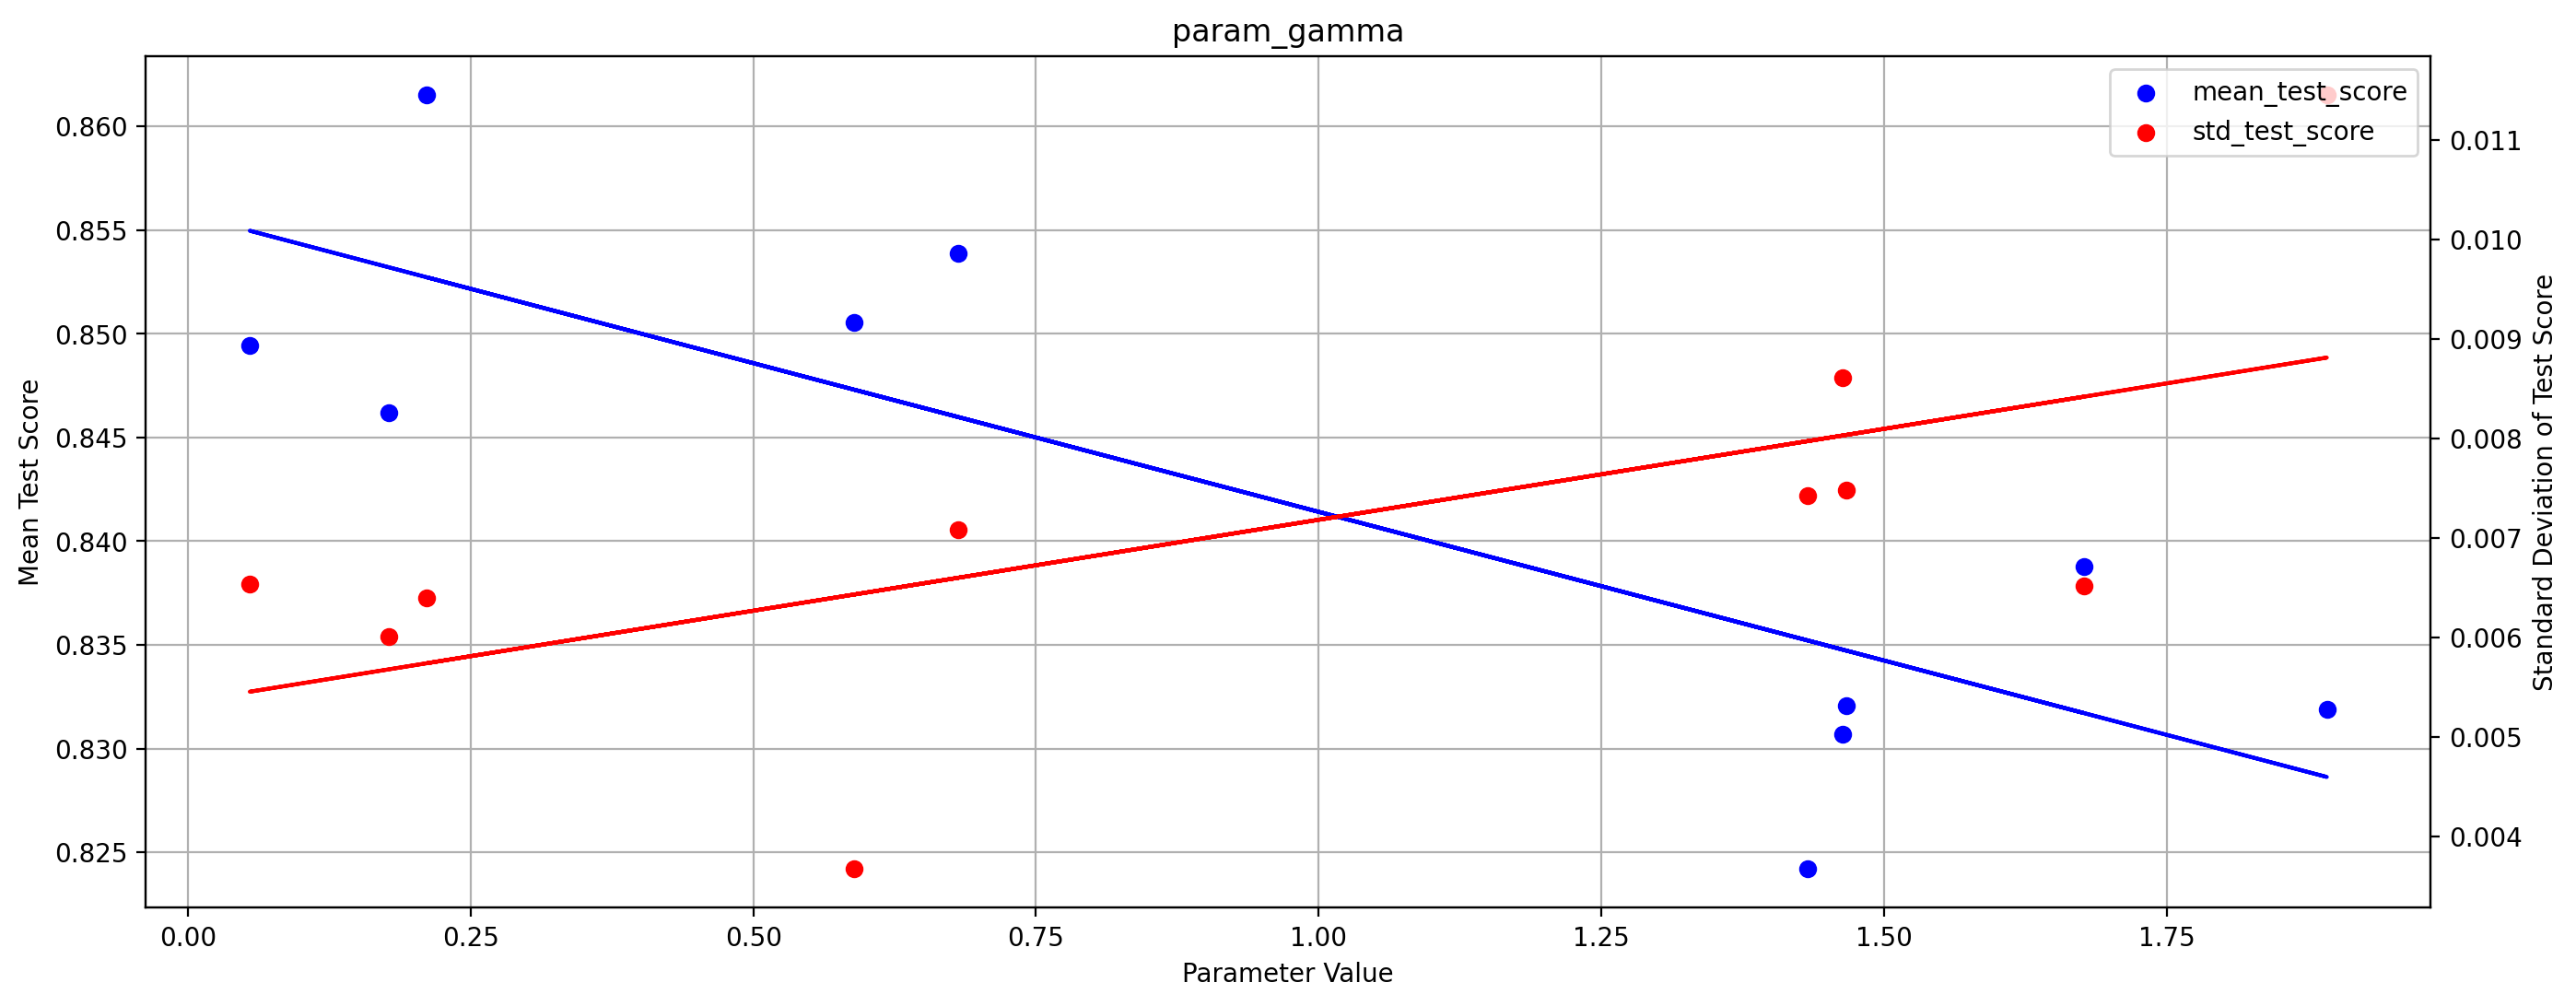

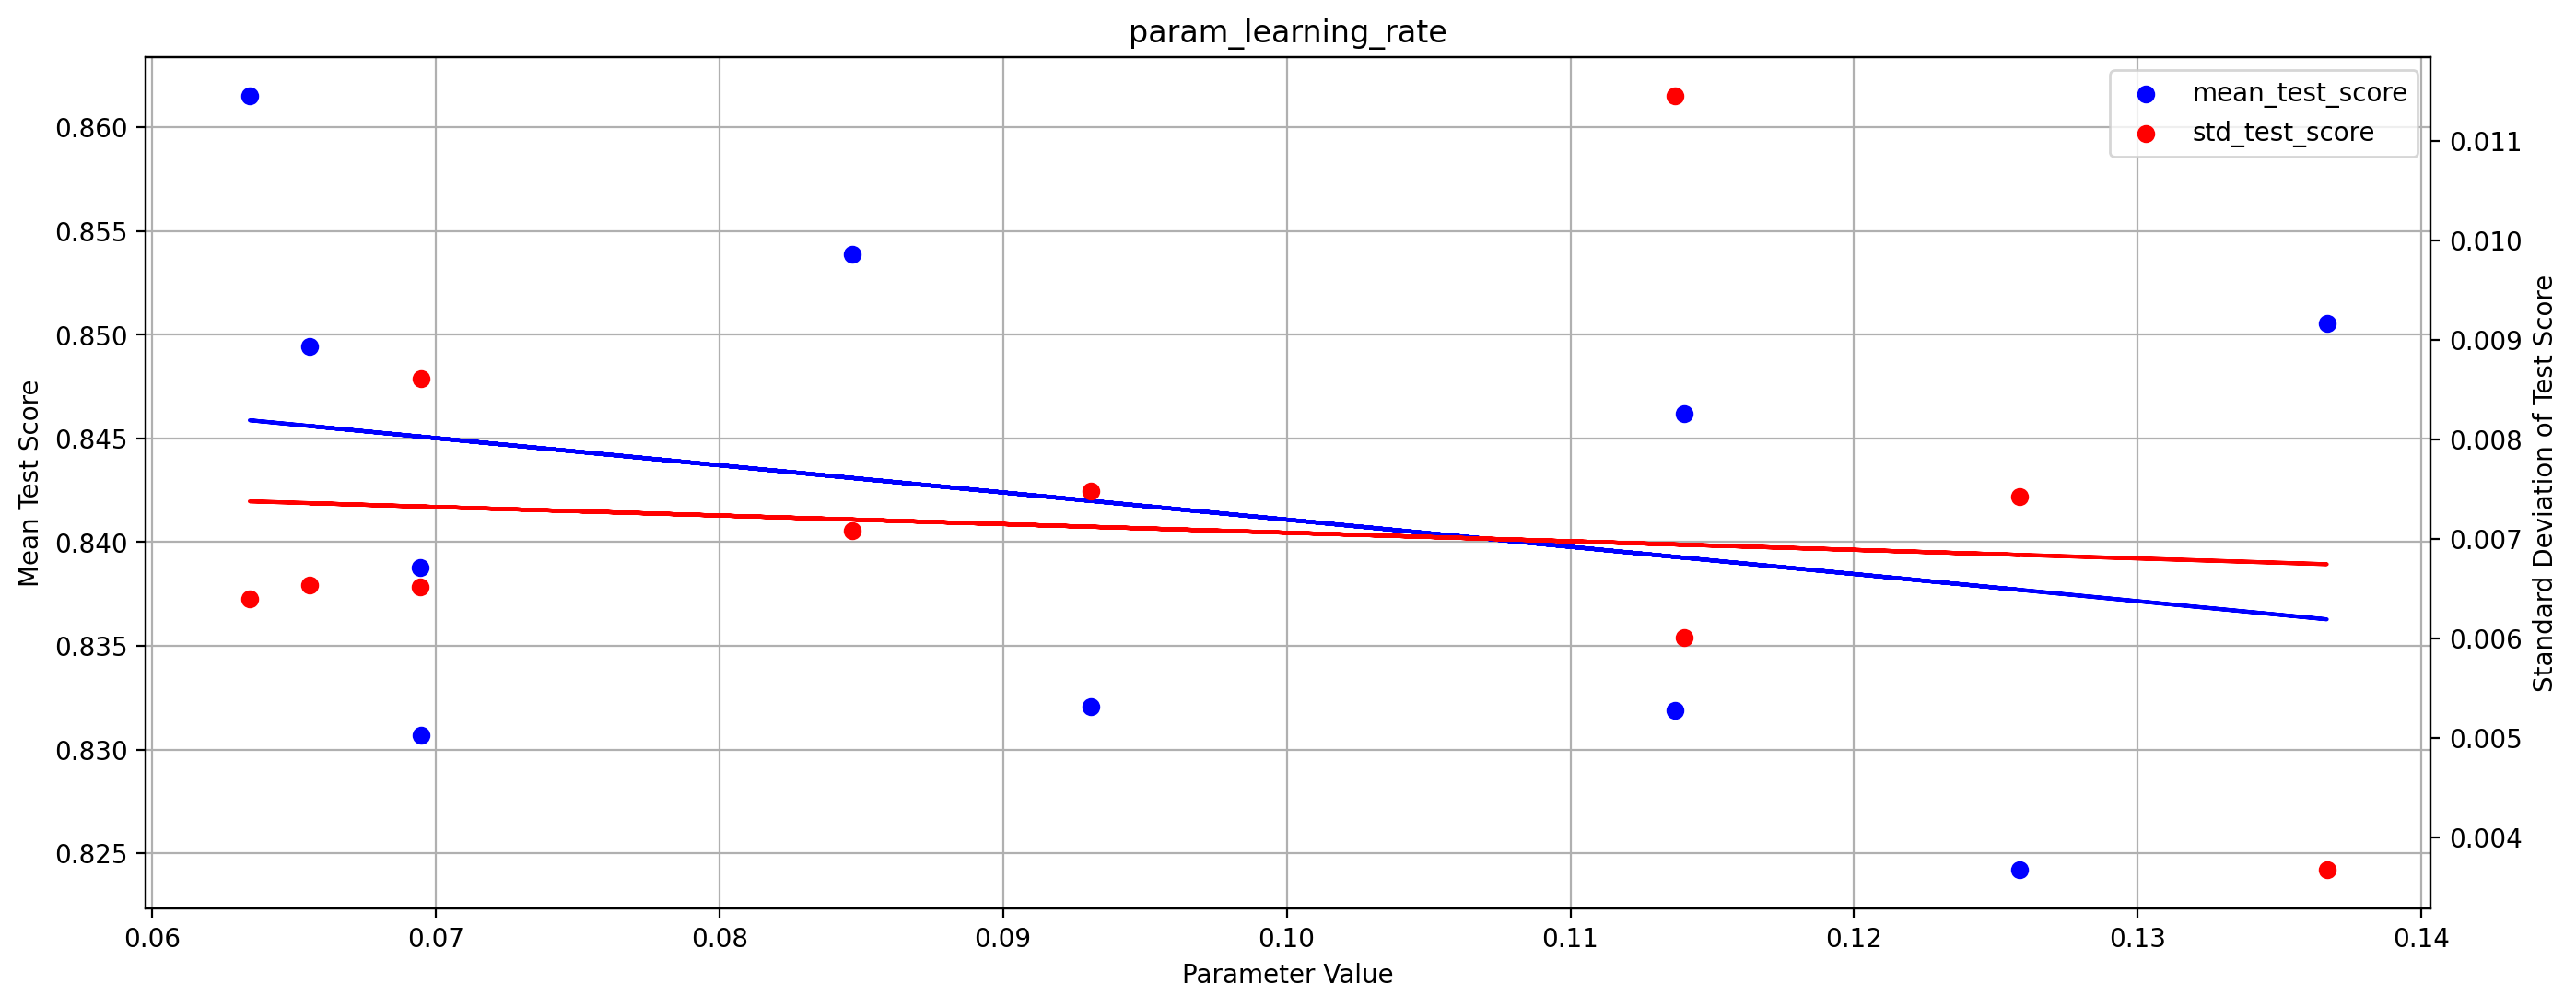

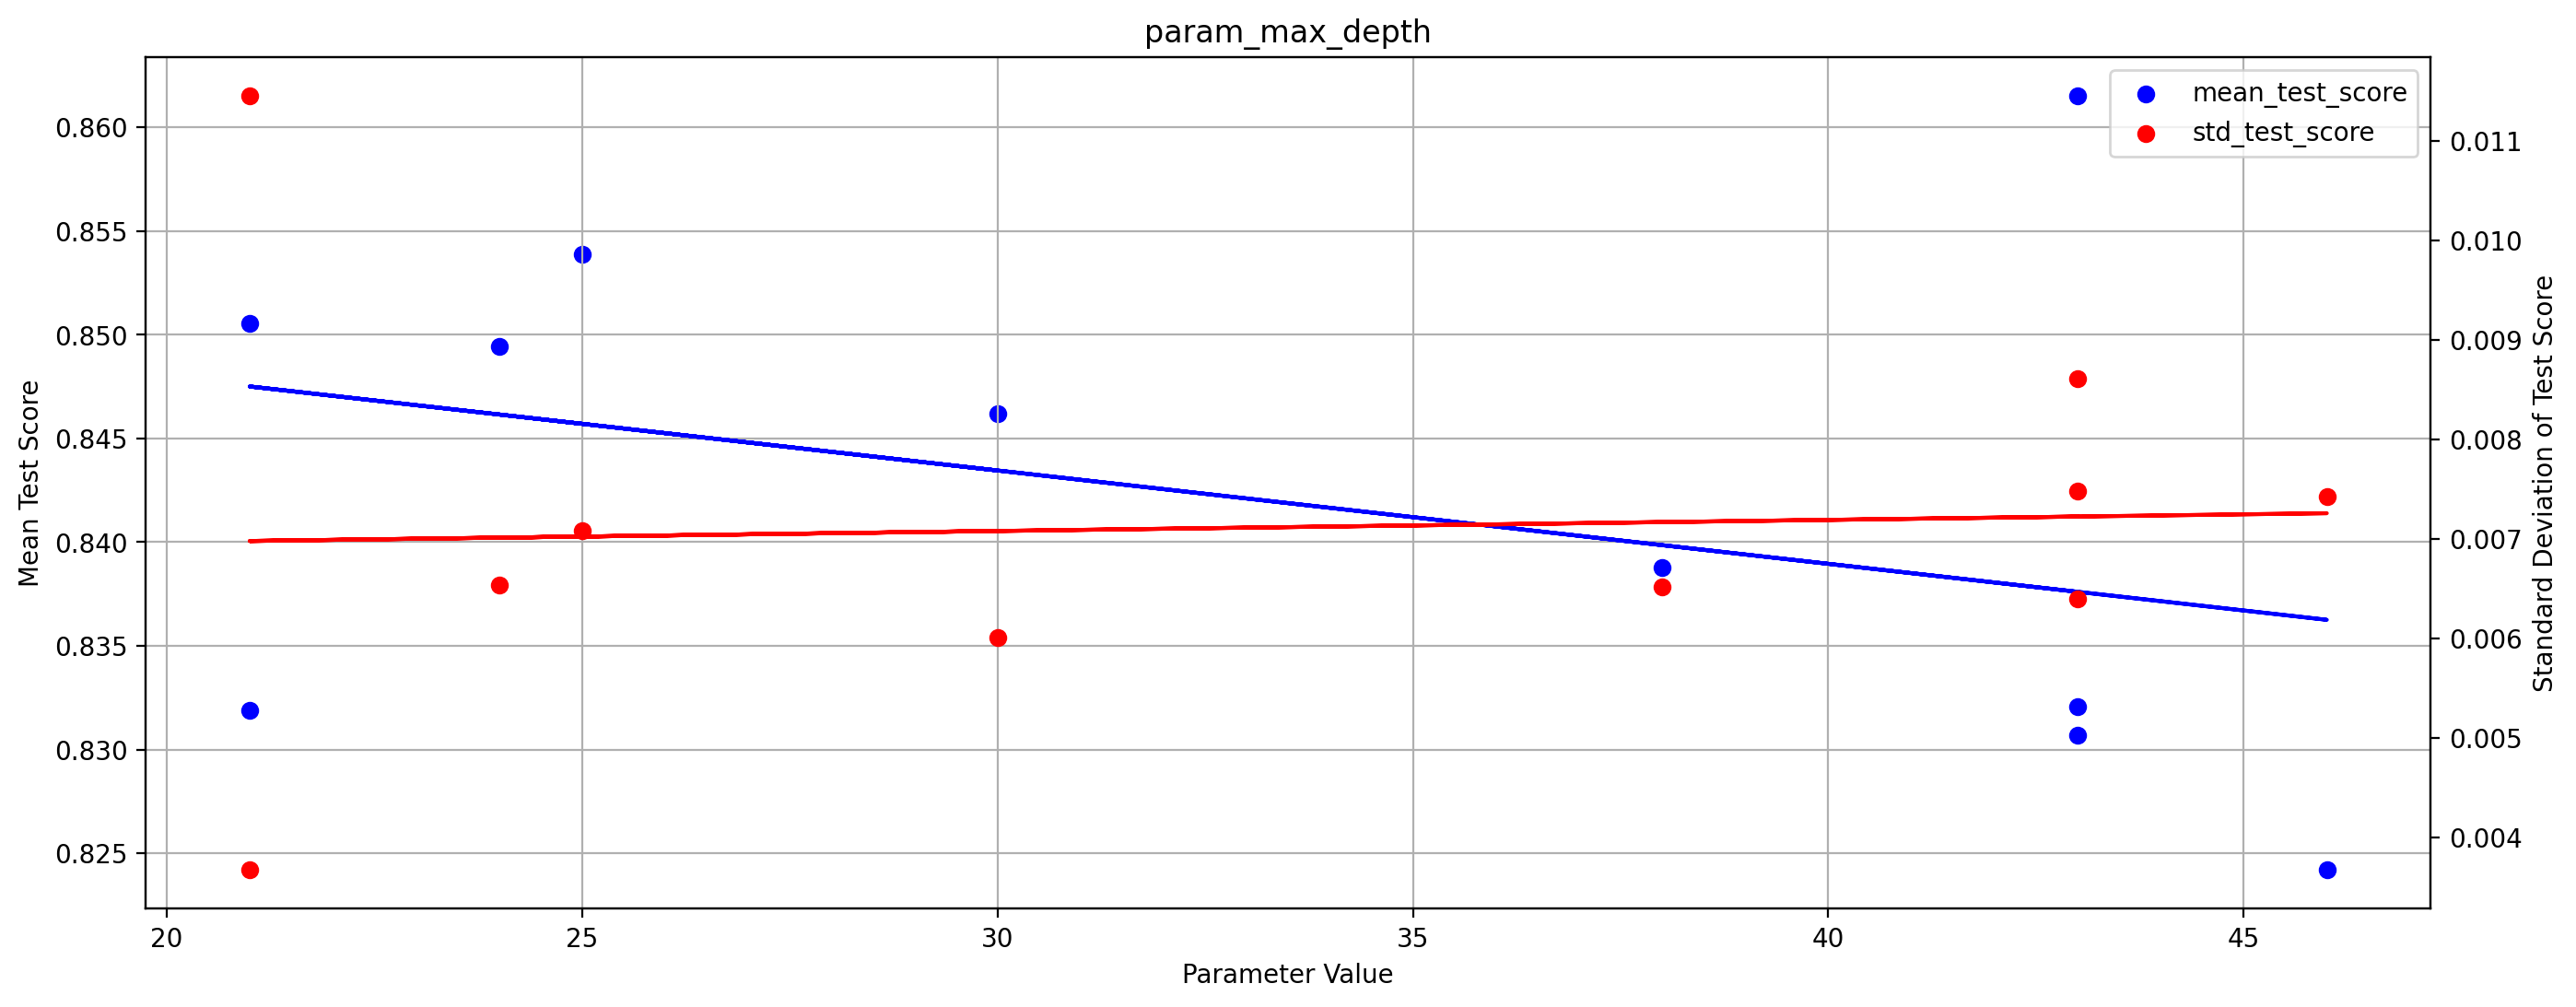

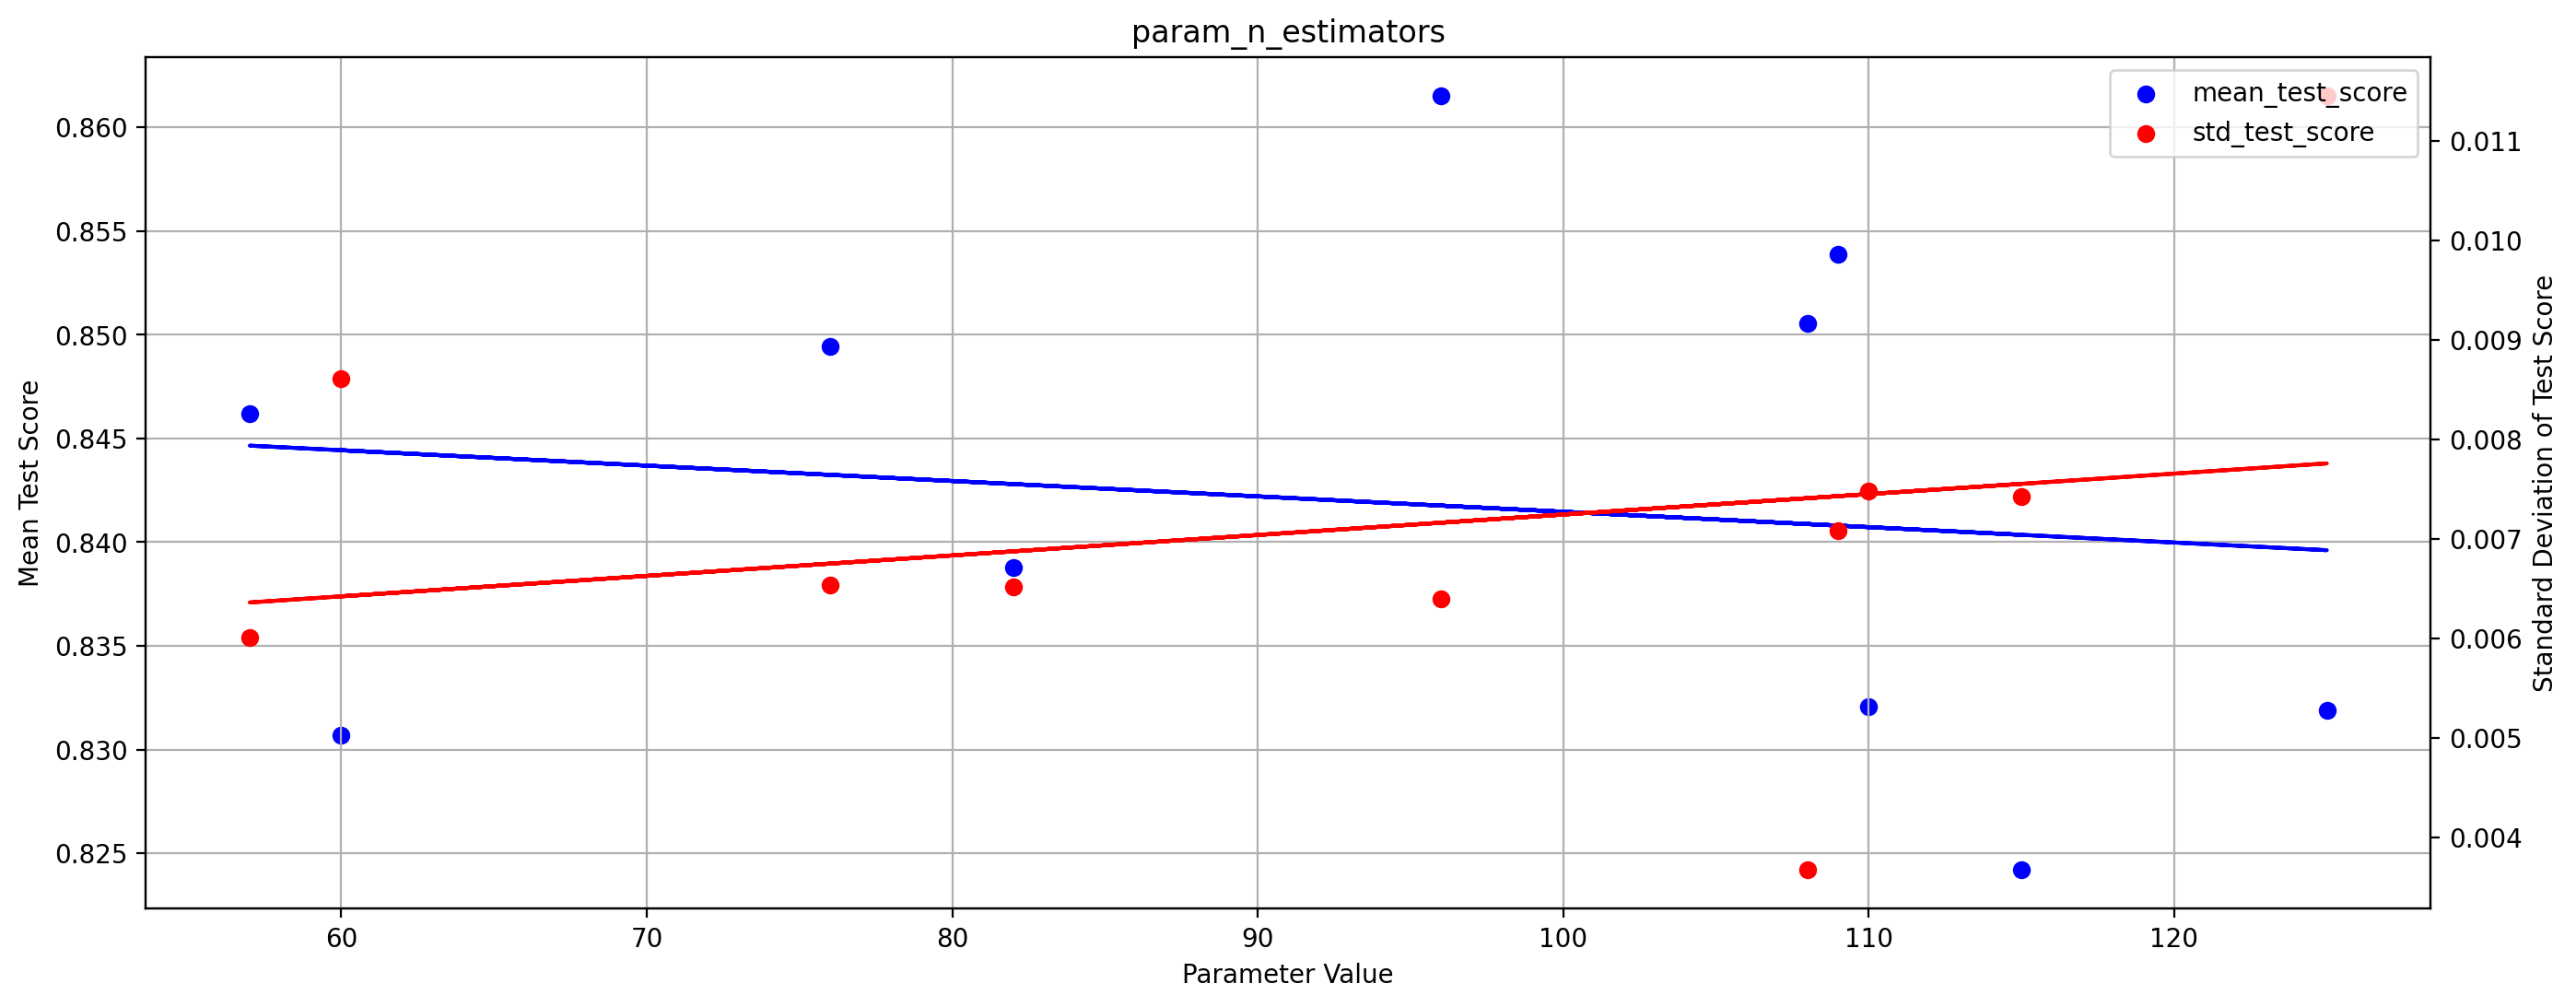

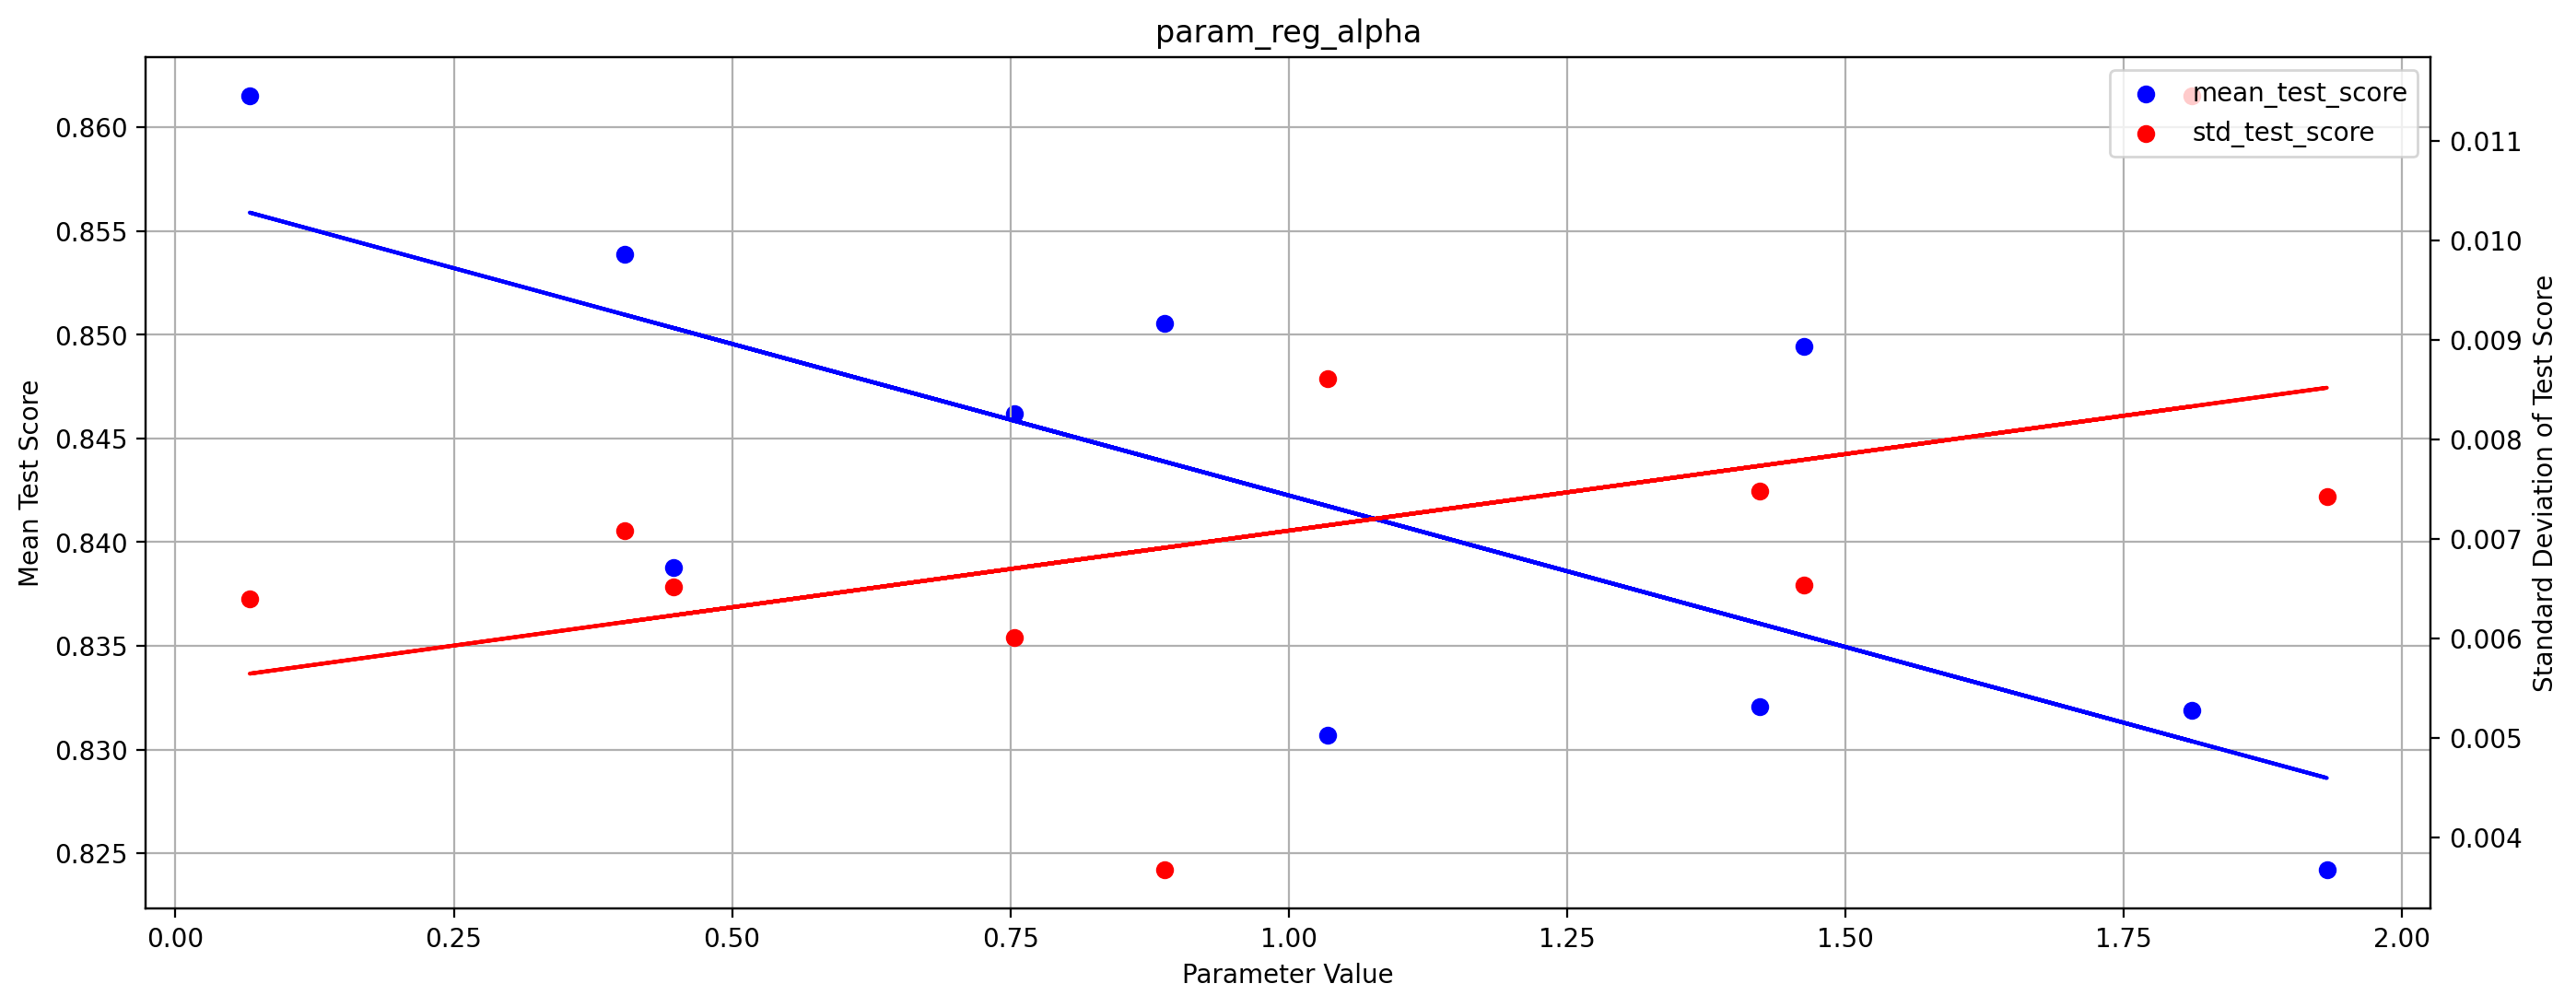

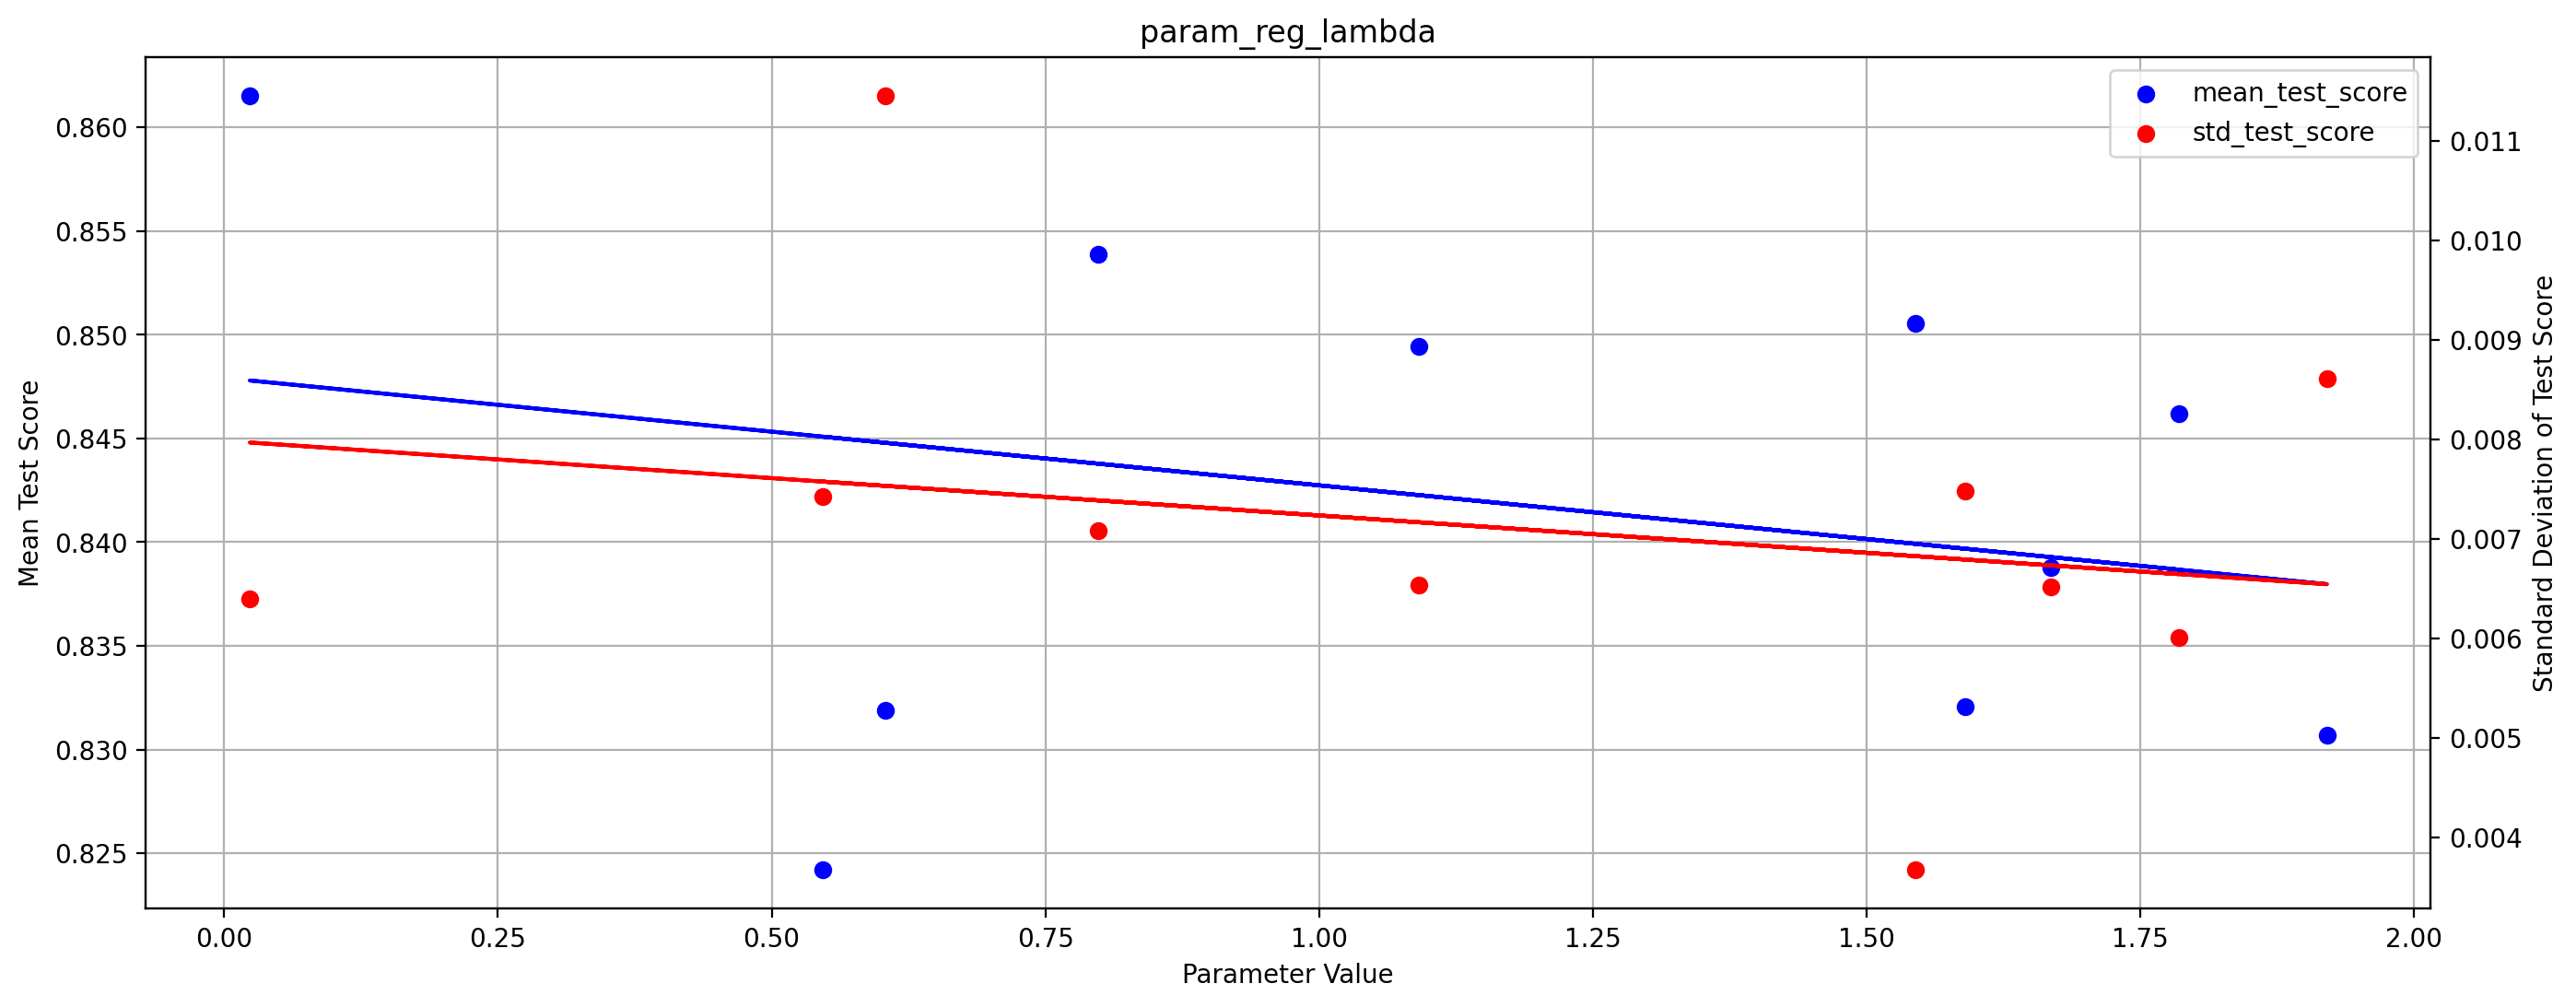

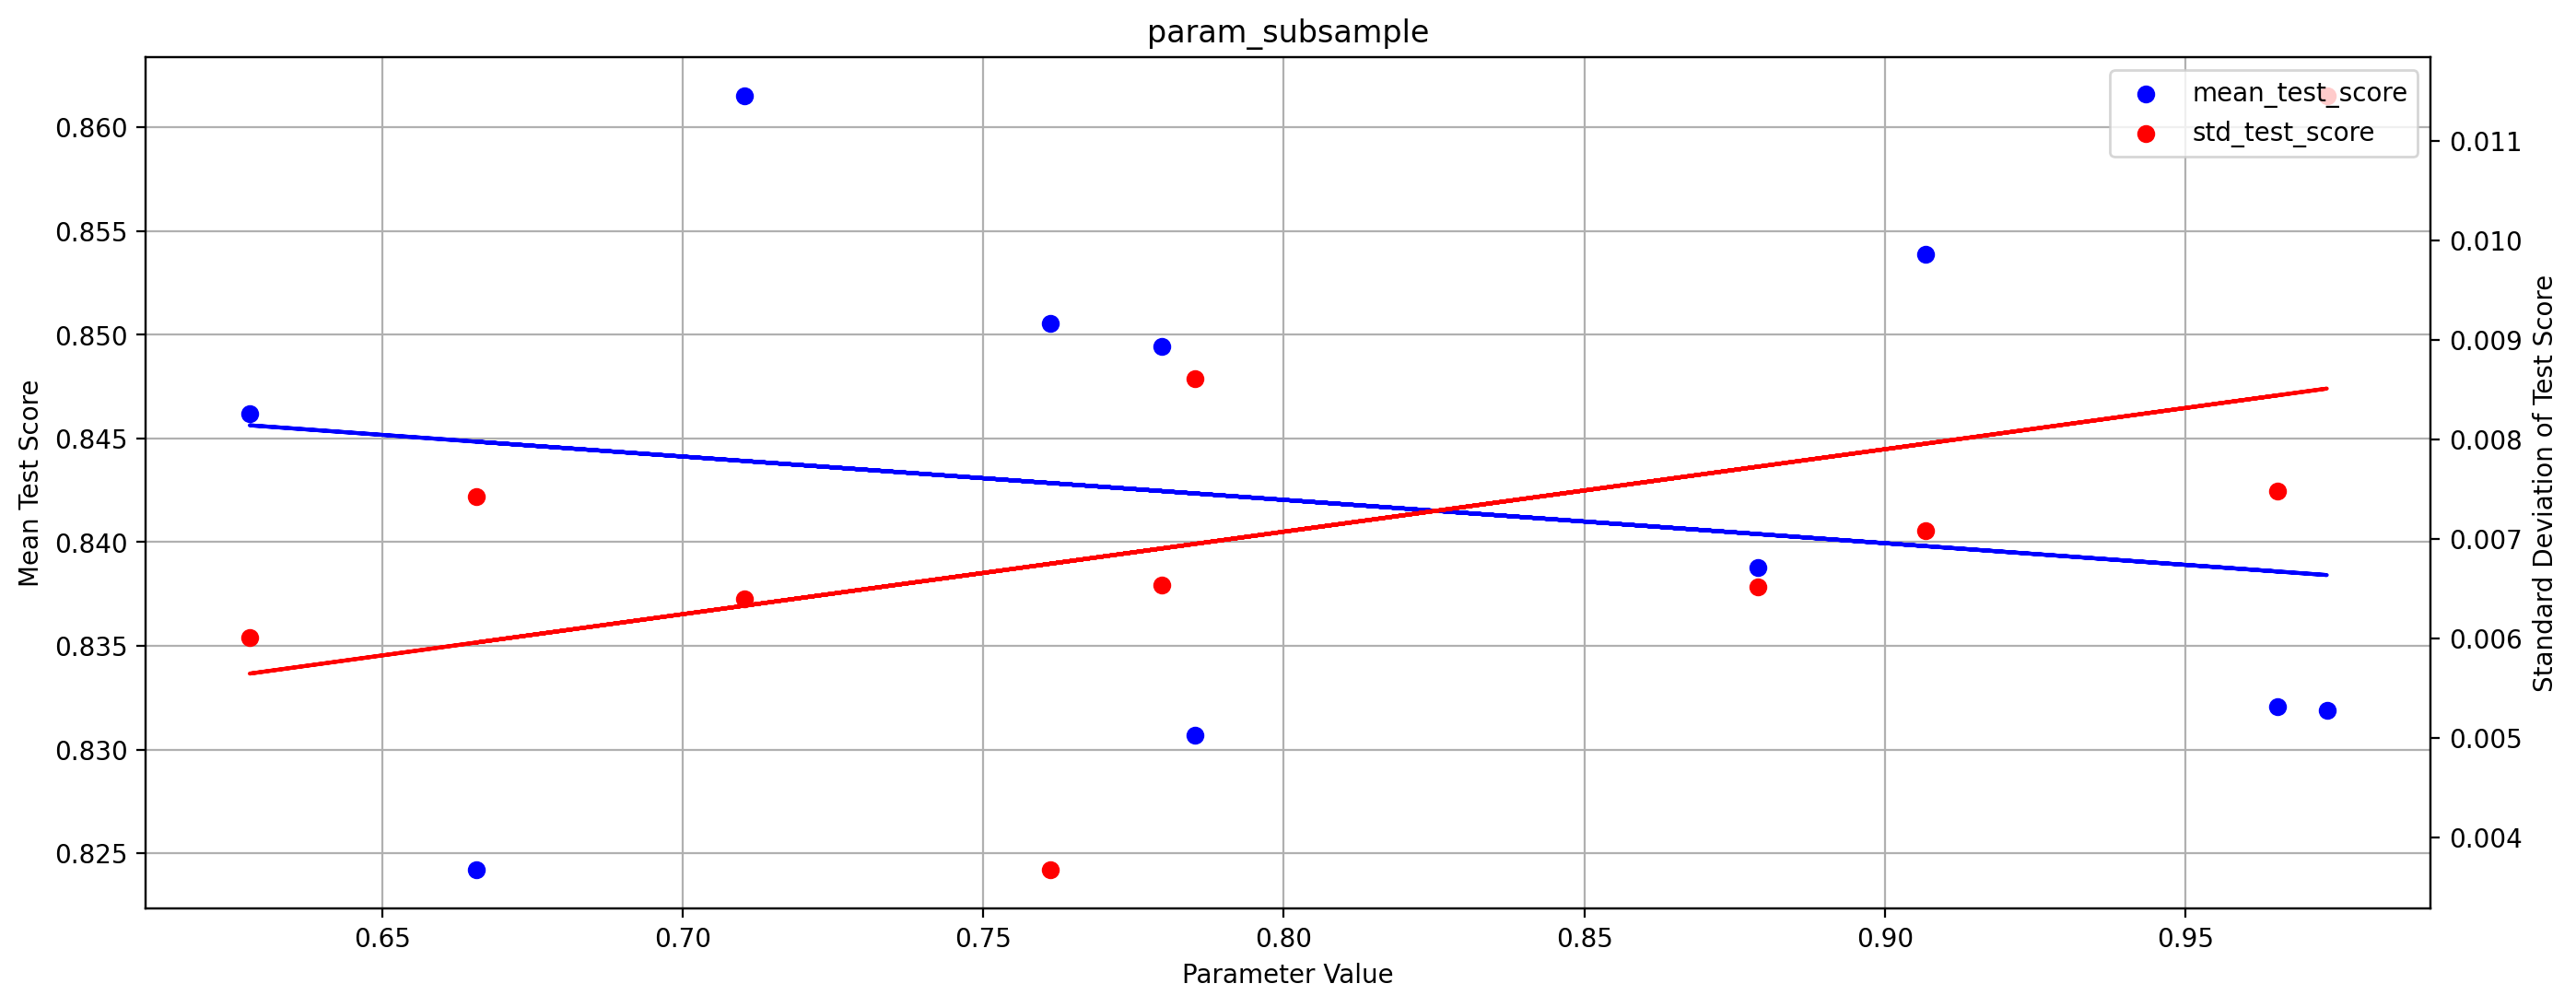

In [23]:
for param in ['param_colsample_bylevel', 'param_colsample_bynode', 'param_colsample_bytree',
                     'param_gamma', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 
                     'param_reg_alpha', 'param_reg_lambda', 'param_subsample']:
    x_values = cv_results[param]
    plot_parameters(x_values, param)

# Plotting Evaluation Metrics (Precision, Recall, F1-Score, AUC-ROC):


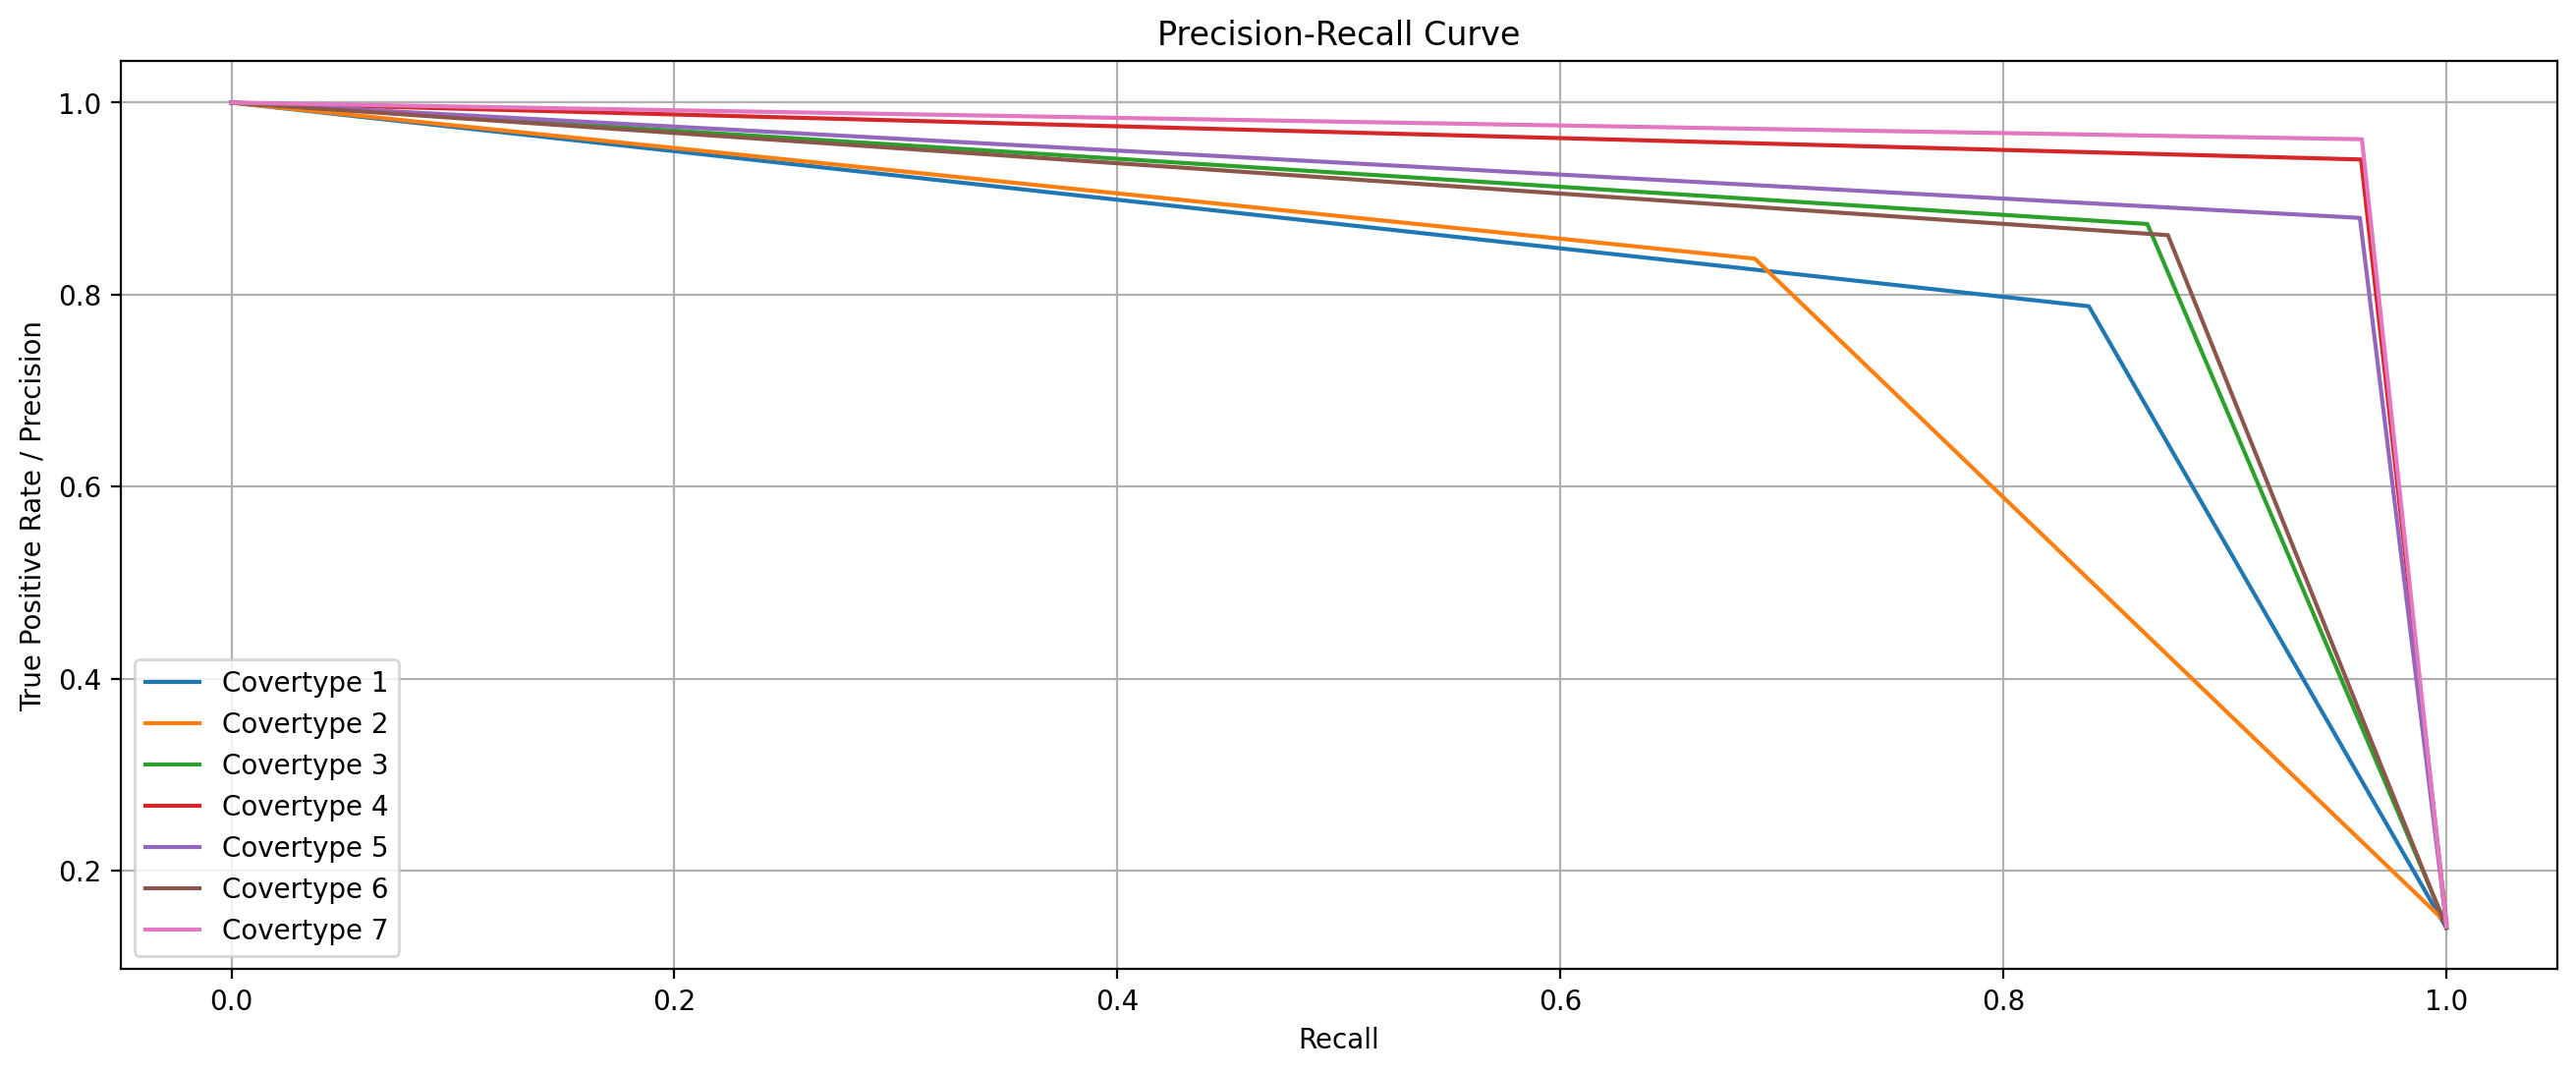

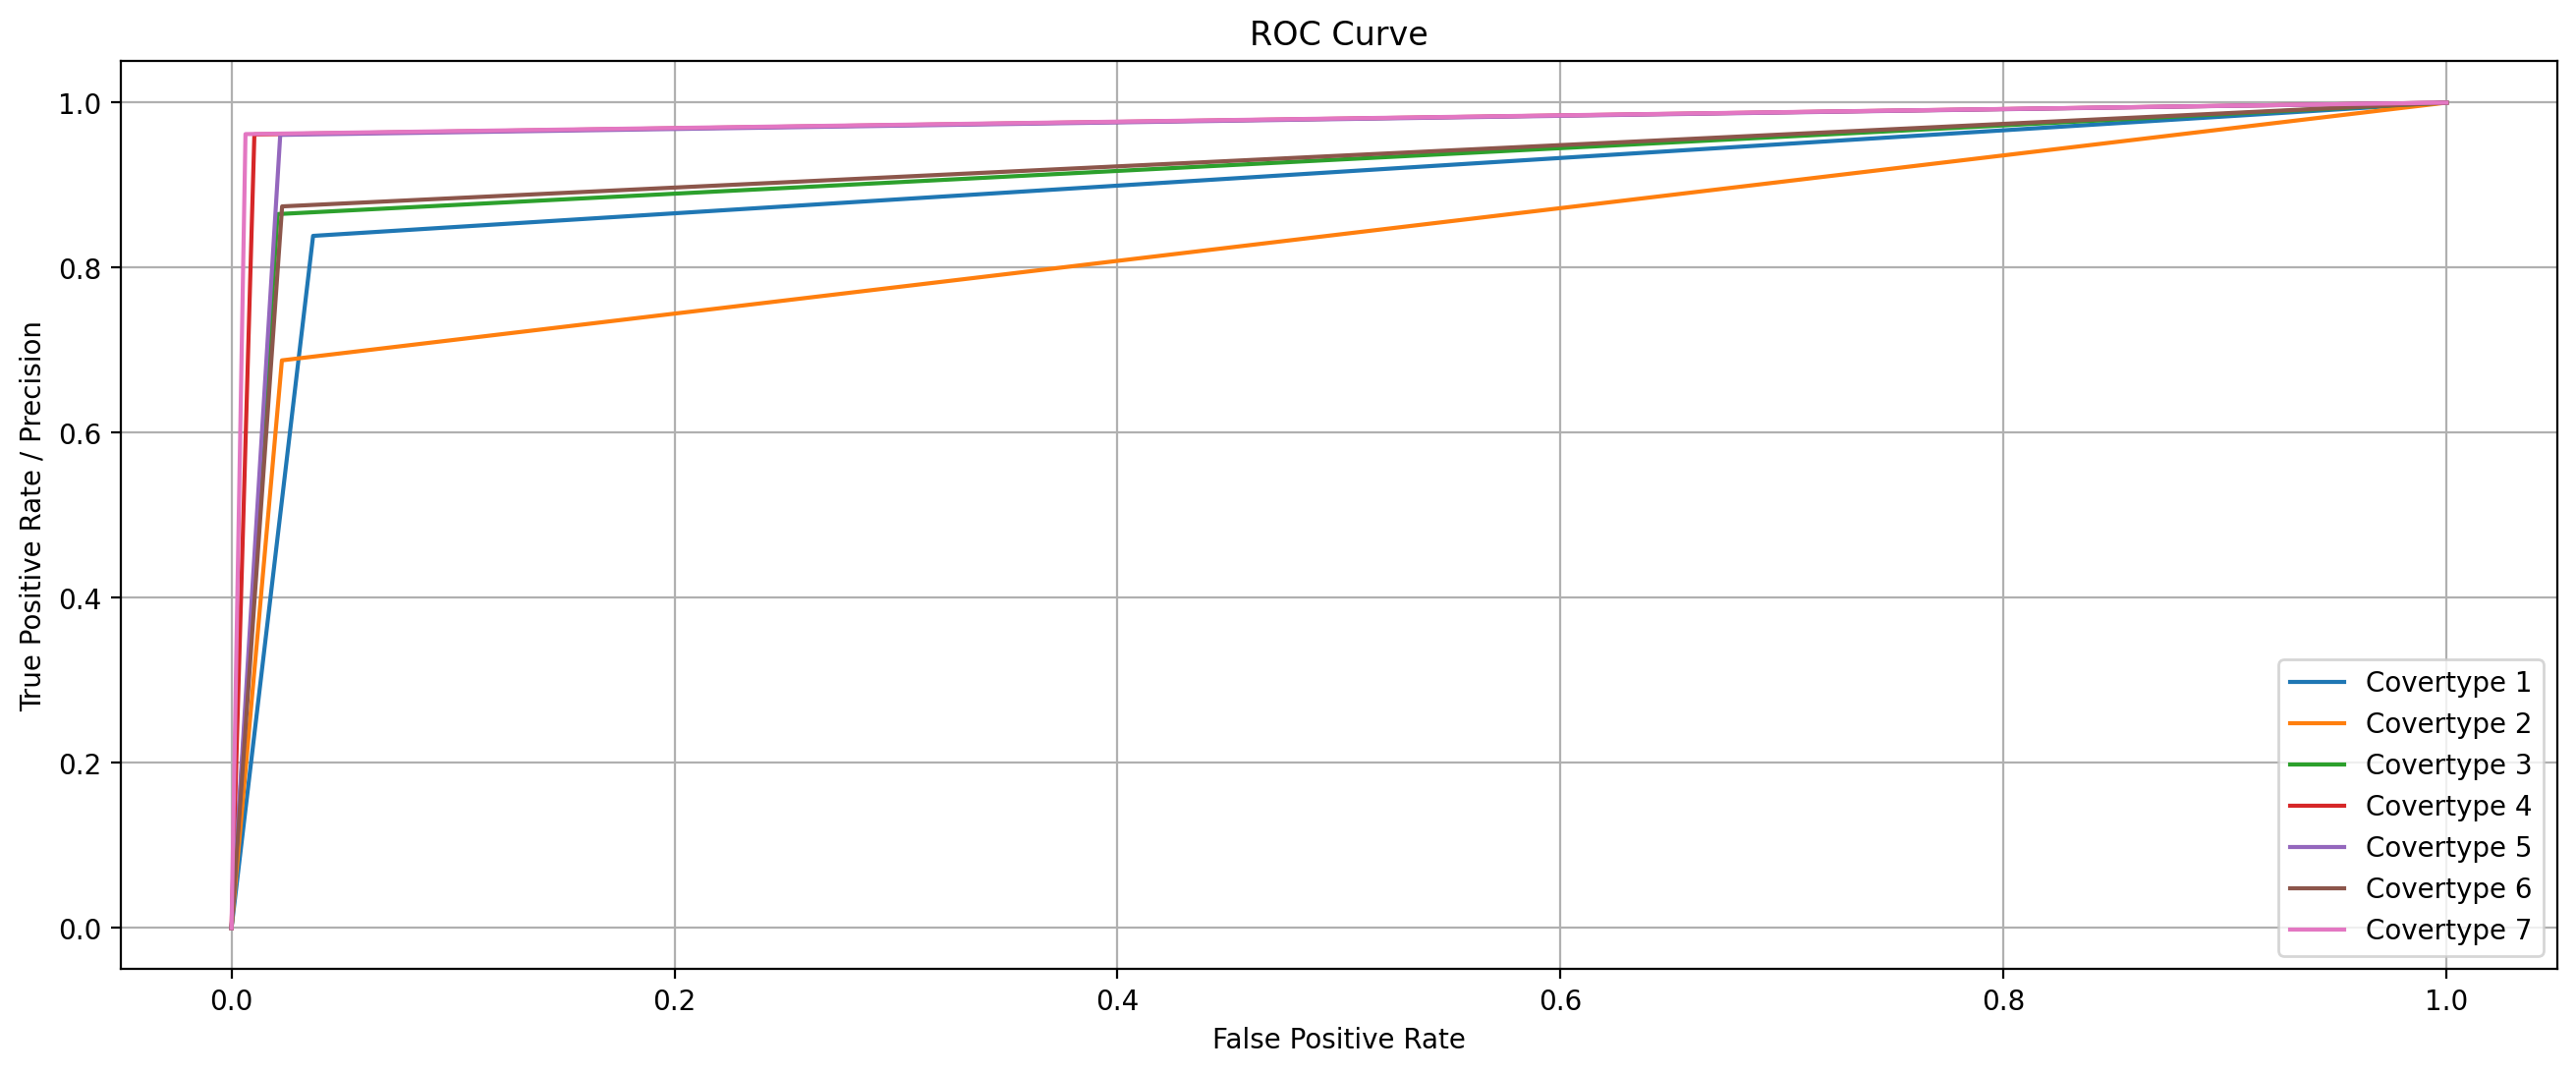

In [25]:

# For multiclass classification, you need to binarize the labels
y_true_bin = label_binarize(y_test, classes=np.unique(y_test))
y_score_bin = label_binarize(y_test_prediction, classes=np.unique(y_test_prediction))

auc_roc = roc_auc_score(y_true_bin, y_score_bin, average='macro')

# Plot Precision-Recall curve for each class
precision = dict()
recall = dict()

plt.figure(figsize=(16, 6))    
for i in range(7):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_score_bin[:, i])
    plt.plot(recall[i], precision[i], label='Covertype {}'.format(i + 1))

plt.grid()
plt.xlabel('Recall')
plt.ylabel('True Positive Rate / Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

filename = "precision_recall.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()


# Plot AUC-ROC curve for each class
fpr = dict()
tpr = dict()

plt.figure(figsize=(16, 6))    
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score_bin[:, i])
    plt.plot(fpr[i], tpr[i], label='Covertype {}'.format(i + 1))

plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate / Precision')
plt.title('ROC Curve')
plt.legend(loc='best')
            
filename = "roc_curve.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()


# Partial Dependence

In [26]:
# potentially iterate over features (and relation ie 0 to 1)

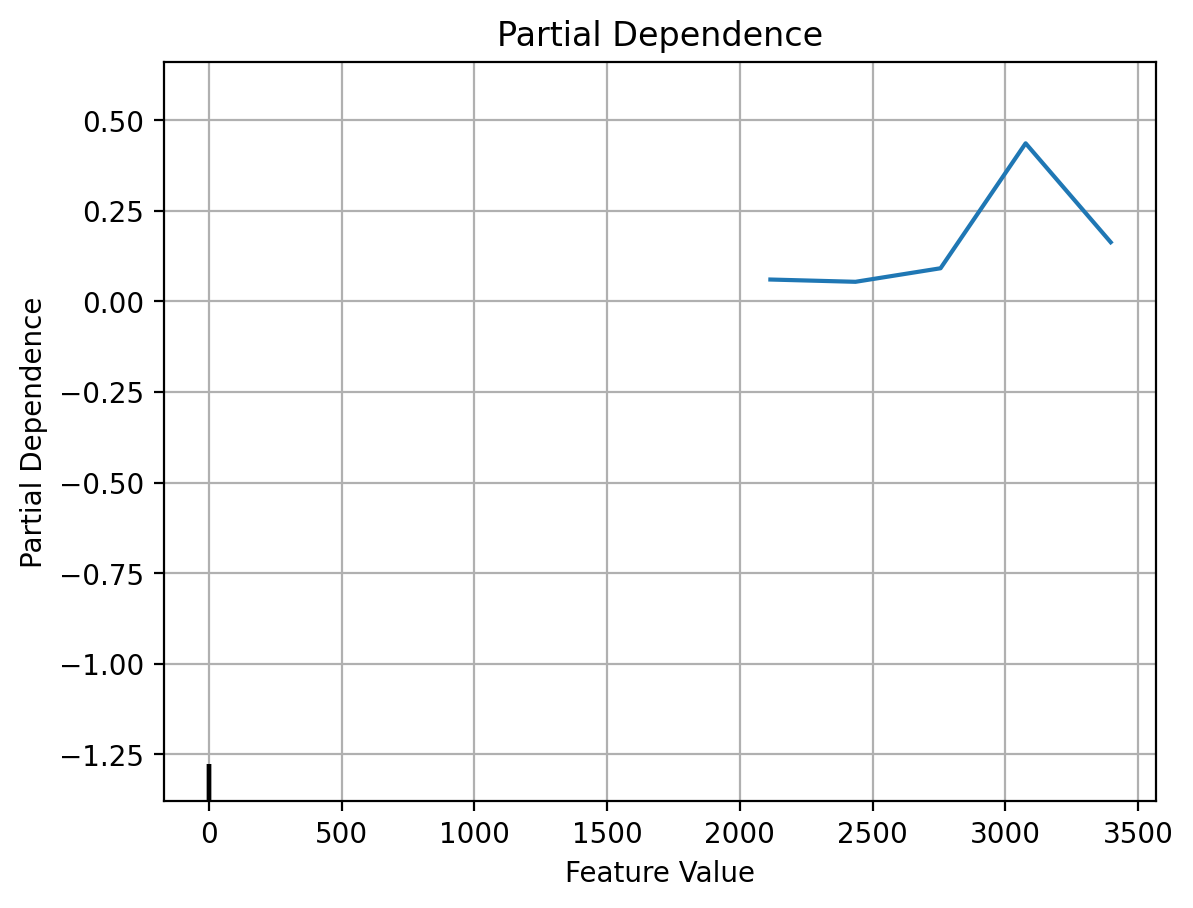

In [27]:

features, feature_names = [(0,)], [f"Features #{i}" for i in range(X.shape[1])]
deciles = {0: np.linspace(0, 1, num=5)}

pd_results = partial_dependence(
    model, X, features=1, kind="average", grid_resolution=5)

display = PartialDependenceDisplay(
    [pd_results], features=features, feature_names=feature_names,
    target_idx=0, deciles=deciles
)
display.plot(pdp_lim={1: (-1.38, 0.66)})

plt.grid()
plt.xlabel('Feature Value')
plt.ylabel('Partial Dependence') 
plt.title('Partial Dependence')

filename = "partial_dependence.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()


# Confusion Matrix

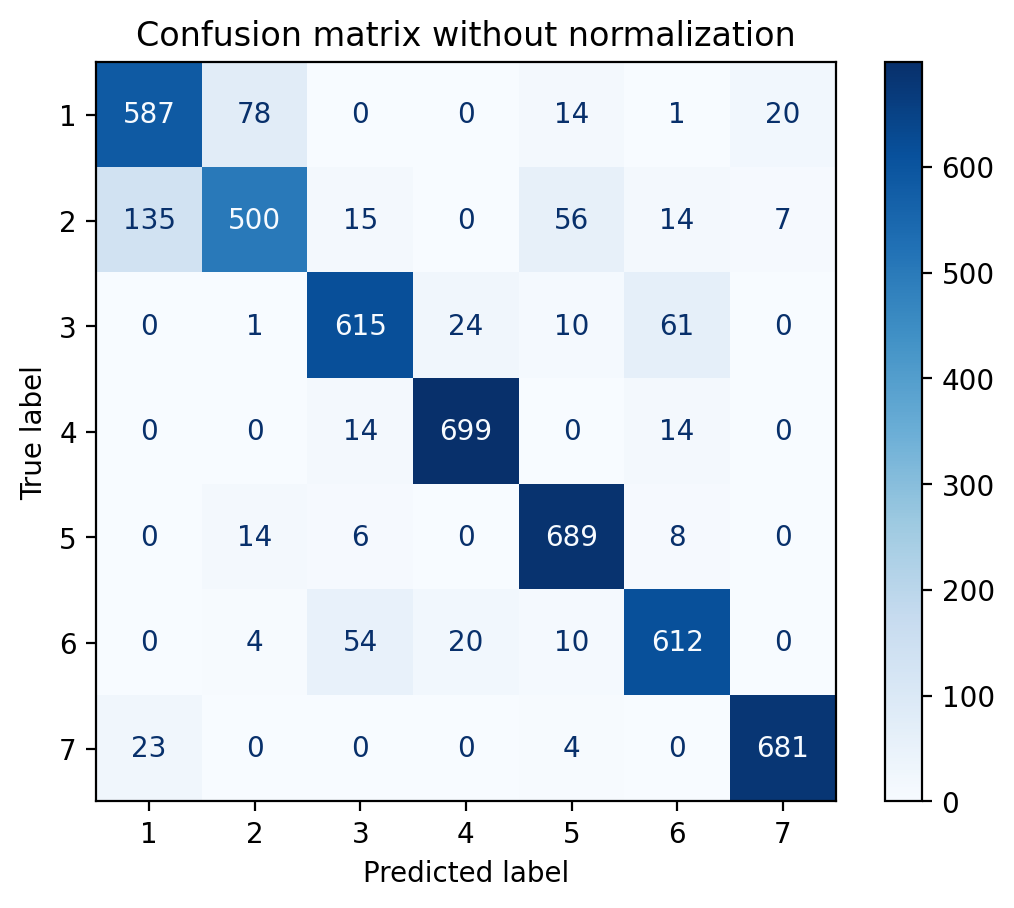

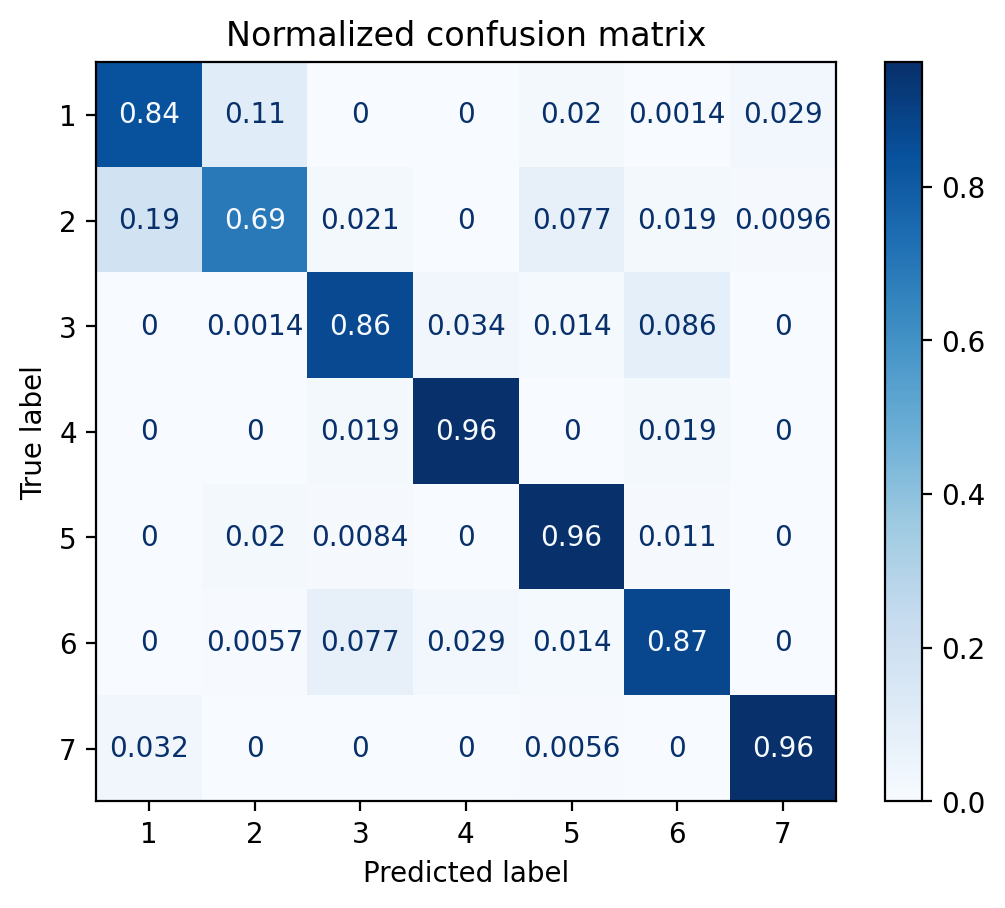

In [28]:

class_names = np.unique(y)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=class_names + 1,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    png_name = title.lower().replace(" ", "_")
    filename = f"{png_name}.png"
    plt.savefig(os.path.join(results_path, filename))

plt.show()

# Shap Values

In [33]:
explainer = shap.TreeExplainer(model)
explanation = explainer.shap_values(X_test, check_additivity=False)


In [36]:
shap.summary_plot(explanation, X_test, plot_type="bar", show=False)

filename = f"shap_summary.png"
plt.savefig(os.path.join(results_path, filename))
plt.close()  

SHAP values show how each feature affects each final prediction, the significance of each feature compared to others, and the model's reliance on the interaction between features.


In [ ]:
# IF WE SCALE: SCALE ONLY TRAIN DATA SET
# BOOSTING ALG:

# - Feature Selection: AUTOMATIC (NON CRITICAL)
# - Scaling: AUTOMATIC
# - Handling Missing Values: AUTOMATIC
# - Outliers: NEED TO DEAL WITH